In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
import time
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import numdifftools as nd

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *
from metadata import *
from data_manager import *
from registration_utilities import *
from annotation_utilities import *

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
No vtk


Setting environment for AWS compute node


# 1. Compute Confidence for Global Transform

In [2]:
warp_setting = 1
classifier_setting = 37

In [4]:
stack_moving = 'atlasV3'

In [4]:
volume_moving, structure_to_label_moving, label_to_structure_moving = \
DataManager.load_original_volume_all_known_structures(stack=stack_moving, sided=True)

File does not exist: /shared/CSHL_volumes/atlasV3/atlasV3_down32_annotationVolume/atlasV3_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume/score_volumes/atlasV3_down32_scoreVolume_outerContour.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume/score_volumes/atlasV3_down32_scoreVolume_outerContour.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume/score_volumes/atlasV3_down32_scoreVolume_outerContour.bp


Child returned 0
Child returned 1
0.60 seconds.
File does not exist: /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume/score_volumes/atlasV3_down32_scoreVolume_outerContour.bp
Score volume for outerContour does not exist.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume/score_volumes/atlasV3_down32_scoreVolume_sp5.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume/score_volumes/atlasV3_down32_scoreVolume_sp5.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume/score_volumes/atlasV3_down32_scoreVolume_sp5.bp


Child returned 1
0.60 seconds.
File does not exist: /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume/score_volumes/atlasV3_down32_scoreVolume_sp5.bp
Score volume for sp5 does not exist.
Volume shape: (373, 430, 369)


# All Stacks

In [ ]:
for stack_fixed in all_nissl_stacks:
# for stack_fixed in ['MD595']:

    volume_fixed, structure_to_label_fixed, label_to_structure_fixed = \
    DataManager.load_score_volume_all_known_structures(stack=stack_fixed, classifier_setting=classifier_setting)
    
    label_mapping_m2f = {label_m: structure_to_label_fixed[convert_to_original_name(name_m)] 
                         for label_m, name_m in label_to_structure_moving.iteritems()}
                        #     if name_m in ['7N_L', '7N_R', '12N', '5N_L', '5N_R']}
    
    aligner = Aligner4(volume_fixed, volume_moving, labelIndexMap_m2f=label_mapping_m2f)
    
    aligner.set_centroid(centroid_m='volume_centroid', centroid_f='volume_centroid')
    # aligner.set_centroid(centroid_m='structure_centroid', centroid_f='centroid_m', indices_m=[name_to_label_moving['SNR_R']])
    
    tx_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
        DataManager.load_alignment_parameters(stack_f=stack_fixed, stack_m=stack_moving,
                                              classifier_setting_m=classifier_setting, classifier_setting_f=classifier_setting, 
                                              warp_setting=warp_setting,
                                              downscale=32, trial_idx=trial_idx)
        
    ###############################
    ##### Compute Confidence ######
    ###############################

#     structures_for_computing_confidence = {'7N_L', '7N_R', '5N_L', '5N_R', '12N'}
#     labels_for_computing_confidence = [structure_to_label_moving[s] for s in structures_for_computing_confidence]
    labels_for_computing_confidence = label_to_structure_moving.keys()

    downscale = 32
    xy_pixel_distance = XY_PIXEL_DISTANCE_LOSSLESS * downscale

    fmax = aligner.compute_score(tx_params, indices_m=labels_for_computing_confidence)
    
    ######################
    ## Compute Hessians ##
    ######################
    
    def perturb(tx, ty, tz):
        return aligner.compute_score(tx_params + [0,0,0,tx,0,0,0,ty,0,0,0,tz],
                                 indices_m=labels_for_computing_confidence)

    hessians_all_stepsizes = {}
    stepsizes = np.linspace(1, 20, 5) # pixel size = 15um

    for stepsize in stepsizes:
        h = nd.Hessian(lambda (tx, ty, tz): perturb(tx, ty, tz), step=(stepsize, stepsize, stepsize))
        H = h((0,0,0))
        stepsize_um = stepsize * xy_pixel_distance
        hessians_all_stepsizes[stepsize_um] = (H, fmax)
        
    ##################
    ## Save hessian ##
    ##################

    fp = DataManager.get_confidence_filepath(stack_m=stack_moving, stack_f=stack_fixed, 
                                       classifier_setting_m=classifier_setting, classifier_setting_f=classifier_setting,
                                       warp_setting=warp_setting, trial_idx=trial_idx,
                                       what='hessians')

    create_if_not_exists(os.path.dirname(fp))
    save_pickle(hessians_all_stepsizes, fp)
    
    #####################
    ## Compute z-score ##
    #####################
    
    zscores = {}

    # pool_radius_um_list = np.arange(25, 400, 20)
    pool_radius_um_list = np.linspace(25, 400, 5)
    for pool_radius_um in pool_radius_um_list:

        pool_radius_pixel = pool_radius_um / xy_pixel_distance

        t = time.time()

    #     grid_size = 3
    #     dxs = np.arange(-pooling_radius, pooling_radius, grid_size)
    #     dys = np.arange(-pooling_radius, pooling_radius, grid_size)
    #     dzs = np.arange(-pooling_radius, pooling_radius, grid_size)
    #     neighbor_scores = aligner.compute_scores_neighborhood_grid(tx_params, dxs=dxs, dys=dys, dzs=dzs,
    #                                                                indices_m=labels_for_computing_confidence)

        neighbor_scores = aligner.compute_scores_neighborhood_random(tx_params, n=3000, 
                        stds=np.array([0,0,0,pool_radius_pixel,0,0,0,pool_radius_pixel,0,0,0,pool_radius_pixel]), 
                        indices_m=labels_for_computing_confidence)

        sys.stderr.write('Compute scores: %.2f seconds.\n' % (time.time() - t))

        mean = np.mean(neighbor_scores)
        std = np.std(neighbor_scores)
        z = (fmax - mean) / std

        zscores[pool_radius_um] = (z, fmax, mean, std)
        

    ###################
    ## Save z-scores ##
    ###################

    fp = DataManager.get_confidence_filepath(stack_m=stack_moving, stack_f=stack_fixed, 
                                       classifier_setting_m=classifier_setting, classifier_setting_f=classifier_setting,
                                       warp_setting=warp_setting, trial_idx=trial_idx,
                                       what='zscores')

    create_if_not_exists(os.path.dirname(fp))
    save_pickle(zscores, fp)

File does not exist: /oasis/projects/nsf/csd395/yuncong/CSHL_volumes/MD585/score_volumes/MD585_down32_scoreVolume_outerContour_setting_2.bp
Score volume for outerContour does not exist.
File does not exist: /oasis/projects/nsf/csd395/yuncong/CSHL_volumes/MD585/score_volumes/MD585_down32_scoreVolume_sp5_setting_2.bp
Score volume for sp5 does not exist.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Compute scores: 128.39 seconds.
Compute scores: 112.88 seconds.
Compute scores: 117.98 seconds.
Compute scores: 112.54 seconds.
Compute scores: 114.21 seconds.
File does not exist: /oasis/projects/nsf/csd395/yuncong/CSHL_volumes/MD589/score_volumes/MD589_down32_scoreVolume_outerContour_setting_2.bp
Score volume for outerContour does not exist.
File does not exist: /oasis/projects/nsf/csd395/yuncong/CSHL_volumes/MD589/score_volumes/MD589_down32_scoreVolume_sp5_setting_2.bp
Score volume for sp5 does not exist.
Label weights not set, default

# ONE Stack

In [87]:
stack_fixed = 'MD635'

# Load Fixed Volumes

In [88]:
volume_fixed, structure_to_label_fixed, label_to_structure_fixed = \
DataManager.load_original_volume_all_known_structures(stack=stack_fixed, classifier_setting=classifier_setting,
                                                     sided=False, volume_type='score')

structure_subset = ['7N_L', '7N_R', '12N', '5N_L','5N_R','Pn_L', 'Pn_R', 'SNR_L', 'SNR_R', 'VLL_L', 'VLL_R', '7n_L',
          '7n_R', 'Tz_L', 'Tz_R', 'VCA_L', 'VCP_R']

# label_mapping_m2f = {label_m: structure_to_label_fixed[convert_to_original_name(name_m)] 
#                      for label_m, name_m in label_to_structure_moving.iteritems()}
    
label_mapping_m2f = {label_m: structure_to_label_fixed[convert_to_original_name(name_m)] 
                     for label_m, name_m in label_to_structure_moving.iteritems()
                         if name_m in structure_subset}

File does not exist: /shared/CSHL_volumes/MD635/MD635_down32_annotationVolume/MD635_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.


rm -rf /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_outerContour.bp && mkdir -p /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes


Child returned 0

aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_outerContour.bp /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_outerContour.bp



Child returned 1
1.43 seconds.
File does not exist: /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_outerContour.bp
Score volume for outerContour does not exist.


rm -rf /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_sp5.bp && mkdir -p /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes


Child returned 0

aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_sp5.bp /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_sp5.bp



Child returned 1
1.37 seconds.
File does not exist: /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_sp5.bp
Score volume for sp5 does not exist.
Volume shape: (445, 655, 397)


In [89]:
aligner = Aligner4(volume_fixed, volume_moving, labelIndexMap_m2f=label_mapping_m2f)
aligner.set_centroid(centroid_m='volume_centroid', centroid_f='centroid_m')

m: [ 215.   186.5  184.5] f: [ 215.   186.5  184.5]


Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


# Read Global Transform Estimate

In [90]:
tx_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
DataManager.load_alignment_parameters(stack_f=stack_fixed, stack_m=stack_moving,
                                      classifier_setting_m=classifier_setting, classifier_setting_f=classifier_setting, 
                                      warp_setting=warp_setting,
                                      type_f='score', type_m='score',
                                      downscale=32)

In [121]:
# structures_for_computing_confidence = {'7N_L'}
structures_for_computing_confidence = ['7N_L', '7N_R', '12N', '5N_L','5N_R','Pn_L', 'Pn_R', 'SNR_L', 'SNR_R', 'VLL_L', 'VLL_R', '7n_L',
          '7n_R', 'Tz_L', 'Tz_R', 'VCA_L', 'VCP_R']
labels_for_computing_confidence = [structure_to_label_moving[s] for s in structures_for_computing_confidence]
# labels_for_computing_confidence = label_to_structure_moving.keys()

fmax = aligner.compute_score(tx_params, indices_m=labels_for_computing_confidence)
print fmax

0.698684551753


In [122]:
downscale = 32
xy_pixel_distance = XY_PIXEL_DISTANCE_LOSSLESS * downscale

# Optimize

In [93]:
# gradient_filepath_map_f = {ind_f: DataManager.get_score_volume_gradient_filepath_template(\
#                             stack=stack_fixed, structure=label_to_structure_fixed[ind_f],
#                             downscale=32, setting=classifier_setting)
#                            for ind_m, ind_f in label_mapping_m2f.iteritems()}

# aligner.load_gradient(gradient_filepath_map_f=gradient_filepath_map_f) # 120s = 2 mins

# while True:

#     try:

#         if global_transform_scheme == 1:

#             T, scores = aligner.optimize(type='affine', max_iter_num=1000, history_len=10, terminate_thresh=1e-4,
# #                                          indices_m=[name_to_label_moving['SC'], name_to_label_moving['IC'],
# #                                                    name_to_label_moving['SC_surround'], name_to_label_moving['IC_surround']],
#                                          indices_m=None,
#                                         grid_search_iteration_number=30,
#                                          grid_search_sample_number=100,
#                                          grad_computation_sample_number=1e5,
#                                          lr1=10, lr2=0.1,
#                                         std_tx=50, std_ty=50, std_tz=100, std_theta_xy=np.deg2rad(10))

#         elif global_transform_scheme == 2:

#             T, scores = aligner.optimize(type='rigid', max_iter_num=1000, history_len=10, terminate_thresh=1e-4,
#                                          indices_m=None,
#                                         grid_search_iteration_number=30,
#                                          grid_search_sample_number=100,
#                                          grad_computation_sample_number=1e5,
#                                          lr1=10, lr2=0.1,
#                                         std_tx=50, std_ty=50, std_tz=100, std_theta_xy=np.deg2rad(10))
        
#         break
        
#     except Exception as e:
#         sys.stderr.write(e.message + '\n')

# Compute Hessian

In [146]:
"""
hessians_all_stepsizes (dict): {step size in um: (Hessian matrix at the estimate, fmax)}
"""

def perturb(tx, ty, tz):
    return aligner.compute_score(tx_params + [0,0,0,tx,0,0,0,ty,0,0,0,tz],
                                 indices_m=labels_for_computing_confidence)

hessians_all_stepsizes = {}
stepsizes = np.linspace(1, 20, 5) # pixel size = 15um

for stepsize in stepsizes:
    h = nd.Hessian(lambda (tx, ty, tz): perturb(tx, ty, tz), step=(stepsize, stepsize, stepsize))
    H = h((0,0,0))
    stepsize_um = stepsize * xy_pixel_distance
    hessians_all_stepsizes[stepsize_um] = (H, fmax)

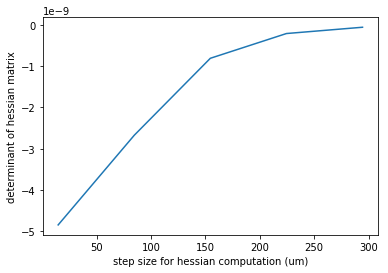

In [154]:
ss = [stepsize_um for stepsize_um, (H, _) in sorted(hessians_all_stepsizes.iteritems())]
hs = [np.linalg.det(H) for stepsize_um, (H, _) in sorted(hessians_all_stepsizes.iteritems())]
plt.plot(ss, hs);
plt.xlabel('step size for hessian computation (um)');
plt.ylabel('determinant of hessian matrix');

In [174]:
# Save hessian

fp = DataManager.get_confidence_filepath(stack_m=stack_moving, stack_f=stack_fixed, 
                                         type_m='score', type_f='score',
                                         classifier_setting_m=classifier_setting, 
                                         classifier_setting_f=classifier_setting,
                                         warp_setting=warp_setting,
                                         what='hessians')

create_parent_dir_if_not_exists(fp)
save_pickle(hessians_all_stepsizes, fp)
upload_to_s3(fp)

aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_parameters_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_parameters_hessians.pkl


Child returned 0
0.75 seconds.


# Compute z-score

In [155]:
"""
zscores (dict): {pooling radius in um: (z, fmax, mean, std)}
"""

zscores = {}

# pool_radius_um_list = np.arange(25, 400, 20)
pool_radius_um_list = np.linspace(25, 400, 5)
for pool_radius_um in pool_radius_um_list:
    
    pool_radius_pixel = pool_radius_um / xy_pixel_distance

    t = time.time()
    
#     grid_size = 3
#     dxs = np.arange(-pooling_radius, pooling_radius, grid_size)
#     dys = np.arange(-pooling_radius, pooling_radius, grid_size)
#     dzs = np.arange(-pooling_radius, pooling_radius, grid_size)
#     neighbor_scores = aligner.compute_scores_neighborhood_grid(tx_params, dxs=dxs, dys=dys, dzs=dzs,
#                                                                indices_m=labels_for_computing_confidence)
    
    neighbor_scores = aligner.compute_scores_neighborhood_random(tx_params, n=3000, 
                    stds=np.array([0,0,0,pool_radius_pixel,0,0,0,pool_radius_pixel,0,0,0,pool_radius_pixel]), 
                    indices_m=labels_for_computing_confidence)
    
    sys.stderr.write('Compute scores: %.2f seconds.\n' % (time.time() - t))
    
    mean = np.mean(neighbor_scores)
    std = np.std(neighbor_scores)
    z = (fmax - mean) / std
    
    zscores[pool_radius_um] = (z, fmax, mean, std)

Compute scores: 28.24 seconds.
Compute scores: 28.17 seconds.
Compute scores: 28.61 seconds.
Compute scores: 28.47 seconds.
Compute scores: 28.23 seconds.


In [175]:
# Save z-scores

fp = DataManager.get_confidence_filepath(stack_m=stack_moving, stack_f=stack_fixed, 
                                    type_m='score', type_f='score',
                                   classifier_setting_m=classifier_setting, 
                                         classifier_setting_f=classifier_setting,
                                   warp_setting=warp_setting,
                                   what='zscores')

create_parent_dir_if_not_exists(fp)
save_pickle(zscores, fp)
upload_to_s3(fp)

aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_parameters_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_parameters_zscores.pkl


Child returned 0
0.75 seconds.


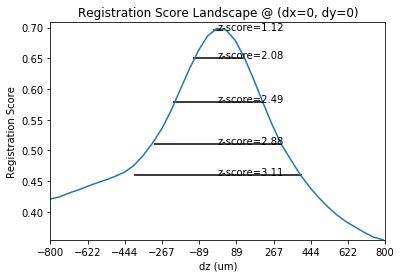

In [156]:
# Visualize a z-slice of the registration score function.

max_pooling_radius_um = 800
max_pooling_radius_pixel = max_pooling_radius_um / xy_pixel_distance

grid_size = 3
dzs = np.arange(-max_pooling_radius_pixel, max_pooling_radius_pixel, grid_size)
neighbor_scores = aligner.compute_scores_neighborhood_grid(tx_params, dxs=[0], dys=[0], dzs=dzs,
                                                           indices_m=labels_for_computing_confidence)
plt.figure();
plt.plot(dzs * xy_pixel_distance, neighbor_scores)
plt.ylim([np.min(neighbor_scores), np.max(neighbor_scores) + .01]);
plt.xlim([-max_pooling_radius_um, max_pooling_radius_um]);
plt.title('Registration Score Landscape @ (dx=0, dy=0)')
plt.ylabel('Registration Score');
plt.xlabel('dz (um)');
plt.xticks(np.linspace(-max_pooling_radius_um, max_pooling_radius_um, 10));

for poolradius_um, (z, fmax, mean, std) in zscores.iteritems():
    plt.hlines(mean, -poolradius_um, poolradius_um);
    plt.text(x=0, y=mean, s='z-score=%.2f'%z, fontsize=10);

plt.show();

- The width of each black bar corresponds to the size of the pooling region.
- The height of each black bar is the mean score in that pooling region.
- The z-score is higher if the pooling region is larger.

# Compute Peak Radius
- Use the pre-computed hessian matrix to approximate a neighborhood around score maxima by a quadratic function. The neighborhood size is controlled by step size $\delta$.
- The hessian matrix also gives the directions of min and max change.
- Peak radius is the distance from the maxima along either the min or max direction that the quadratic approximation drops to the mean of neighborhood N2. This neighborhood is specified by a pooling radius $r$.

In [123]:
stack_moving = 'atlasV2'
stack_fixed = 'MD635'

In [130]:
classifier_setting = 37
warp_setting = 1

In [131]:
downscale = 32
xy_pixel_distance = XY_PIXEL_DISTANCE_LOSSLESS * downscale

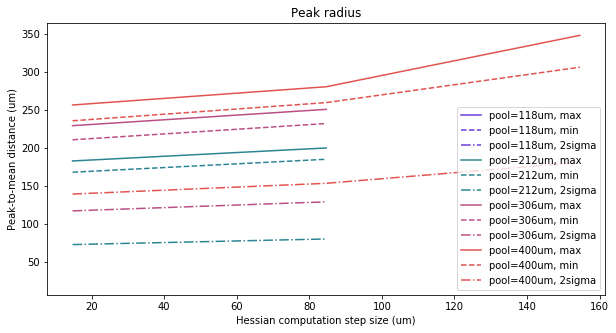

In [173]:
from collections import defaultdict
peak_radius_all_stacks = defaultdict(list)

# for stack_fixed in all_nissl_stacks:
for stack_fixed in ['MD635']:
    
    # Load previously computed confidence measures

    zscores = DataManager.load_confidence(stack_m=stack_moving, stack_f=stack_fixed, 
                                       classifier_setting_m=classifier_setting, classifier_setting_f=classifier_setting,
                                       warp_setting=warp_setting,
                                       what='zscores')

    hessians_all_stepsizes = DataManager.load_confidence(stack_m=stack_moving, stack_f=stack_fixed, 
                                       classifier_setting_m=classifier_setting, classifier_setting_f=classifier_setting,
                                       warp_setting=warp_setting,
                                       what='hessians')
    
    peak_radius = defaultdict(dict)
    for poolradius_um, (zscore, fmax, mu, std) in zscores.iteritems():
        for stepsize_um, (H, fmax) in hessians_all_stepsizes.iteritems():
            if poolradius_um > stepsize_um * 2:  # compute only if pooling radius is at least twice the step size
                U, S, UT = np.linalg.svd(H)

                # using the smallest eigenvalues of Hessians (flattest direction), score drops to mean
                peak_radius_pixel_max = np.sqrt(2*(fmax-mu)/S[-1])

                # using the largest eigenvalues of Hessians (steepest direction), score drops to mean
                peak_radius_pixel_min = np.sqrt(2*(fmax-mu)/S[0])

                # using the largest eigenvalues of Hessians, scores drops to the value with 2-sigma significance
                peak_radius_pixel_2sigma = np.sqrt(2*(fmax-(mu+2*std))/S[0])

                peak_radius[poolradius_um][stepsize_um] = (peak_radius_pixel_max * xy_pixel_distance,
                                                          peak_radius_pixel_min * xy_pixel_distance,
                                                          peak_radius_pixel_2sigma * xy_pixel_distance)
    peak_radius.default_factory = None

    # Plot
    plt.figure(figsize=(10,5));
    for poolradius_um, v in sorted(peak_radius.items()):
        xs, ys_max_min_2sigma = zip(*sorted(v.items()))
        ys_max, ys_min, ys_2sigma = zip(*ys_max_min_2sigma)
        c = np.array(random_colors(1)[0])/255.
        plt.plot(xs, ys_max, linestyle='-', color=c, label='pool=%dum, max' % poolradius_um);
        plt.plot(xs, ys_min, linestyle='--', color=c, label='pool=%dum, min' % poolradius_um);
        plt.plot(xs, ys_2sigma, linestyle='-.', color=c, label='pool=%dum, 2sigma' % poolradius_um);
    plt.legend(loc='lower right');
    plt.title('Peak radius');
    plt.xlabel('Hessian computation step size (um)');
    plt.ylabel('Peak-to-mean distance (um)');
    plt.show();

# Plot z-scores and hessians for all stacks

In [176]:
stack_moving = 'atlasV3'

zscores_all_stacks = {}
hessians_all_stacks_all_stepsizes = {}

# for stack_fixed in all_nissl_stacks:
for stack_fixed in ['MD635']:

    zscores = DataManager.load_confidence(stack_m=stack_moving, stack_f=stack_fixed, 
                                       classifier_setting_m=classifier_setting, classifier_setting_f=classifier_setting,
                                       warp_setting=warp_setting,
                                       what='zscores')

    hessians_all_stepsizes = DataManager.load_confidence(stack_m=stack_moving, stack_f=stack_fixed, 
                                       classifier_setting_m=classifier_setting, classifier_setting_f=classifier_setting,
                                       warp_setting=warp_setting,
                                       what='hessians')
    
    zscores_all_stacks[stack_fixed] = zscores
    hessians_all_stacks_all_stepsizes[stack_fixed] = hessians_all_stepsizes

## plot z-scores for all stacks

In [177]:
pool_radius_list = sorted(zscores_all_stacks.values()[0].keys())

In [178]:
# choose to use which pooling radius for z-score

pool_radius = pool_radius_list[1]
print pool_radius

118.75


In [179]:
zscore_toplot_all_stacks = {st: zs[pool_radius][0] for st, zs in zscores_all_stacks.iteritems()}

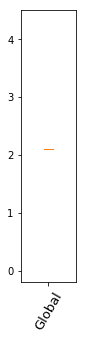

In [180]:
plt.figure(figsize=(1, 5));
D = [zscore_toplot_all_stacks.values()]
plt.boxplot(D);
plt.ylim([-.2,4.5]);
plt.xticks(range(1, 2), ['Global'], rotation='60', fontsize=13);

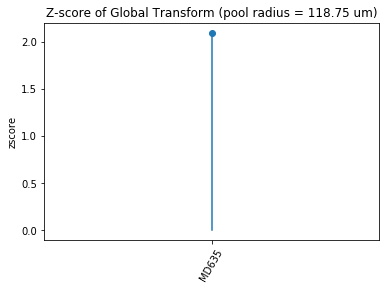

In [181]:
plt.stem(zscore_toplot_all_stacks.values());
plt.xticks(range(len(zscore_toplot_all_stacks)), zscore_toplot_all_stacks.keys(), rotation='60');
plt.title('Z-score of Global Transform (pool radius = %.2f um)' % pool_radius);
plt.ylabel('zscore');

# 2. Compute Confidence for Local Transforms

In [2]:
warp_setting = 8
classifier_setting = 37

In [3]:
warp_properties = registration_settings.loc[warp_setting]
print warp_properties

upstream_warp_setting = warp_properties['upstream_warp_id']
if upstream_warp_setting == 'None':
    upstream_warp_setting = None
else:
    upstream_warp_setting = int(upstream_warp_setting)
    
transform_type = warp_properties['transform_type']
terminate_thresh = warp_properties['terminate_thresh']
grad_computation_sample_number = warp_properties['grad_computation_sample_number']
grid_search_sample_number = warp_properties['grid_search_sample_number']
std_tx_um = warp_properties['std_tx_um']
std_ty_um = warp_properties['std_ty_um']
std_tz_um = warp_properties['std_tz_um']
std_tx = std_tx_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_ty = std_ty_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_tz = std_tz_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_theta_xy = np.deg2rad(warp_properties['std_theta_xy_degree'])
print std_tx, std_ty, std_tz, std_theta_xy

reg_weight = warp_properties['regularization_weight']
reg_weights = np.ones((3,))*reg_weight

surround_weight = warp_properties['surround_weight']
# surround_weight = -.5
include_surround = surround_weight != 0

upstream_warp_id                        1
transform_type                      rigid
terminate_thresh                    1e-06
grad_computation_sample_number     100000
grid_search_sample_number           10000
std_tx_um                             200
std_ty_um                             200
std_tz_um                             200
std_theta_xy_degree                    30
surround_weight                   inverse
regularization_weight                   0
Name: 8, dtype: object
13.5869565217 13.5869565217 13.5869565217 0.523598775598


In [4]:
stack_moving = 'atlasV3'

# Compute z-scores and hessians for all structures for all stacks

In [8]:
downscale = 32
xy_pixel_distance = XY_PIXEL_DISTANCE_LOSSLESS * downscale

In [9]:
# for stack_fixed in all_nissl_stacks:
for stack_fixed in ['MD635', 'MD642']:

    volume_fixed, structure_to_label_fixed, label_to_structure_fixed = \
    DataManager.load_original_volume_all_known_structures(stack=stack_fixed, 
                                                          classifier_setting=classifier_setting,
                                                         sided=False, volume_type='score')

    for structure in all_known_structures_sided:
#     for structure in ['7N_L']:

        try:
            
            ##############################
            # Initialize aligner object. #
            ##############################
            
            if include_surround:
                volume_moving = DataManager.load_transformed_volume_all_known_structures(stack_m=stack_moving, stack_f=stack_fixed,
                                                                             classifier_setting_m=classifier_setting,
                                                                             classifier_setting_f=classifier_setting,
                                                                             warp_setting=upstream_warp_setting, 
                                                                             structures=[structure, 
                                                                                         convert_to_surround_name(structure, margin='200')])
            else:
                volume_moving = DataManager.load_transformed_volume_all_known_structures(stack_m=stack_moving, stack_f=stack_fixed,
                                                                             classifier_setting_m=classifier_setting,
                                                                             classifier_setting_f=classifier_setting,
                                                                             warp_setting=upstream_warp_setting, 
                                                                             structures=[structure])

            structure_to_label_moving = {s: l+1 for l, s in enumerate(sorted(volume_moving.keys()))}
            label_to_structure_moving = {l+1: s for l, s in enumerate(sorted(volume_moving.keys()))}
            volume_moving = {structure_to_label_moving[s]: v for s, v in volume_moving.items()}

            volume_moving_structure_sizes = {l: np.count_nonzero(vol > 0) for l, vol in volume_moving.iteritems()}

            label_mapping_m2f = {label_m: structure_to_label_fixed[convert_to_original_name(name_m)] 
                                 for label_m, name_m in label_to_structure_moving.iteritems()}

            if surround_weight == 'inverse':
                label_weights_m = {label_m: -volume_moving_structure_sizes[structure_to_label_moving[convert_to_nonsurround_name(name_m)]]
                                   /float(volume_moving_structure_sizes[label_m])
                                   if is_surround_label(name_m) else 1. \
                                   for label_m, name_m in label_to_structure_moving.iteritems()}
            elif isinstace(surround_weight, int) or isinstace(surround_weight, float):
                label_weights_m = {label_m: surround_weight if is_surround_label(name_m) else 1. \
                                   for label_m, name_m in label_to_structure_moving.iteritems()}
            else:
                sys.stderr.write("surround_weight %s is not recognized. Using the default.\n" % surround_weight)

            aligner = Aligner4(volume_fixed, volume_moving, labelIndexMap_m2f=label_mapping_m2f)

            aligner.set_centroid(centroid_m='structure_centroid', centroid_f='centroid_m', 
                                 indices_m=[structure_to_label_moving[structure]])                            

            aligner.set_regularization_weights(reg_weights)
            aligner.set_label_weights(label_weights_m)

            ########################################
            # Read previous computed best estimate #
            ########################################

            tx_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
            DataManager.load_alignment_parameters(stack_m=stack_moving, stack_f=stack_fixed,
                                                  classifier_setting_m=classifier_setting,
                                                  classifier_setting_f=classifier_setting,
                                                  warp_setting=warp_setting,
                                                  param_suffix=structure)

    #         structures_for_computing_confidence = {'7N_L', '7N_R', '5N_L', '5N_R', '12N'}
    #         labels_for_computing_confidence = [structure_to_label_moving[s] for s in structures_for_computing_confidence]
    #         labels_for_computing_confidence = label_to_structure_moving.keys()

            labels_for_computing_confidence = [structure_to_label_moving[structure]]

            fmax = aligner.compute_score(tx_params, indices_m=labels_for_computing_confidence)

            ####################
            # Compute Hessians #
            ####################
            
            def perturb(tx, ty, tz):
                return aligner.compute_score(tx_params + [0,0,0,tx,0,0,0,ty,0,0,0,tz],
                                             indices_m=labels_for_computing_confidence)

            hessians_all_stepsizes = {}
            stepsizes = np.linspace(1, 20, 5) # pixel size = 15um

            for stepsize in stepsizes:
                h = nd.Hessian(lambda (tx, ty, tz): perturb(tx, ty, tz), step=(stepsize, stepsize, stepsize))
                H = h((0,0,0))
                stepsize_um = stepsize * xy_pixel_distance
                hessians_all_stepsizes[stepsize_um] = (H, fmax)
#                 U, S, UT = np.linalg.svd(H)
#                 steepest_dir = U[:,0]
#                 flattest_dir = U[:,-1]
#                 stepsize_um = stepsize * xy_pixel_distance
#                 hessians_all_stepsizes[stepsize_um] = (H, fmax, steepest_dir, flattest_dir)

            #################
            # Save hessians #
            #################

            fp = DataManager.get_confidence_filepath(stack_m=stack_moving, stack_f=stack_fixed,
                                                   classifier_setting_m=classifier_setting, classifier_setting_f=classifier_setting,
                                                   warp_setting=warp_setting,
                                                     param_suffix=structure,
                                                     what='hessians')

            create_parent_dir_if_not_exists(fp)
            save_pickle(hessians_all_stepsizes, fp)
            upload_to_s3(fp)           
            
            ###################
            # Compute z-score #
            ###################

            zscores = {}

            # pool_radius_um_list = np.arange(25, 400, 20)
            pool_radius_um_list = np.linspace(25, 400, 5)
            for pool_radius_um in pool_radius_um_list:

                pool_radius_pixel = pool_radius_um / xy_pixel_distance

                t = time.time()

            #     grid_size = 3
            #     dxs = np.arange(-pooling_radius, pooling_radius, grid_size)
            #     dys = np.arange(-pooling_radius, pooling_radius, grid_size)
            #     dzs = np.arange(-pooling_radius, pooling_radius, grid_size)
            #     neighbor_scores = aligner.compute_scores_neighborhood_grid(tx_params, dxs=dxs, dys=dys, dzs=dzs,
            #                                                                indices_m=labels_for_computing_confidence)

                neighbor_scores = aligner.compute_scores_neighborhood_random(tx_params, n=3000, 
                                stds=np.array([0,0,0,pool_radius_pixel,0,0,0,pool_radius_pixel,0,0,0,pool_radius_pixel]), 
                                indices_m=labels_for_computing_confidence)

                sys.stderr.write('Compute scores: %.2f seconds.\n' % (time.time() - t))

                mean = np.mean(neighbor_scores)
                std = np.std(neighbor_scores)
                z = (fmax - mean) / std

                zscores[pool_radius_um] = (z, fmax, mean, std)

            #################
            # Save z-scores #
            #################

            fp = DataManager.get_confidence_filepath(stack_m=stack_moving, stack_f=stack_fixed,
                                                     classifier_setting_m=classifier_setting, classifier_setting_f=classifier_setting,
                                                     warp_setting=warp_setting,
                                                     param_suffix=structure,
                                                     what='zscores')
            create_parent_dir_if_not_exists(fp)
            save_pickle(zscores, fp)
            upload_to_s3(fp)
            
            #################################
            # Compute Hessian for rotation ##
            #################################
            
            def perturb_rotation(theta_xy, theta_yz, theta_xz):
                new_params = rotate_transform_vector(tx_params, theta_xy=theta_xy)
                return aligner.compute_score(new_params,
                                            indices_m=labels_for_computing_confidence)

            hessians_rotation_all_stepsizes = {}
            rotation_stepsizes_degrees = np.linspace(5, 40, 5) # angle = 20 degrees
            rotation_stepsizes_radians = np.deg2rad(rotation_stepsizes_degrees)

            for stepsize_rad in rotation_stepsizes_radians:
                h = nd.Hessian(lambda (theta_xy, theta_yz, theta_xz): perturb_rotation(theta_xy, theta_yz, theta_xz), 
                               step=(stepsize_rad, stepsize_rad, stepsize_rad))
                H = h((0,0,0))
                hessians_rotation_all_stepsizes[stepsize_rad] = (H, fmax)

            ##############################
            # Save hessians for rotation #
            ##############################

            fp = DataManager.get_confidence_filepath(stack_m=stack_moving, stack_f=stack_fixed,
                                                   classifier_setting_m=classifier_setting, classifier_setting_f=classifier_setting,
                                                   warp_setting=warp_setting,
                                                     param_suffix=structure,
                                                     what='hessians_rotations')

            create_parent_dir_if_not_exists(fp)
            save_pickle(hessians_rotation_all_stepsizes, fp)
            upload_to_s3(fp)
            
            ################################
            # Compute z-score for rotation #
            ################################

            zscores_rotations = {}

            pool_radius_degrees_list = np.linspace(10, 45, 5)
            pool_radius_radian_list = np.deg2rad(pool_radius_degrees_list)
            for pool_radius_rad in pool_radius_radian_list:

                t = time.time()

            #     grid_size = 3
            #     dxs = np.arange(-pooling_radius, pooling_radius, grid_size)
            #     dys = np.arange(-pooling_radius, pooling_radius, grid_size)
            #     dzs = np.arange(-pooling_radius, pooling_radius, grid_size)
            #     neighbor_scores = aligner.compute_scores_neighborhood_grid(tx_params, dxs=dxs, dys=dys, dzs=dzs,
            #                                                                indices_m=labels_for_computing_confidence)

                neighbor_scores = aligner.compute_scores_neighborhood_random_rotation(tx_params, n=3000, 
                                                                                      std_theta_xy=pool_radius_rad,
                                                                                      std_theta_yz=pool_radius_rad,
                                                                                      std_theta_xz=pool_radius_rad, 
                                indices_m=labels_for_computing_confidence)

                sys.stderr.write('Compute scores: %.2f seconds.\n' % (time.time() - t))

                mean = np.mean(neighbor_scores)
                std = np.std(neighbor_scores)
                z = (fmax - mean) / std

                zscores_rotations[pool_radius_um] = (z, fmax, mean, std)

            ##############################
            # Save z-scores for rotation #
            ##############################

            fp = DataManager.get_confidence_filepath(stack_m=stack_moving, stack_f=stack_fixed,
                                                     classifier_setting_m=classifier_setting, classifier_setting_f=classifier_setting,
                                                     warp_setting=warp_setting,
                                                     param_suffix=structure,
                                                     what='zscores_rotations')
            create_parent_dir_if_not_exists(fp)
            save_pickle(zscores_rotations, fp)
            upload_to_s3(fp)
            
        except Exception as e:
            sys.stderr.write('%s\n' % e)
            sys.stderr.write('Error transforming volume %s.\n' % structure)

File does not exist: /shared/CSHL_volumes/MD635/MD635_down32_annotationVolume/MD635_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Child returned 0


rm -rf /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_10N.bp && mkdir -p /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_10N.bp /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_10N.bp


Child returned 0
1.12 seconds.


rm -rf /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_12N.bp && mkdir -p /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_12N.bp /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_12N.bp


Child returned 0
Child returned 0
1.06 seconds.
Child returned 0

rm -rf /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_3N.bp && mkdir -p /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_3N.bp /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_3N.bp



Child returned 0
1.05 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_4N.bp && mkdir -p /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_4N.bp /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_4N.bp


Score volume for 4N does not exist.
Child returned 0


rm -rf /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_5N.bp && mkdir -p /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_5N.bp /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_5N.bp


Child returned 0
1.05 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_6N.bp && mkdir -p /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_6N.bp /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_6N.bp


Child returned 0
1.07 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_7N.bp && mkdir -p /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_7N.bp /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_7N.bp


Child returned 0
1.06 seconds.
Child returned

rm -rf /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_7n.bp && mkdir -p /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_7n.bp /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_7n.bp


 0
Child returned 0
1.08 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_AP.bp && mkdir -p /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_AP.bp /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_AP.bp


Child returned 0
0.98 seconds.


rm -rf /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_Amb.bp && mkdir -p /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_Amb.bp /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_Amb.bp


Child returned 0
Child returned 0
1.02 seconds.


rm -rf /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_DC.bp && mkdir -p /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_DC.bp /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_DC.bp


Child returned 0
Child returned 0
1.09 seconds.
Child returned 0

rm -rf /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_IC.bp && mkdir -p /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_IC.bp /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_IC.bp



Child returned 0
1.07 seconds.


rm -rf /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_LC.bp && mkdir -p /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_LC.bp /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_LC.bp


Child returned 0
Child returned 0
1.11 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_LRt.bp && mkdir -p /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_LRt.bp /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_LRt.bp


Child returned 0
1.08 seconds.


rm -rf /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_PBG.bp && mkdir -p /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_PBG.bp /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_PBG.bp


Child returned 0
Child returned 0
1.06 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_Pn.bp && mkdir -p /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_Pn.bp /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_Pn.bp


Child returned 0
1.07 seconds.


rm -rf /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_RMC.bp && mkdir -p /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_RMC.bp /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_RMC.bp


Child returned 0
Child returned 0
1.06 seconds.


rm -rf /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_RtTg.bp && mkdir -p /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_RtTg.bp /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_RtTg.bp


Child returned 0
Child returned 0
1.12 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_SC.bp && mkdir -p /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_SC.bp /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_SC.bp


Child returned 0
1.04 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_SNC.bp && mkdir -p /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_SNC.bp /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_SNC.bp


Child returned 0
1.11 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_SNR.bp && mkdir -p /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_SNR.bp /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_SNR.bp


Child returned 0
1.09 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_Sp5C.bp && mkdir -p /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_Sp5C.bp /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_Sp5C.bp


Child returned 0
1.09 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_Sp5I.bp && mkdir -p /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_Sp5I.bp /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_Sp5I.bp


Child returned 0
1.08 seconds.
Child returned

rm -rf /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_Sp5O.bp && mkdir -p /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_Sp5O.bp /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_Sp5O.bp


 0
Child returned 0
1.07 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_Tz.bp && mkdir -p /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_Tz.bp /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_Tz.bp


Child returned 0
1.09 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_VCA.bp && mkdir -p /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_VCA.bp /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_VCA.bp


Child returned 0
1.11 seconds.
Child returned 

rm -rf /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_VCP.bp && mkdir -p /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_VCP.bp /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_VCP.bp


0
Child returned 0
1.08 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_VLL.bp && mkdir -p /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_VLL.bp /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_VLL.bp


Child returned 0
1.12 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_outerContour.bp && mkdir -p /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_outerContour.bp /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_outerContour.bp


Child returned 1
0.40 seconds.
File does not exist: /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_outerContour.bp
Score volume for outerContour does not exist.
Child returned 0


rm -rf /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_sp5.bp && mkdir -p /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_sp5.bp /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_sp5.bp


Child returned 1
0.40 seconds.
File does not exist: /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_sp5.bp
Score volume for sp5 does not exist.
Volume shape: (445, 655, 397)
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_5N_L.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_5N_L.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_5N_L.bp


Child returned 0
0.55 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_5N_L_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_5N_L_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_5N_L_surround_200.bp


Child returned 0
0.51 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_5N_L.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_5N_L.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_5N_L.txt


Child returned 0
0.44 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_5N_L_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_5N_L_hessians.pkl


Child returned 0
0.39 seconds.
Compute scores: 0.84 seconds.
Compute scores: 0.84 seconds.
Compute scores: 0.94 seconds.
Compute scores: 0.84 seconds.
Compute scores: 0.84 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_5N_L_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_5N_L_zscores.pkl


Child returned 0
0.42 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_5N_R.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_5N_R.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_5N_R.bp


Child returned 0
0.53 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_5N_R_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_5N_R_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_5N_R_surround_200.bp


Child returned 0
0.60 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_5N_R.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_5N_R.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_5N_R.txt


Child returned 0
0.45 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_5N_R_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_5N_R_hessians.pkl


Child returned 0
0.41 seconds.
Compute scores: 0.85 seconds.
Compute scores: 0.95 seconds.
Compute scores: 0.84 seconds.
Compute scores: 0.85 seconds.
Compute scores: 0.84 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_5N_R_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_5N_R_zscores.pkl


Child returned 0
0.46 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_6N_L.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_6N_L.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_6N_L.bp


Child returned 0
0.50 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_6N_L_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_6N_L_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_6N_L_surround_200.bp


Child returned 0
0.53 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_6N_L.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_6N_L.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_6N_L.txt


Child returned 0
0.44 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_6N_L_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_6N_L_hessians.pkl


Child returned 0
0.41 seconds.
Compute scores: 0.44 seconds.
Compute scores: 0.35 seconds.
Compute scores: 0.34 seconds.
Compute scores: 0.45 seconds.
Compute scores: 0.47 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_6N_L_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_6N_L_zscores.pkl


Child returned 0
0.40 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_6N_R.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_6N_R.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_6N_R.bp


Child returned 0
0.50 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_6N_R_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_6N_R_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_6N_R_surround_200.bp


Child returned 0
0.51 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_6N_R.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_6N_R.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_6N_R.txt


Child returned 0
0.46 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_6N_R_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_6N_R_hessians.pkl


Child returned 0
0.41 seconds.
Compute scores: 0.45 seconds.
Compute scores: 0.45 seconds.
Compute scores: 0.35 seconds.
Compute scores: 0.44 seconds.
Compute scores: 0.34 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_6N_R_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_6N_R_zscores.pkl


Child returned 0
0.39 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_7N_L.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_7N_L.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_7N_L.bp


Child returned 0
0.48 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_7N_L_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_7N_L_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_7N_L_surround_200.bp


Child returned 0
0.49 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_7N_L.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_7N_L.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_7N_L.txt


Child returned 0
0.43 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_7N_L_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_7N_L_hessians.pkl


Child returned 0
0.38 seconds.
Compute scores: 1.54 seconds.
Compute scores: 1.44 seconds.
Compute scores: 1.46 seconds.
Compute scores: 1.45 seconds.
Compute scores: 1.55 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_7N_L_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_7N_L_zscores.pkl


Child returned 0
0.38 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_7N_R.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_7N_R.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_7N_R.bp


Child returned 0
0.53 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_7N_R_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_7N_R_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_7N_R_surround_200.bp


Child returned 0
0.50 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_7N_R.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_7N_R.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_7N_R.txt


Child returned 0
0.51 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_7N_R_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_7N_R_hessians.pkl


Child returned 0
0.40 seconds.
Compute scores: 1.54 seconds.
Compute scores: 1.45 seconds.
Compute scores: 1.65 seconds.
Compute scores: 1.55 seconds.
Compute scores: 1.44 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_7N_R_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_7N_R_zscores.pkl


Child returned 0
0.39 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_7n_L.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_7n_L.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_7n_L.bp


Child returned 0
0.49 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_7n_L_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_7n_L_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_7n_L_surround_200.bp


Child returned 0
0.50 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_7n_L.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_7n_L.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_7n_L.txt


Child returned 0
0.55 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_7n_L_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_7n_L_hessians.pkl


Child returned 0
0.40 seconds.
Compute scores: 0.74 seconds.
Compute scores: 0.74 seconds.
Compute scores: 0.75 seconds.
Compute scores: 0.74 seconds.
Compute scores: 0.74 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_7n_L_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_7n_L_zscores.pkl


Child returned 0
0.38 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_7n_R.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_7n_R.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_7n_R.bp


Child returned 0
0.49 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_7n_R_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_7n_R_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_7n_R_surround_200.bp


Child returned 0
0.50 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_7n_R.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_7n_R.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_7n_R.txt


Child returned 0
0.43 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_7n_R_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_7n_R_hessians.pkl


Child returned 0
0.38 seconds.
Compute scores: 0.74 seconds.
Compute scores: 0.65 seconds.
Compute scores: 0.74 seconds.
Compute scores: 0.74 seconds.
Compute scores: 0.74 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_7n_R_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_7n_R_zscores.pkl


Child returned 0
0.39 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_Amb_L.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_Amb_L.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_Amb_L.bp


Child returned 0
0.50 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_Amb_L_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_Amb_L_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_Amb_L_surround_200.bp


Child returned 0
0.49 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Amb_L.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Amb_L.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Amb_L.txt


Child returned 0
0.49 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Amb_L_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Amb_L_hessians.pkl


Child returned 0
0.40 seconds.
Compute scores: 0.45 seconds.
Compute scores: 0.45 seconds.
Compute scores: 0.44 seconds.
Compute scores: 0.45 seconds.
Compute scores: 0.45 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Amb_L_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Amb_L_zscores.pkl


Child returned 0
0.43 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_Amb_R.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_Amb_R.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_Amb_R.bp


Child returned 0
0.49 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_Amb_R_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_Amb_R_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_Amb_R_surround_200.bp


Child returned 0
0.49 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Amb_R.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Amb_R.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Amb_R.txt


Child returned 0
0.46 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Amb_R_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Amb_R_hessians.pkl


Child returned 0
0.39 seconds.
Compute scores: 0.44 seconds.
Compute scores: 0.44 seconds.
Compute scores: 0.44 seconds.
Compute scores: 0.44 seconds.
Compute scores: 0.45 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Amb_R_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Amb_R_zscores.pkl


Child returned 0
0.39 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_LC_L.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_LC_L.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_LC_L.bp


Child returned 0
0.51 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_LC_L_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_LC_L_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_LC_L_surround_200.bp


Child returned 0
0.49 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_LC_L.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_LC_L.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_LC_L.txt


Child returned 0
0.46 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_LC_L_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_LC_L_hessians.pkl


Child returned 0
0.39 seconds.
Compute scores: 1.04 seconds.
Compute scores: 0.94 seconds.
Compute scores: 0.95 seconds.
Compute scores: 1.04 seconds.
Compute scores: 0.95 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_LC_L_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_LC_L_zscores.pkl


Child returned 0
0.40 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_LC_R.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_LC_R.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_LC_R.bp


Child returned 0
0.49 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_LC_R_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_LC_R_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_LC_R_surround_200.bp


Child returned 0
0.48 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_LC_R.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_LC_R.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_LC_R.txt


Child returned 0
0.46 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_LC_R_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_LC_R_hessians.pkl


Child returned 0
0.40 seconds.
Compute scores: 1.04 seconds.
Compute scores: 1.04 seconds.
Compute scores: 1.04 seconds.
Compute scores: 1.04 seconds.
Compute scores: 1.04 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_LC_R_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_LC_R_zscores.pkl


Child returned 0
0.39 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_LRt_L.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_LRt_L.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_LRt_L.bp


Child returned 0
0.50 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_LRt_L_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_LRt_L_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_LRt_L_surround_200.bp


Child returned 0
0.55 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_LRt_L.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_LRt_L.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_LRt_L.txt


Child returned 0
0.43 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_LRt_L_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_LRt_L_hessians.pkl


Child returned 0
0.39 seconds.
Compute scores: 2.85 seconds.
Compute scores: 2.55 seconds.
Compute scores: 2.75 seconds.
Compute scores: 2.66 seconds.
Compute scores: 2.76 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_LRt_L_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_LRt_L_zscores.pkl


Child returned 0
0.40 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_LRt_R.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_LRt_R.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_LRt_R.bp


Child returned 0
0.50 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_LRt_R_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_LRt_R_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_LRt_R_surround_200.bp


Child returned 0
0.52 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_LRt_R.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_LRt_R.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_LRt_R.txt


Child returned 0
0.42 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_LRt_R_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_LRt_R_hessians.pkl


Child returned 0
0.39 seconds.
Compute scores: 2.56 seconds.
Compute scores: 2.66 seconds.
Compute scores: 2.87 seconds.
Compute scores: 2.76 seconds.
Compute scores: 2.75 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_LRt_R_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_LRt_R_zscores.pkl


Child returned 0
0.39 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_Pn_L.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_Pn_L.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_Pn_L.bp


Child returned 0
0.50 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_Pn_L_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_Pn_L_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_Pn_L_surround_200.bp


Child returned 0
0.50 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Pn_L.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Pn_L.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Pn_L.txt


Child returned 0
0.43 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Pn_L_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Pn_L_hessians.pkl


Child returned 0
0.39 seconds.
Compute scores: 2.25 seconds.
Compute scores: 2.15 seconds.
Compute scores: 2.25 seconds.
Compute scores: 2.25 seconds.
Compute scores: 2.35 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Pn_L_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Pn_L_zscores.pkl


Child returned 0
0.39 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_Pn_R.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_Pn_R.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_Pn_R.bp


Child returned 0
0.61 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_Pn_R_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_Pn_R_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_Pn_R_surround_200.bp


Child returned 0
0.50 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Pn_R.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Pn_R.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Pn_R.txt


Child returned 0
0.44 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Pn_R_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Pn_R_hessians.pkl


Child returned 0
0.39 seconds.
Compute scores: 2.17 seconds.
Compute scores: 2.15 seconds.
Compute scores: 2.26 seconds.
Compute scores: 2.24 seconds.
Compute scores: 2.25 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Pn_R_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Pn_R_zscores.pkl


Child returned 0
0.39 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_Tz_L.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_Tz_L.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_Tz_L.bp


Child returned 0
0.50 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_Tz_L_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_Tz_L_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_Tz_L_surround_200.bp


Child returned 0
0.56 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Tz_L.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Tz_L.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Tz_L.txt


Child returned 0
0.47 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Tz_L_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Tz_L_hessians.pkl


Child returned 0
0.40 seconds.
Compute scores: 0.56 seconds.
Compute scores: 0.54 seconds.
Compute scores: 0.65 seconds.
Compute scores: 0.57 seconds.
Compute scores: 0.65 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Tz_L_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Tz_L_zscores.pkl


Child returned 0
0.41 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_Tz_R.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_Tz_R.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_Tz_R.bp


Child returned 0
0.50 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_Tz_R_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_Tz_R_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_Tz_R_surround_200.bp


Child returned 0
0.49 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Tz_R.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Tz_R.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Tz_R.txt


Child returned 0
0.45 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Tz_R_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Tz_R_hessians.pkl


Child returned 0
0.40 seconds.
Compute scores: 0.55 seconds.
Compute scores: 0.65 seconds.
Compute scores: 0.56 seconds.
Compute scores: 0.56 seconds.
Compute scores: 0.65 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Tz_R_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Tz_R_zscores.pkl


Child returned 0
0.39 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_VLL_L.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_VLL_L.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_VLL_L.bp


Child returned 0
0.49 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_VLL_L_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_VLL_L_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_VLL_L_surround_200.bp


Child returned 0
0.79 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VLL_L.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VLL_L.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VLL_L.txt


Child returned 0
0.56 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VLL_L_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VLL_L_hessians.pkl


Child returned 0
0.39 seconds.
Compute scores: 1.65 seconds.
Compute scores: 1.56 seconds.
Compute scores: 1.45 seconds.
Compute scores: 1.55 seconds.
Compute scores: 1.55 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VLL_L_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VLL_L_zscores.pkl


Child returned 0
0.41 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_VLL_R.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_VLL_R.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_VLL_R.bp


Child returned 0
0.50 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_VLL_R_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_VLL_R_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_VLL_R_surround_200.bp


Child returned 0
0.48 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VLL_R.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VLL_R.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VLL_R.txt


Child returned 0
0.45 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VLL_R_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VLL_R_hessians.pkl


Child returned 0
0.39 seconds.
Compute scores: 1.56 seconds.
Compute scores: 1.55 seconds.
Compute scores: 1.55 seconds.
Compute scores: 1.55 seconds.
Compute scores: 1.55 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VLL_R_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VLL_R_zscores.pkl


Child returned 0
0.39 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_RMC_L.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_RMC_L.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_RMC_L.bp


Child returned 0
0.51 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_RMC_L_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_RMC_L_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_RMC_L_surround_200.bp


Child returned 0
0.56 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_RMC_L.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_RMC_L.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_RMC_L.txt


Child returned 0
0.46 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_RMC_L_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_RMC_L_hessians.pkl


Child returned 0
0.40 seconds.
Compute scores: 0.85 seconds.
Compute scores: 0.84 seconds.
Compute scores: 0.86 seconds.
Compute scores: 0.94 seconds.
Compute scores: 0.85 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_RMC_L_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_RMC_L_zscores.pkl


Child returned 0
0.40 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_RMC_R.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_RMC_R.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_RMC_R.bp


Child returned 0
0.50 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_RMC_R_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_RMC_R_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_RMC_R_surround_200.bp


Child returned 0
0.49 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_RMC_R.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_RMC_R.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_RMC_R.txt


Child returned 0
0.51 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_RMC_R_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_RMC_R_hessians.pkl


Child returned 0
0.45 seconds.
Compute scores: 0.85 seconds.
Compute scores: 0.85 seconds.
Compute scores: 0.85 seconds.
Compute scores: 0.85 seconds.
Compute scores: 0.86 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_RMC_R_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_RMC_R_zscores.pkl


Child returned 0
0.37 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_SNC_L.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_SNC_L.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_SNC_L.bp


Child returned 0
0.55 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_SNC_L_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_SNC_L_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_SNC_L_surround_200.bp


Child returned 0
0.49 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SNC_L.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SNC_L.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SNC_L.txt


Child returned 0
0.50 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SNC_L_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SNC_L_hessians.pkl


Child returned 0
0.44 seconds.
Compute scores: 0.57 seconds.
Compute scores: 0.65 seconds.
Compute scores: 0.55 seconds.
Compute scores: 0.54 seconds.
Compute scores: 0.57 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SNC_L_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SNC_L_zscores.pkl


Child returned 0
0.37 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_SNC_R.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_SNC_R.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_SNC_R.bp


Child returned 0
0.49 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_SNC_R_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_SNC_R_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_SNC_R_surround_200.bp


Child returned 0
0.51 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SNC_R.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SNC_R.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SNC_R.txt


Child returned 0
0.45 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SNC_R_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SNC_R_hessians.pkl


Child returned 0
0.48 seconds.
Compute scores: 0.55 seconds.
Compute scores: 0.54 seconds.
Compute scores: 0.55 seconds.
Compute scores: 0.55 seconds.
Compute scores: 0.55 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SNC_R_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SNC_R_zscores.pkl


Child returned 0
0.38 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_SNR_L.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_SNR_L.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_SNR_L.bp


Child returned 0
0.50 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_SNR_L_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_SNR_L_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_SNR_L_surround_200.bp


Child returned 0
0.51 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SNR_L.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SNR_L.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SNR_L.txt


Child returned 0
0.49 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SNR_L_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SNR_L_hessians.pkl


Child returned 0
0.40 seconds.
Compute scores: 3.76 seconds.
Compute scores: 3.98 seconds.
Compute scores: 3.85 seconds.
Compute scores: 3.95 seconds.
Compute scores: 4.16 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SNR_L_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SNR_L_zscores.pkl


Child returned 0
0.44 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_SNR_R.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_SNR_R.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_SNR_R.bp


Child returned 0
0.50 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_SNR_R_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_SNR_R_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_SNR_R_surround_200.bp


Child returned 0
0.50 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SNR_R.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SNR_R.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SNR_R.txt


Child returned 0
0.43 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SNR_R_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SNR_R_hessians.pkl


Child returned 0
0.38 seconds.
Compute scores: 4.07 seconds.
Compute scores: 3.66 seconds.
Compute scores: 3.76 seconds.
Compute scores: 3.85 seconds.
Compute scores: 3.96 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SNR_R_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SNR_R_zscores.pkl


Child returned 0
0.44 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_3N_L.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_3N_L.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_3N_L.bp


Child returned 0
0.53 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_3N_L_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_3N_L_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_3N_L_surround_200.bp


Child returned 0
0.50 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_3N_L.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_3N_L.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_3N_L.txt


Child returned 0
0.43 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_3N_L_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_3N_L_hessians.pkl


Child returned 0
0.39 seconds.
Compute scores: 0.44 seconds.
Compute scores: 0.47 seconds.
Compute scores: 0.44 seconds.
Compute scores: 0.45 seconds.
Compute scores: 0.45 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_3N_L_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_3N_L_zscores.pkl


Child returned 0
0.40 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_3N_R.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_3N_R.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_3N_R.bp


Child returned 0
0.67 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_3N_R_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_3N_R_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_3N_R_surround_200.bp


Child returned 0
0.51 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_3N_R.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_3N_R.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_3N_R.txt


Child returned 0
0.45 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_3N_R_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_3N_R_hessians.pkl


Child returned 0
0.39 seconds.
Compute scores: 0.44 seconds.
Compute scores: 0.55 seconds.
Compute scores: 0.44 seconds.
Compute scores: 0.45 seconds.
Compute scores: 0.45 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_3N_R_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_3N_R_zscores.pkl


Child returned 0
0.39 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_4N_L.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_4N_L.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_4N_L.bp


Child returned 0
0.50 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_4N_L_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_4N_L_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_4N_L_surround_200.bp


Child returned 0
0.49 seconds.
'4N'
Error transforming volume 4N_L.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_4N_R.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_4N_R.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_4N_R.bp


Child returned 0
0.50 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_4N_R_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_4N_R_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_4N_R_surround_200.bp


Child returned 0
0.44 seconds.
'4N'
Error transforming volume 4N_R.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_Sp5I_L.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_Sp5I_L.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_Sp5I_L.bp


Child returned 0
0.50 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_Sp5I_L_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_Sp5I_L_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_Sp5I_L_surround_200.bp


Child returned 0
0.50 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5I_L.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5I_L.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5I_L.txt


Child returned 0
0.51 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5I_L_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5I_L_hessians.pkl


Child returned 0
0.40 seconds.
Compute scores: 2.56 seconds.
Compute scores: 2.37 seconds.
Compute scores: 2.46 seconds.
Compute scores: 2.35 seconds.
Compute scores: 2.36 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5I_L_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5I_L_zscores.pkl


Child returned 0
0.45 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_Sp5I_R.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_Sp5I_R.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_Sp5I_R.bp


Child returned 0
0.51 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_Sp5I_R_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_Sp5I_R_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_Sp5I_R_surround_200.bp


Child returned 0
0.47 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5I_R.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5I_R.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5I_R.txt


Child returned 0
0.44 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5I_R_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5I_R_hessians.pkl


Child returned 0
0.45 seconds.
Compute scores: 2.46 seconds.
Compute scores: 2.46 seconds.
Compute scores: 2.46 seconds.
Compute scores: 2.65 seconds.
Compute scores: 2.46 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5I_R_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5I_R_zscores.pkl


Child returned 0
0.44 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_Sp5O_L.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_Sp5O_L.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_Sp5O_L.bp


Child returned 0
0.49 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_Sp5O_L_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_Sp5O_L_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_Sp5O_L_surround_200.bp


Child returned 0
0.51 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5O_L.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5O_L.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5O_L.txt


Child returned 0
0.50 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5O_L_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5O_L_hessians.pkl


Child returned 0
0.45 seconds.
Compute scores: 2.45 seconds.
Compute scores: 2.35 seconds.
Compute scores: 2.35 seconds.
Compute scores: 2.27 seconds.
Compute scores: 2.36 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5O_L_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5O_L_zscores.pkl


Child returned 0
0.39 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_Sp5O_R.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_Sp5O_R.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_Sp5O_R.bp


Child returned 0
0.50 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_Sp5O_R_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_Sp5O_R_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_Sp5O_R_surround_200.bp


Child returned 0
0.49 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5O_R.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5O_R.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5O_R.txt


Child returned 0
0.45 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5O_R_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5O_R_hessians.pkl


Child returned 0
0.38 seconds.
Compute scores: 2.35 seconds.
Compute scores: 2.26 seconds.
Compute scores: 2.46 seconds.
Compute scores: 2.36 seconds.
Compute scores: 2.36 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5O_R_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5O_R_zscores.pkl


Child returned 0
0.40 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_Sp5C_L.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_Sp5C_L.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_Sp5C_L.bp


Child returned 0
0.55 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_Sp5C_L_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_Sp5C_L_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_Sp5C_L_surround_200.bp


Child returned 0
0.54 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5C_L.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5C_L.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5C_L.txt


Child returned 0
0.47 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5C_L_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5C_L_hessians.pkl


Child returned 0
0.39 seconds.
Compute scores: 5.47 seconds.
Compute scores: 5.47 seconds.
Compute scores: 5.39 seconds.
Compute scores: 5.47 seconds.
Compute scores: 5.36 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5C_L_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5C_L_zscores.pkl


Child returned 0
0.40 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_Sp5C_R.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_Sp5C_R.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_Sp5C_R.bp


Child returned 0
0.50 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_Sp5C_R_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_Sp5C_R_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_Sp5C_R_surround_200.bp


Child returned 0
0.51 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5C_R.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5C_R.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5C_R.txt


Child returned 0
0.50 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5C_R_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5C_R_hessians.pkl


Child returned 0
0.44 seconds.
Compute scores: 5.27 seconds.
Compute scores: 5.17 seconds.
Compute scores: 5.57 seconds.
Compute scores: 5.28 seconds.
Compute scores: 5.47 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5C_R_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5C_R_zscores.pkl


Child returned 0
0.44 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_PBG_L.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_PBG_L.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_PBG_L.bp


Child returned 0
0.52 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_PBG_L_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_PBG_L_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_PBG_L_surround_200.bp


Child returned 0
0.49 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_PBG_L.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_PBG_L.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_PBG_L.txt


Child returned 0
0.43 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_PBG_L_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_PBG_L_hessians.pkl


Child returned 0
0.40 seconds.
Compute scores: 0.44 seconds.
Compute scores: 0.55 seconds.
Compute scores: 0.44 seconds.
Compute scores: 0.55 seconds.
Compute scores: 0.48 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_PBG_L_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_PBG_L_zscores.pkl


Child returned 0
0.41 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_PBG_R.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_PBG_R.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_PBG_R.bp


Child returned 0
0.83 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_PBG_R_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_PBG_R_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_PBG_R_surround_200.bp


Child returned 0
0.50 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_PBG_R.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_PBG_R.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_PBG_R.txt


Child returned 0
0.47 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_PBG_R_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_PBG_R_hessians.pkl


Child returned 0
0.40 seconds.
Compute scores: 0.45 seconds.
Compute scores: 0.47 seconds.
Compute scores: 0.45 seconds.
Compute scores: 0.45 seconds.
Compute scores: 0.46 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_PBG_R_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_PBG_R_zscores.pkl


Child returned 0
0.39 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_10N_L.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_10N_L.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_10N_L.bp


Child returned 0
0.51 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_10N_L_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_10N_L_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_10N_L_surround_200.bp


Child returned 0
0.54 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_10N_L.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_10N_L.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_10N_L.txt


Child returned 0
0.45 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_10N_L_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_10N_L_hessians.pkl


Child returned 0
0.40 seconds.
Compute scores: 0.44 seconds.
Compute scores: 0.56 seconds.
Compute scores: 0.55 seconds.
Compute scores: 0.54 seconds.
Compute scores: 0.44 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_10N_L_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_10N_L_zscores.pkl


Child returned 0
0.38 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_10N_R.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_10N_R.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_10N_R.bp


Child returned 0
0.50 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_10N_R_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_10N_R_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_10N_R_surround_200.bp


Child returned 0
0.50 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_10N_R.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_10N_R.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_10N_R.txt


Child returned 0
0.50 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_10N_R_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_10N_R_hessians.pkl


Child returned 0
0.45 seconds.
Compute scores: 0.47 seconds.
Compute scores: 0.45 seconds.
Compute scores: 0.55 seconds.
Compute scores: 0.46 seconds.
Compute scores: 0.45 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_10N_R_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_10N_R_zscores.pkl


Child returned 0
0.43 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_VCA_L.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_VCA_L.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_VCA_L.bp


Child returned 0
0.84 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_VCA_L_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_VCA_L_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_VCA_L_surround_200.bp


Child returned 0
0.50 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VCA_L.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VCA_L.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VCA_L.txt


Child returned 0
0.49 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VCA_L_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VCA_L_hessians.pkl


Child returned 0
0.45 seconds.
Compute scores: 1.56 seconds.
Compute scores: 1.56 seconds.
Compute scores: 1.66 seconds.
Compute scores: 1.56 seconds.
Compute scores: 1.55 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VCA_L_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VCA_L_zscores.pkl


Child returned 0
0.44 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_VCA_R.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_VCA_R.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_VCA_R.bp


Child returned 0
0.51 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_VCA_R_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_VCA_R_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_VCA_R_surround_200.bp


Child returned 0
1.91 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VCA_R.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VCA_R.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VCA_R.txt


Child returned 0
0.45 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VCA_R_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VCA_R_hessians.pkl


Child returned 0
0.40 seconds.
Compute scores: 1.56 seconds.
Compute scores: 1.65 seconds.
Compute scores: 1.65 seconds.
Compute scores: 1.55 seconds.
Compute scores: 1.56 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VCA_R_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VCA_R_zscores.pkl


Child returned 0
0.41 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_VCP_L.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_VCP_L.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_VCP_L.bp


Child returned 0
0.50 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_VCP_L_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_VCP_L_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_VCP_L_surround_200.bp


Child returned 0
0.50 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VCP_L.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VCP_L.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VCP_L.txt


Child returned 0
0.45 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VCP_L_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VCP_L_hessians.pkl


Child returned 0
0.40 seconds.
Compute scores: 0.85 seconds.
Compute scores: 0.95 seconds.
Compute scores: 0.94 seconds.
Compute scores: 0.85 seconds.
Compute scores: 0.95 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VCP_L_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VCP_L_zscores.pkl


Child returned 0
0.38 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_VCP_R.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_VCP_R.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_VCP_R.bp


Child returned 0
0.50 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_VCP_R_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_VCP_R_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_VCP_R_surround_200.bp


Child returned 0
0.48 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VCP_R.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VCP_R.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VCP_R.txt


Child returned 0
0.50 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VCP_R_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VCP_R_hessians.pkl


Child returned 0
0.39 seconds.
Compute scores: 0.95 seconds.
Compute scores: 0.95 seconds.
Compute scores: 0.95 seconds.
Compute scores: 0.95 seconds.
Compute scores: 0.96 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VCP_R_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VCP_R_zscores.pkl


Child returned 0
0.40 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_DC_L.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_DC_L.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_DC_L.bp


Child returned 0
0.51 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_DC_L_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_DC_L_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_DC_L_surround_200.bp


Child returned 0
0.51 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_DC_L.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_DC_L.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_DC_L.txt


Child returned 0
0.45 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_DC_L_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_DC_L_hessians.pkl


Child returned 0
0.40 seconds.
Compute scores: 1.75 seconds.
Compute scores: 1.65 seconds.
Compute scores: 1.75 seconds.
Compute scores: 1.85 seconds.
Compute scores: 1.65 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_DC_L_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_DC_L_zscores.pkl


Child returned 0
0.44 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_DC_R.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_DC_R.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_DC_R.bp


Child returned 0
0.50 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_DC_R_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_DC_R_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_DC_R_surround_200.bp


Child returned 0
0.47 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_DC_R.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_DC_R.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_DC_R.txt


Child returned 0
0.45 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_DC_R_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_DC_R_hessians.pkl


Child returned 0
0.40 seconds.
Compute scores: 1.65 seconds.
Compute scores: 1.76 seconds.
Compute scores: 1.86 seconds.
Compute scores: 1.76 seconds.
Compute scores: 1.76 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_DC_R_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_DC_R_zscores.pkl


Child returned 0
0.50 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_AP.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_AP.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_AP.bp


Child returned 0
0.50 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_AP_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_AP_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_AP_surround_200.bp


Child returned 0
0.56 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_AP.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_AP.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_AP.txt


Child returned 0
0.45 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_AP_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_AP_hessians.pkl


Child returned 0
0.47 seconds.
Compute scores: 0.48 seconds.
Compute scores: 0.45 seconds.
Compute scores: 0.45 seconds.
Compute scores: 0.55 seconds.
Compute scores: 0.57 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_AP_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_AP_zscores.pkl


Child returned 0
0.40 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_12N.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_12N.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_12N.bp


Child returned 0
0.49 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_12N_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_12N_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_12N_surround_200.bp


Child returned 0
0.50 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_12N.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_12N.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_12N.txt


Child returned 0
0.49 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_12N_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_12N_hessians.pkl


Child returned 0
0.40 seconds.
Compute scores: 1.15 seconds.
Compute scores: 1.25 seconds.
Compute scores: 1.25 seconds.
Compute scores: 1.25 seconds.
Compute scores: 1.26 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_12N_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_12N_zscores.pkl


Child returned 0
0.44 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_RtTg.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_RtTg.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_RtTg.bp


Child returned 0
0.57 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_RtTg_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_RtTg_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_RtTg_surround_200.bp


Child returned 0
0.49 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_RtTg.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_RtTg.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_RtTg.txt


Child returned 0
0.45 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_RtTg_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_RtTg_hessians.pkl


Child returned 0
0.39 seconds.
Compute scores: 4.77 seconds.
Compute scores: 4.66 seconds.
Compute scores: 4.76 seconds.
Compute scores: 4.86 seconds.
Compute scores: 4.56 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_RtTg_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_RtTg_zscores.pkl


Child returned 0
0.39 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_sp5.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_sp5.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_sp5.bp


Child returned 1
0.38 seconds.
File does not exist: /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_sp5.bp
[Errno 2] No such file or directory: '/shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_sp5.bp'
Score volume for sp5 does not exist.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_sp5_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_sp5_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_sp5_surround_200.bp


Child returned 1
0.39 seconds.
File does not exist: /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_sp5_surround_200.bp
[Errno 2] No such file or directory: '/shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_sp5_surround_200.bp'
Score volume for sp5_surround_200 does not exist.
list index out of range
Error transforming volume sp5.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_outerContour.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_outerContour.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_outerContour.bp


Child returned 1
0.38 seconds.
File does not exist: /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_outerContour.bp
[Errno 2] No such file or directory: '/shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_outerContour.bp'
Score volume for outerContour does not exist.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_outerContour_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_outerContour_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_outerContour_surround_200.bp


Child returned 1
0.38 seconds.
File does not exist: /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_outerContour_surround_200.bp
[Errno 2] No such file or directory: '/shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_outerContour_surround_200.bp'
Score volume for outerContour_surround_200 does not exist.
list index out of range
Error transforming volume outerContour.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_SC.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_SC.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_SC.bp


Child returned 0
0.50 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_SC_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_SC_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_SC_surround_200.bp


Child returned 0
0.49 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SC.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SC.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SC.txt


Child returned 0
0.49 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SC_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SC_hessians.pkl


Child returned 0
0.38 seconds.
Compute scores: 44.20 seconds.
Compute scores: 45.40 seconds.
Compute scores: 44.51 seconds.
Compute scores: 44.33 seconds.
Compute scores: 44.70 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SC_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SC_zscores.pkl


Child returned 0
0.65 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_IC.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_IC.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_IC.bp


Child returned 0
0.51 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_IC_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_IC_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_IC_surround_200.bp


Child returned 0
0.50 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_IC.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_IC.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_IC.txt


Child returned 0
0.55 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_IC_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_IC_hessians.pkl


Child returned 0
0.48 seconds.
Compute scores: 28.24 seconds.
Compute scores: 28.15 seconds.
Compute scores: 28.05 seconds.
Compute scores: 28.36 seconds.
Compute scores: 28.04 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_IC_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_IC_zscores.pkl


Child returned 0
0.40 seconds.
File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Child returned 0


rm -rf /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_10N.bp && mkdir -p /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_10N.bp /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_10N.bp


Child returned 0
1.18 seconds.


rm -rf /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_12N.bp && mkdir -p /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_12N.bp /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_12N.bp


Child returned 0
Child returned 0
1.14 seconds.


rm -rf /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_3N.bp && mkdir -p /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_3N.bp /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_3N.bp


Child returned 0
Child returned 0
1.18 seconds.


rm -rf /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_4N.bp && mkdir -p /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_4N.bp /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_4N.bp


Child returned 0
Child returned 0
1.18 seconds.


rm -rf /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_5N.bp && mkdir -p /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_5N.bp /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_5N.bp


Child returned 0
Child returned 0
1.13 seconds.


rm -rf /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_6N.bp && mkdir -p /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_6N.bp /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_6N.bp


Child returned 0
Child returned 0
1.49 seconds.


rm -rf /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_7N.bp && mkdir -p /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_7N.bp /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_7N.bp


Child returned 0
Child returned 0
1.12 seconds.


rm -rf /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_7n.bp && mkdir -p /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_7n.bp /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_7n.bp


Child returned 0
Child returned 0
1.12 seconds.


rm -rf /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_AP.bp && mkdir -p /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_AP.bp /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_AP.bp


Child returned 0
Child returned 0
1.12 seconds.


rm -rf /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_Amb.bp && mkdir -p /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_Amb.bp /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_Amb.bp


Child returned 0
Child returned 0
1.12 seconds.


rm -rf /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_DC.bp && mkdir -p /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_DC.bp /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_DC.bp


Child returned 0
Child returned 0
1.16 seconds.


rm -rf /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_IC.bp && mkdir -p /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_IC.bp /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_IC.bp


Child returned 0
Child returned 0
1.11 seconds.


rm -rf /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_LC.bp && mkdir -p /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_LC.bp /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_LC.bp


Child returned 0
Child returned 0
1.18 seconds.


rm -rf /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_LRt.bp && mkdir -p /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_LRt.bp /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_LRt.bp


Child returned 0
Child returned 0
1.12 seconds.


rm -rf /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_PBG.bp && mkdir -p /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_PBG.bp /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_PBG.bp


Child returned 0
Child returned 0
1.20 seconds.


rm -rf /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_Pn.bp && mkdir -p /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_Pn.bp /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_Pn.bp


Child returned 0
Child returned 0
1.11 seconds.


rm -rf /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_RMC.bp && mkdir -p /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_RMC.bp /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_RMC.bp


Child returned 0
Child returned 0
1.07 seconds.


rm -rf /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_RtTg.bp && mkdir -p /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_RtTg.bp /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_RtTg.bp


Child returned 0
Child returned 0
1.11 seconds.


rm -rf /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_SC.bp && mkdir -p /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_SC.bp /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_SC.bp


Child returned 0
Child returned 0
1.12 seconds.


rm -rf /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_SNC.bp && mkdir -p /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_SNC.bp /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_SNC.bp


Child returned 0
Child returned 0
1.18 seconds.


rm -rf /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_SNR.bp && mkdir -p /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_SNR.bp /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_SNR.bp


Child returned 0
Child returned 0
1.20 seconds.


rm -rf /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_Sp5C.bp && mkdir -p /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_Sp5C.bp /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_Sp5C.bp


Child returned 0
Child returned 0
1.20 seconds.


rm -rf /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_Sp5I.bp && mkdir -p /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_Sp5I.bp /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_Sp5I.bp


Child returned 0
Child returned 0
1.18 seconds.


rm -rf /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_Sp5O.bp && mkdir -p /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_Sp5O.bp /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_Sp5O.bp


Child returned 0
Child returned 0
1.13 seconds.


rm -rf /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_Tz.bp && mkdir -p /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_Tz.bp /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_Tz.bp


Child returned 0
Child returned 0
1.16 seconds.


rm -rf /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_VCA.bp && mkdir -p /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_VCA.bp /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_VCA.bp


Child returned 0
Child returned 0
1.20 seconds.


rm -rf /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_VCP.bp && mkdir -p /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_VCP.bp /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_VCP.bp


Child returned 0
Child returned 0
1.15 seconds.


rm -rf /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_VLL.bp && mkdir -p /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_VLL.bp /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_VLL.bp


Child returned 0
Child returned 0
1.15 seconds.


rm -rf /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_outerContour.bp && mkdir -p /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_outerContour.bp /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_outerContour.bp


Child returned 0
Child returned 1
0.38 seconds.
File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_outerContour.bp
Score volume for outerContour does not exist.
Child returned 0


rm -rf /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_sp5.bp && mkdir -p /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_sp5.bp /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_sp5.bp


Child returned 1
0.40 seconds.
File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_sp5.bp
Score volume for sp5 does not exist.
Volume shape: (487, 897, 388)
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_5N_L.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_5N_L.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_5N_L.bp


Child returned 0
0.59 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_5N_L_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_5N_L_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_5N_L_surround_200.bp


Child returned 0
0.52 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_5N_L.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_5N_L.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_5N_L.txt


Child returned 0
0.47 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_5N_L_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_5N_L_hessians.pkl


Child returned 0
0.42 seconds.
Compute scores: 1.14 seconds.
Compute scores: 1.15 seconds.
Compute scores: 1.03 seconds.
Compute scores: 1.03 seconds.
Compute scores: 1.13 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_5N_L_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_5N_L_zscores.pkl


Child returned 0
0.41 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_5N_R.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_5N_R.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_5N_R.bp


Child returned 0
0.61 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_5N_R_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_5N_R_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_5N_R_surround_200.bp


Child returned 0
0.57 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_5N_R.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_5N_R.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_5N_R.txt


Child returned 0
0.52 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_5N_R_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_5N_R_hessians.pkl


Child returned 0
0.41 seconds.
Compute scores: 1.13 seconds.
Compute scores: 1.14 seconds.
Compute scores: 1.03 seconds.
Compute scores: 1.03 seconds.
Compute scores: 1.03 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_5N_R_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_5N_R_zscores.pkl


Child returned 0
0.41 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_6N_L.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_6N_L.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_6N_L.bp


Child returned 0
0.52 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_6N_L_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_6N_L_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_6N_L_surround_200.bp


Child returned 0
0.54 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_6N_L.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_6N_L.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_6N_L.txt


Child returned 0
0.46 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_6N_L_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_6N_L_hessians.pkl


Child returned 0
0.40 seconds.
Compute scores: 0.52 seconds.
Compute scores: 0.43 seconds.
Compute scores: 0.53 seconds.
Compute scores: 0.54 seconds.
Compute scores: 0.52 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_6N_L_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_6N_L_zscores.pkl


Child returned 0
0.40 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_6N_R.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_6N_R.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_6N_R.bp


Child returned 0
0.51 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_6N_R_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_6N_R_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_6N_R_surround_200.bp


Child returned 0
0.53 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_6N_R.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_6N_R.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_6N_R.txt


Child returned 0
0.45 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_6N_R_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_6N_R_hessians.pkl


Child returned 0
0.75 seconds.
Compute scores: 0.42 seconds.
Compute scores: 0.53 seconds.
Compute scores: 0.52 seconds.
Compute scores: 0.53 seconds.
Compute scores: 0.53 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_6N_R_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_6N_R_zscores.pkl


Child returned 0
0.41 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_7N_L.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_7N_L.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_7N_L.bp


Child returned 0
0.57 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_7N_L_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_7N_L_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_7N_L_surround_200.bp


Child returned 0
0.50 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_7N_L.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_7N_L.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_7N_L.txt


Child returned 0
0.46 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_7N_L_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_7N_L_hessians.pkl


Child returned 0
0.45 seconds.
Compute scores: 1.83 seconds.
Compute scores: 1.73 seconds.
Compute scores: 1.73 seconds.
Compute scores: 1.73 seconds.
Compute scores: 1.83 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_7N_L_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_7N_L_zscores.pkl


Child returned 0
0.39 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_7N_R.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_7N_R.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_7N_R.bp


Child returned 0
0.52 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_7N_R_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_7N_R_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_7N_R_surround_200.bp


Child returned 0
0.51 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_7N_R.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_7N_R.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_7N_R.txt


Child returned 0
0.49 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_7N_R_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_7N_R_hessians.pkl


Child returned 0
0.40 seconds.
Compute scores: 1.83 seconds.
Compute scores: 1.73 seconds.
Compute scores: 1.73 seconds.
Compute scores: 1.83 seconds.
Compute scores: 1.73 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_7N_R_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_7N_R_zscores.pkl


Child returned 0
0.40 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_7n_L.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_7n_L.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_7n_L.bp


Child returned 0
0.52 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_7n_L_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_7n_L_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_7n_L_surround_200.bp


Child returned 0
0.52 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_7n_L.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_7n_L.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_7n_L.txt


Child returned 0
0.45 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_7n_L_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_7n_L_hessians.pkl


Child returned 0
0.45 seconds.
Compute scores: 0.83 seconds.
Compute scores: 0.83 seconds.
Compute scores: 0.92 seconds.
Compute scores: 0.92 seconds.
Compute scores: 0.83 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_7n_L_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_7n_L_zscores.pkl


Child returned 0
0.41 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_7n_R.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_7n_R.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_7n_R.bp


Child returned 0
0.55 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_7n_R_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_7n_R_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_7n_R_surround_200.bp


Child returned 0
0.52 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_7n_R.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_7n_R.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_7n_R.txt


Child returned 0
0.47 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_7n_R_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_7n_R_hessians.pkl


Child returned 0
0.39 seconds.
Compute scores: 0.82 seconds.
Compute scores: 0.83 seconds.
Compute scores: 0.83 seconds.
Compute scores: 0.93 seconds.
Compute scores: 0.92 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_7n_R_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_7n_R_zscores.pkl


Child returned 0
0.40 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_Amb_L.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_Amb_L.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_Amb_L.bp


Child returned 0
0.51 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_Amb_L_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_Amb_L_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_Amb_L_surround_200.bp


Child returned 0
0.57 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Amb_L.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Amb_L.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Amb_L.txt


Child returned 0
0.54 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Amb_L_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Amb_L_hessians.pkl


Child returned 0
0.39 seconds.
Compute scores: 0.52 seconds.
Compute scores: 0.52 seconds.
Compute scores: 0.52 seconds.
Compute scores: 0.52 seconds.
Compute scores: 0.53 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Amb_L_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Amb_L_zscores.pkl


Child returned 0
0.43 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_Amb_R.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_Amb_R.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_Amb_R.bp


Child returned 0
0.49 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_Amb_R_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_Amb_R_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_Amb_R_surround_200.bp


Child returned 0
0.52 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Amb_R.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Amb_R.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Amb_R.txt


Child returned 0
0.47 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Amb_R_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Amb_R_hessians.pkl


Child returned 0
0.42 seconds.
Compute scores: 0.53 seconds.
Compute scores: 0.53 seconds.
Compute scores: 0.54 seconds.
Compute scores: 0.53 seconds.
Compute scores: 0.53 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Amb_R_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Amb_R_zscores.pkl


Child returned 0
0.40 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_LC_L.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_LC_L.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_LC_L.bp


Child returned 0
0.52 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_LC_L_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_LC_L_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_LC_L_surround_200.bp


Child returned 0
0.52 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_LC_L.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_LC_L.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_LC_L.txt


Child returned 0
0.48 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_LC_L_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_LC_L_hessians.pkl


Child returned 0
0.39 seconds.
Compute scores: 1.33 seconds.
Compute scores: 1.23 seconds.
Compute scores: 1.23 seconds.
Compute scores: 1.33 seconds.
Compute scores: 1.24 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_LC_L_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_LC_L_zscores.pkl


Child returned 0
0.40 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_LC_R.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_LC_R.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_LC_R.bp


Child returned 0
0.52 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_LC_R_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_LC_R_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_LC_R_surround_200.bp


Child returned 0
0.52 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_LC_R.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_LC_R.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_LC_R.txt


Child returned 0
0.47 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_LC_R_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_LC_R_hessians.pkl


Child returned 0
0.45 seconds.
Compute scores: 1.23 seconds.
Compute scores: 1.25 seconds.
Compute scores: 1.33 seconds.
Compute scores: 1.24 seconds.
Compute scores: 1.33 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_LC_R_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_LC_R_zscores.pkl


Child returned 0
0.39 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_LRt_L.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_LRt_L.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_LRt_L.bp


Child returned 0
0.60 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_LRt_L_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_LRt_L_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_LRt_L_surround_200.bp


Child returned 0
0.51 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_LRt_L.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_LRt_L.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_LRt_L.txt


Child returned 0
0.57 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_LRt_L_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_LRt_L_hessians.pkl


Child returned 0
0.40 seconds.
Compute scores: 3.14 seconds.
Compute scores: 3.14 seconds.
Compute scores: 3.15 seconds.
Compute scores: 3.14 seconds.
Compute scores: 3.34 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_LRt_L_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_LRt_L_zscores.pkl


Child returned 0
0.43 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_LRt_R.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_LRt_R.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_LRt_R.bp


Child returned 0
0.52 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_LRt_R_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_LRt_R_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_LRt_R_surround_200.bp


Child returned 0
0.52 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_LRt_R.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_LRt_R.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_LRt_R.txt


Child returned 0
0.50 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_LRt_R_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_LRt_R_hessians.pkl


Child returned 0
0.40 seconds.
Compute scores: 3.17 seconds.
Compute scores: 3.45 seconds.
Compute scores: 3.03 seconds.
Compute scores: 3.24 seconds.
Compute scores: 3.14 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_LRt_R_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_LRt_R_zscores.pkl


Child returned 0
0.45 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_Pn_L.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_Pn_L.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_Pn_L.bp


Child returned 0
0.51 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_Pn_L_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_Pn_L_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_Pn_L_surround_200.bp


Child returned 0
0.52 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Pn_L.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Pn_L.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Pn_L.txt


Child returned 0
0.46 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Pn_L_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Pn_L_hessians.pkl


Child returned 0
0.40 seconds.
Compute scores: 2.83 seconds.
Compute scores: 2.84 seconds.
Compute scores: 2.85 seconds.
Compute scores: 2.93 seconds.
Compute scores: 2.93 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Pn_L_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Pn_L_zscores.pkl


Child returned 0
0.41 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_Pn_R.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_Pn_R.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_Pn_R.bp


Child returned 0
0.51 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_Pn_R_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_Pn_R_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_Pn_R_surround_200.bp


Child returned 0
0.51 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Pn_R.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Pn_R.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Pn_R.txt


Child returned 0
0.47 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Pn_R_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Pn_R_hessians.pkl


Child returned 0
0.41 seconds.
Compute scores: 2.88 seconds.
Compute scores: 2.85 seconds.
Compute scores: 2.84 seconds.
Compute scores: 2.84 seconds.
Compute scores: 2.93 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Pn_R_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Pn_R_zscores.pkl


Child returned 0
0.41 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_Tz_L.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_Tz_L.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_Tz_L.bp


Child returned 0
0.52 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_Tz_L_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_Tz_L_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_Tz_L_surround_200.bp


Child returned 0
0.57 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Tz_L.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Tz_L.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Tz_L.txt


Child returned 0
0.46 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Tz_L_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Tz_L_hessians.pkl


Child returned 0
0.40 seconds.
Compute scores: 0.73 seconds.
Compute scores: 0.62 seconds.
Compute scores: 0.72 seconds.
Compute scores: 0.73 seconds.
Compute scores: 0.75 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Tz_L_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Tz_L_zscores.pkl


Child returned 0
0.41 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_Tz_R.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_Tz_R.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_Tz_R.bp


Child returned 0
0.53 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_Tz_R_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_Tz_R_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_Tz_R_surround_200.bp


Child returned 0
0.57 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Tz_R.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Tz_R.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Tz_R.txt


Child returned 0
0.48 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Tz_R_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Tz_R_hessians.pkl


Child returned 0
0.46 seconds.
Compute scores: 0.72 seconds.
Compute scores: 0.63 seconds.
Compute scores: 0.73 seconds.
Compute scores: 0.73 seconds.
Compute scores: 0.63 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Tz_R_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Tz_R_zscores.pkl


Child returned 0
0.41 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_VLL_L.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_VLL_L.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_VLL_L.bp


Child returned 0
0.52 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_VLL_L_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_VLL_L_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_VLL_L_surround_200.bp


Child returned 0
0.51 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VLL_L.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VLL_L.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VLL_L.txt


Child returned 0
0.45 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VLL_L_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VLL_L_hessians.pkl


Child returned 0
0.40 seconds.
Compute scores: 1.83 seconds.
Compute scores: 1.85 seconds.
Compute scores: 1.94 seconds.
Compute scores: 1.83 seconds.
Compute scores: 1.84 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VLL_L_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VLL_L_zscores.pkl


Child returned 0
0.41 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_VLL_R.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_VLL_R.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_VLL_R.bp


Child returned 0
0.52 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_VLL_R_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_VLL_R_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_VLL_R_surround_200.bp


Child returned 0
0.52 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VLL_R.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VLL_R.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VLL_R.txt


Child returned 0
0.46 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VLL_R_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VLL_R_hessians.pkl


Child returned 0
0.46 seconds.
Compute scores: 1.73 seconds.
Compute scores: 1.63 seconds.
Compute scores: 1.73 seconds.
Compute scores: 1.84 seconds.
Compute scores: 1.73 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VLL_R_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VLL_R_zscores.pkl


Child returned 0
0.40 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_RMC_L.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_RMC_L.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_RMC_L.bp


Child returned 0
0.52 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_RMC_L_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_RMC_L_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_RMC_L_surround_200.bp


Child returned 0
0.52 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_RMC_L.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_RMC_L.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_RMC_L.txt


Child returned 0
0.47 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_RMC_L_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_RMC_L_hessians.pkl


Child returned 0
0.40 seconds.
Compute scores: 1.04 seconds.
Compute scores: 1.13 seconds.
Compute scores: 1.03 seconds.
Compute scores: 1.03 seconds.
Compute scores: 1.03 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_RMC_L_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_RMC_L_zscores.pkl


Child returned 0
0.39 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_RMC_R.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_RMC_R.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_RMC_R.bp


Child returned 0
0.44 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_RMC_R_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_RMC_R_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_RMC_R_surround_200.bp


Child returned 0
0.52 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_RMC_R.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_RMC_R.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_RMC_R.txt


Child returned 0
0.47 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_RMC_R_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_RMC_R_hessians.pkl


Child returned 0
0.41 seconds.
Compute scores: 1.03 seconds.
Compute scores: 1.03 seconds.
Compute scores: 1.03 seconds.
Compute scores: 1.03 seconds.
Compute scores: 1.03 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_RMC_R_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_RMC_R_zscores.pkl


Child returned 0
0.41 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_SNC_L.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_SNC_L.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_SNC_L.bp


Child returned 0
0.52 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_SNC_L_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_SNC_L_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_SNC_L_surround_200.bp


Child returned 0
0.52 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SNC_L.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SNC_L.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SNC_L.txt


Child returned 0
0.48 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SNC_L_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SNC_L_hessians.pkl


Child returned 0
0.38 seconds.
Compute scores: 0.73 seconds.
Compute scores: 0.74 seconds.
Compute scores: 0.63 seconds.
Compute scores: 0.76 seconds.
Compute scores: 0.75 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SNC_L_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SNC_L_zscores.pkl


Child returned 0
0.45 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_SNC_R.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_SNC_R.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_SNC_R.bp


Child returned 0
0.72 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_SNC_R_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_SNC_R_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_SNC_R_surround_200.bp


Child returned 0
0.67 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SNC_R.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SNC_R.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SNC_R.txt


Child returned 0
0.51 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SNC_R_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SNC_R_hessians.pkl


Child returned 0
0.41 seconds.
Compute scores: 0.73 seconds.
Compute scores: 0.72 seconds.
Compute scores: 0.73 seconds.
Compute scores: 0.74 seconds.
Compute scores: 0.63 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SNC_R_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SNC_R_zscores.pkl


Child returned 0
0.41 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_SNR_L.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_SNR_L.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_SNR_L.bp


Child returned 0
0.51 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_SNR_L_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_SNR_L_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_SNR_L_surround_200.bp


Child returned 0
0.58 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SNR_L.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SNR_L.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SNR_L.txt


Child returned 0
0.45 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SNR_L_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SNR_L_hessians.pkl


Child returned 0
0.46 seconds.
Compute scores: 4.74 seconds.
Compute scores: 4.64 seconds.
Compute scores: 4.65 seconds.
Compute scores: 4.55 seconds.
Compute scores: 4.65 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SNR_L_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SNR_L_zscores.pkl


Child returned 0
0.39 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_SNR_R.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_SNR_R.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_SNR_R.bp


Child returned 0
0.52 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_SNR_R_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_SNR_R_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_SNR_R_surround_200.bp


Child returned 0
0.52 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SNR_R.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SNR_R.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SNR_R.txt


Child returned 0
0.54 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SNR_R_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SNR_R_hessians.pkl


Child returned 0
0.40 seconds.
Compute scores: 4.44 seconds.
Compute scores: 4.86 seconds.
Compute scores: 4.65 seconds.
Compute scores: 4.45 seconds.
Compute scores: 5.14 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SNR_R_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SNR_R_zscores.pkl


Child returned 0
0.46 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_3N_L.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_3N_L.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_3N_L.bp


Child returned 0
0.52 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_3N_L_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_3N_L_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_3N_L_surround_200.bp


Child returned 0
0.53 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_3N_L.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_3N_L.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_3N_L.txt


Child returned 0
0.48 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_3N_L_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_3N_L_hessians.pkl


Child returned 0
0.46 seconds.
Compute scores: 0.63 seconds.
Compute scores: 0.63 seconds.
Compute scores: 0.53 seconds.
Compute scores: 0.64 seconds.
Compute scores: 0.63 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_3N_L_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_3N_L_zscores.pkl


Child returned 0
0.41 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_3N_R.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_3N_R.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_3N_R.bp


Child returned 0
0.52 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_3N_R_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_3N_R_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_3N_R_surround_200.bp


Child returned 0
0.53 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_3N_R.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_3N_R.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_3N_R.txt


Child returned 0
0.47 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_3N_R_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_3N_R_hessians.pkl


Child returned 0
0.39 seconds.
Compute scores: 0.64 seconds.
Compute scores: 0.55 seconds.
Compute scores: 0.53 seconds.
Compute scores: 0.55 seconds.
Compute scores: 0.63 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_3N_R_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_3N_R_zscores.pkl


Child returned 0
0.49 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_4N_L.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_4N_L.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_4N_L.bp


Child returned 0
0.50 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_4N_L_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_4N_L_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_4N_L_surround_200.bp


Child returned 0
0.53 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_4N_L.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_4N_L.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_4N_L.txt


Child returned 0
0.55 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_4N_L_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_4N_L_hessians.pkl


Child returned 0
0.40 seconds.
Compute scores: 0.53 seconds.
Compute scores: 0.43 seconds.
Compute scores: 0.53 seconds.
Compute scores: 0.43 seconds.
Compute scores: 0.43 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_4N_L_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_4N_L_zscores.pkl


Child returned 0
0.40 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_4N_R.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_4N_R.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_4N_R.bp


Child returned 0
0.51 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_4N_R_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_4N_R_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_4N_R_surround_200.bp


Child returned 0
0.56 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_4N_R.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_4N_R.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_4N_R.txt


Child returned 0
0.47 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_4N_R_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_4N_R_hessians.pkl


Child returned 0
0.45 seconds.
Compute scores: 0.53 seconds.
Compute scores: 0.52 seconds.
Compute scores: 0.43 seconds.
Compute scores: 0.53 seconds.
Compute scores: 0.53 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_4N_R_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_4N_R_zscores.pkl


Child returned 0
0.40 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_Sp5I_L.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_Sp5I_L.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_Sp5I_L.bp


Child returned 0
0.53 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_Sp5I_L_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_Sp5I_L_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_Sp5I_L_surround_200.bp


Child returned 0
0.55 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5I_L.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5I_L.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5I_L.txt


Child returned 0
0.50 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5I_L_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5I_L_hessians.pkl


Child returned 0
0.45 seconds.
Compute scores: 3.14 seconds.
Compute scores: 3.24 seconds.
Compute scores: 3.03 seconds.
Compute scores: 3.15 seconds.
Compute scores: 3.04 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5I_L_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5I_L_zscores.pkl


Child returned 0
0.39 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_Sp5I_R.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_Sp5I_R.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_Sp5I_R.bp


Child returned 0
0.50 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_Sp5I_R_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_Sp5I_R_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_Sp5I_R_surround_200.bp


Child returned 0
0.52 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5I_R.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5I_R.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5I_R.txt


Child returned 0
0.47 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5I_R_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5I_R_hessians.pkl


Child returned 0
0.40 seconds.
Compute scores: 3.04 seconds.
Compute scores: 3.25 seconds.
Compute scores: 3.04 seconds.
Compute scores: 2.94 seconds.
Compute scores: 3.14 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5I_R_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5I_R_zscores.pkl


Child returned 0
0.45 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_Sp5O_L.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_Sp5O_L.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_Sp5O_L.bp


Child returned 0
0.51 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_Sp5O_L_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_Sp5O_L_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_Sp5O_L_surround_200.bp


Child returned 0
0.51 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5O_L.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5O_L.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5O_L.txt


Child returned 0
0.47 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5O_L_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5O_L_hessians.pkl


Child returned 0
0.40 seconds.
Compute scores: 2.73 seconds.
Compute scores: 2.84 seconds.
Compute scores: 2.94 seconds.
Compute scores: 2.84 seconds.
Compute scores: 2.63 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5O_L_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5O_L_zscores.pkl


Child returned 0
0.40 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_Sp5O_R.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_Sp5O_R.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_Sp5O_R.bp


Child returned 0
0.57 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_Sp5O_R_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_Sp5O_R_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_Sp5O_R_surround_200.bp


Child returned 0
0.52 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5O_R.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5O_R.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5O_R.txt


Child returned 0
0.51 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5O_R_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5O_R_hessians.pkl


Child returned 0
0.40 seconds.
Compute scores: 2.75 seconds.
Compute scores: 2.95 seconds.
Compute scores: 2.93 seconds.
Compute scores: 2.84 seconds.
Compute scores: 2.73 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5O_R_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5O_R_zscores.pkl


Child returned 0
0.40 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_Sp5C_L.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_Sp5C_L.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_Sp5C_L.bp


Child returned 0
0.52 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_Sp5C_L_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_Sp5C_L_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_Sp5C_L_surround_200.bp


Child returned 0
0.50 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5C_L.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5C_L.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5C_L.txt


Child returned 0
0.46 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5C_L_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5C_L_hessians.pkl


Child returned 0
0.45 seconds.
Compute scores: 6.47 seconds.
Compute scores: 6.25 seconds.
Compute scores: 6.76 seconds.
Compute scores: 6.95 seconds.
Compute scores: 6.65 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5C_L_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5C_L_zscores.pkl


Child returned 0
0.41 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_Sp5C_R.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_Sp5C_R.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_Sp5C_R.bp


Child returned 0
0.51 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_Sp5C_R_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_Sp5C_R_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_Sp5C_R_surround_200.bp


Child returned 0
0.52 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5C_R.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5C_R.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5C_R.txt


Child returned 0
0.49 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5C_R_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5C_R_hessians.pkl


Child returned 0
0.41 seconds.
Compute scores: 6.35 seconds.
Compute scores: 6.75 seconds.
Compute scores: 6.65 seconds.
Compute scores: 6.25 seconds.
Compute scores: 6.37 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5C_R_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5C_R_zscores.pkl


Child returned 0
0.45 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_PBG_L.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_PBG_L.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_PBG_L.bp


Child returned 0
0.51 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_PBG_L_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_PBG_L_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_PBG_L_surround_200.bp


Child returned 0
0.52 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_PBG_L.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_PBG_L.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_PBG_L.txt


Child returned 0
0.48 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_PBG_L_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_PBG_L_hessians.pkl


Child returned 0
0.40 seconds.
Compute scores: 0.53 seconds.
Compute scores: 0.53 seconds.
Compute scores: 0.53 seconds.
Compute scores: 0.52 seconds.
Compute scores: 0.53 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_PBG_L_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_PBG_L_zscores.pkl


Child returned 0
0.46 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_PBG_R.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_PBG_R.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_PBG_R.bp


Child returned 0
0.52 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_PBG_R_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_PBG_R_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_PBG_R_surround_200.bp


Child returned 0
0.52 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_PBG_R.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_PBG_R.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_PBG_R.txt


Child returned 0
0.53 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_PBG_R_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_PBG_R_hessians.pkl


Child returned 0
0.45 seconds.
Compute scores: 0.52 seconds.
Compute scores: 0.53 seconds.
Compute scores: 0.54 seconds.
Compute scores: 0.53 seconds.
Compute scores: 0.53 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_PBG_R_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_PBG_R_zscores.pkl


Child returned 0
0.39 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_10N_L.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_10N_L.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_10N_L.bp


Child returned 0
0.49 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_10N_L_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_10N_L_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_10N_L_surround_200.bp


Child returned 0
0.67 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_10N_L.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_10N_L.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_10N_L.txt


Child returned 0
0.47 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_10N_L_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_10N_L_hessians.pkl


Child returned 0
0.41 seconds.
Compute scores: 0.52 seconds.
Compute scores: 0.53 seconds.
Compute scores: 0.53 seconds.
Compute scores: 0.62 seconds.
Compute scores: 0.63 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_10N_L_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_10N_L_zscores.pkl


Child returned 0
0.40 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_10N_R.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_10N_R.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_10N_R.bp


Child returned 0
0.60 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_10N_R_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_10N_R_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_10N_R_surround_200.bp


Child returned 0
0.52 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_10N_R.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_10N_R.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_10N_R.txt


Child returned 0
0.46 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_10N_R_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_10N_R_hessians.pkl


Child returned 0
0.45 seconds.
Compute scores: 0.53 seconds.
Compute scores: 0.53 seconds.
Compute scores: 0.63 seconds.
Compute scores: 0.54 seconds.
Compute scores: 0.55 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_10N_R_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_10N_R_zscores.pkl


Child returned 0
0.39 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_VCA_L.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_VCA_L.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_VCA_L.bp


Child returned 0
0.56 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_VCA_L_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_VCA_L_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_VCA_L_surround_200.bp


Child returned 0
0.52 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VCA_L.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VCA_L.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VCA_L.txt


Child returned 0
0.46 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VCA_L_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VCA_L_hessians.pkl


Child returned 0
0.60 seconds.
Compute scores: 1.93 seconds.
Compute scores: 2.03 seconds.
Compute scores: 2.04 seconds.
Compute scores: 2.04 seconds.
Compute scores: 1.84 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VCA_L_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VCA_L_zscores.pkl


Child returned 0
0.40 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_VCA_R.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_VCA_R.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_VCA_R.bp


Child returned 0
0.54 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_VCA_R_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_VCA_R_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_VCA_R_surround_200.bp


Child returned 0
0.50 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VCA_R.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VCA_R.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VCA_R.txt


Child returned 0
0.48 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VCA_R_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VCA_R_hessians.pkl


Child returned 0
0.38 seconds.
Compute scores: 1.94 seconds.
Compute scores: 1.84 seconds.
Compute scores: 1.93 seconds.
Compute scores: 1.83 seconds.
Compute scores: 1.84 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VCA_R_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VCA_R_zscores.pkl


Child returned 0
0.41 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_VCP_L.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_VCP_L.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_VCP_L.bp


Child returned 0
0.51 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_VCP_L_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_VCP_L_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_VCP_L_surround_200.bp


Child returned 0
0.52 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VCP_L.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VCP_L.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VCP_L.txt


Child returned 0
0.46 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VCP_L_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VCP_L_hessians.pkl


Child returned 0
0.40 seconds.
Compute scores: 1.03 seconds.
Compute scores: 1.13 seconds.
Compute scores: 1.13 seconds.
Compute scores: 1.13 seconds.
Compute scores: 1.13 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VCP_L_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VCP_L_zscores.pkl


Child returned 0
0.40 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_VCP_R.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_VCP_R.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_VCP_R.bp


Child returned 0
0.53 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_VCP_R_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_VCP_R_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_VCP_R_surround_200.bp


Child returned 0
0.52 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VCP_R.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VCP_R.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VCP_R.txt


Child returned 0
0.48 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VCP_R_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VCP_R_hessians.pkl


Child returned 0
0.40 seconds.
Compute scores: 1.03 seconds.
Compute scores: 1.13 seconds.
Compute scores: 1.13 seconds.
Compute scores: 1.04 seconds.
Compute scores: 1.13 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VCP_R_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VCP_R_zscores.pkl


Child returned 0
0.39 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_DC_L.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_DC_L.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_DC_L.bp


Child returned 0
0.54 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_DC_L_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_DC_L_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_DC_L_surround_200.bp


Child returned 0
0.51 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_DC_L.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_DC_L.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_DC_L.txt


Child returned 0
0.46 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_DC_L_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_DC_L_hessians.pkl


Child returned 0
0.39 seconds.
Compute scores: 2.04 seconds.
Compute scores: 2.14 seconds.
Compute scores: 2.03 seconds.
Compute scores: 2.03 seconds.
Compute scores: 1.93 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_DC_L_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_DC_L_zscores.pkl


Child returned 0
0.38 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_DC_R.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_DC_R.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_DC_R.bp


Child returned 0
0.55 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_DC_R_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_DC_R_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_DC_R_surround_200.bp


Child returned 0
0.51 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_DC_R.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_DC_R.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_DC_R.txt


Child returned 0
0.48 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_DC_R_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_DC_R_hessians.pkl


Child returned 0
0.39 seconds.
Compute scores: 2.14 seconds.
Compute scores: 2.14 seconds.
Compute scores: 2.03 seconds.
Compute scores: 2.04 seconds.
Compute scores: 1.93 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_DC_R_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_DC_R_zscores.pkl


Child returned 0
0.40 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_AP.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_AP.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_AP.bp


Child returned 0
0.52 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_AP_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_AP_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_AP_surround_200.bp


Child returned 0
0.51 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_AP.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_AP.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_AP.txt


Child returned 0
0.46 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_AP_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_AP_hessians.pkl


Child returned 0
0.39 seconds.
Compute scores: 0.53 seconds.
Compute scores: 0.53 seconds.
Compute scores: 0.53 seconds.
Compute scores: 0.63 seconds.
Compute scores: 0.63 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_AP_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_AP_zscores.pkl


Child returned 0
0.40 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_12N.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_12N.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_12N.bp


Child returned 0
0.53 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_12N_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_12N_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_12N_surround_200.bp


Child returned 0
0.52 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_12N.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_12N.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_12N.txt


Child returned 0
0.51 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_12N_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_12N_hessians.pkl


Child returned 0
0.49 seconds.
Compute scores: 1.37 seconds.
Compute scores: 1.43 seconds.
Compute scores: 1.43 seconds.
Compute scores: 1.53 seconds.
Compute scores: 1.43 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_12N_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_12N_zscores.pkl


Child returned 0
0.41 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_RtTg.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_RtTg.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_RtTg.bp


Child returned 0
0.51 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_RtTg_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_RtTg_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_RtTg_surround_200.bp


Child returned 0
0.54 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_RtTg.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_RtTg.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_RtTg.txt


Child returned 0
0.46 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_RtTg_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_RtTg_hessians.pkl


Child returned 0
0.41 seconds.
Compute scores: 5.34 seconds.
Compute scores: 5.54 seconds.
Compute scores: 5.64 seconds.
Compute scores: 5.25 seconds.
Compute scores: 5.25 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_RtTg_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_RtTg_zscores.pkl


Child returned 0
0.40 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_sp5.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_sp5.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_sp5.bp


Child returned 1
0.41 seconds.
File does not exist: /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_sp5.bp
[Errno 2] No such file or directory: '/shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_sp5.bp'
Score volume for sp5 does not exist.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_sp5_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_sp5_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_sp5_surround_200.bp


Child returned 1
0.41 seconds.
File does not exist: /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_sp5_surround_200.bp
[Errno 2] No such file or directory: '/shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_sp5_surround_200.bp'
Score volume for sp5_surround_200 does not exist.
list index out of range
Error transforming volume sp5.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_outerContour.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_outerContour.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_outerContour.bp


Child returned 1
0.39 seconds.
File does not exist: /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_outerContour.bp
[Errno 2] No such file or directory: '/shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_outerContour.bp'
Score volume for outerContour does not exist.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_outerContour_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_outerContour_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_outerContour_surround_200.bp


Child returned 1
0.37 seconds.
File does not exist: /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_outerContour_surround_200.bp
[Errno 2] No such file or directory: '/shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_outerContour_surround_200.bp'
Score volume for outerContour_surround_200 does not exist.
list index out of range
Error transforming volume outerContour.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_SC.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_SC.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_SC.bp


Child returned 0
0.55 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_SC_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_SC_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_SC_surround_200.bp


Child returned 0
0.53 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SC.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SC.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SC.txt


Child returned 0
0.44 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SC_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SC_hessians.pkl


Child returned 0
0.40 seconds.
Compute scores: 50.96 seconds.
Compute scores: 52.15 seconds.
Compute scores: 52.76 seconds.
Compute scores: 53.06 seconds.
Compute scores: 50.75 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SC_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SC_zscores.pkl


Child returned 0
0.43 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_IC.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_IC.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_IC.bp


Child returned 0
0.49 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_IC_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_IC_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_IC_surround_200.bp


Child returned 0
0.44 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_IC.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_IC.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_IC.txt


Child returned 0
0.46 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_IC_hessians.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessians/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_IC_hessians.pkl


Child returned 0
0.44 seconds.
Compute scores: 32.80 seconds.
Compute scores: 32.29 seconds.
Compute scores: 32.40 seconds.
Compute scores: 32.79 seconds.
Compute scores: 32.41 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_IC_zscores.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscores/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_IC_zscores.pkl


Child returned 0
0.44 seconds.


In [17]:
# for stack_fixed in all_nissl_stacks:
for stack_fixed in ['MD635', 'MD642']:
# for stack_fixed in ['MD635']:

    volume_fixed, structure_to_label_fixed, label_to_structure_fixed = \
    DataManager.load_original_volume_all_known_structures(stack=stack_fixed, 
                                                          classifier_setting=classifier_setting,
                                                         sided=False, volume_type='score')

    for structure in all_known_structures_sided:
#     for structure in ['7N_L']:

        try:
            
            ##############################
            # Initialize aligner object. #
            ##############################
            
            if include_surround:
                volume_moving = DataManager.load_transformed_volume_all_known_structures(stack_m=stack_moving, stack_f=stack_fixed,
                                                                             classifier_setting_m=classifier_setting,
                                                                             classifier_setting_f=classifier_setting,
                                                                             warp_setting=upstream_warp_setting, 
                                                                             structures=[structure, 
                                                                                         convert_to_surround_name(structure, margin='200')])
            else:
                volume_moving = DataManager.load_transformed_volume_all_known_structures(stack_m=stack_moving, stack_f=stack_fixed,
                                                                             classifier_setting_m=classifier_setting,
                                                                             classifier_setting_f=classifier_setting,
                                                                             warp_setting=upstream_warp_setting, 
                                                                             structures=[structure])

            structure_to_label_moving = {s: l+1 for l, s in enumerate(sorted(volume_moving.keys()))}
            label_to_structure_moving = {l+1: s for l, s in enumerate(sorted(volume_moving.keys()))}
            volume_moving = {structure_to_label_moving[s]: v for s, v in volume_moving.items()}

            volume_moving_structure_sizes = {l: np.count_nonzero(vol > 0) for l, vol in volume_moving.iteritems()}

            label_mapping_m2f = {label_m: structure_to_label_fixed[convert_to_original_name(name_m)] 
                                 for label_m, name_m in label_to_structure_moving.iteritems()}

            if surround_weight == 'inverse':
                label_weights_m = {label_m: -volume_moving_structure_sizes[structure_to_label_moving[convert_to_nonsurround_name(name_m)]]
                                   /float(volume_moving_structure_sizes[label_m])
                                   if is_surround_label(name_m) else 1. \
                                   for label_m, name_m in label_to_structure_moving.iteritems()}
            elif isinstace(surround_weight, int) or isinstace(surround_weight, float):
                label_weights_m = {label_m: surround_weight if is_surround_label(name_m) else 1. \
                                   for label_m, name_m in label_to_structure_moving.iteritems()}
            else:
                sys.stderr.write("surround_weight %s is not recognized. Using the default.\n" % surround_weight)

            aligner = Aligner4(volume_fixed, volume_moving, labelIndexMap_m2f=label_mapping_m2f)

            aligner.set_centroid(centroid_m='structure_centroid', centroid_f='centroid_m', 
                                 indices_m=[structure_to_label_moving[structure]])                            

            aligner.set_regularization_weights(reg_weights)
            aligner.set_label_weights(label_weights_m)

            ########################################
            # Read previous computed best estimate #
            ########################################

            tx_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
            DataManager.load_alignment_parameters(stack_m=stack_moving, stack_f=stack_fixed,
                                                  classifier_setting_m=classifier_setting,
                                                  classifier_setting_f=classifier_setting,
                                                  warp_setting=warp_setting,
                                                  param_suffix=structure)

    #         structures_for_computing_confidence = {'7N_L', '7N_R', '5N_L', '5N_R', '12N'}
    #         labels_for_computing_confidence = [structure_to_label_moving[s] for s in structures_for_computing_confidence]
    #         labels_for_computing_confidence = label_to_structure_moving.keys()

            labels_for_computing_confidence = [structure_to_label_moving[structure]]

            fmax = aligner.compute_score(tx_params, indices_m=labels_for_computing_confidence)
            
            #################################
            # Compute Hessian for rotation ##
            #################################

            def perturb_rotation(theta_xy=0, theta_yz=0, theta_xz=0):
                new_params = rotate_transform_vector(tx_params, theta_xy=theta_xy, theta_yz=theta_yz, theta_xz=theta_xz)
                return aligner.compute_score(new_params,
                                            indices_m=labels_for_computing_confidence)

            hessians_rotation_all_stepsizes = {}
            rotation_stepsizes_degrees = np.linspace(5, 40, 5) # angle = 20 degrees
            rotation_stepsizes_radians = np.deg2rad(rotation_stepsizes_degrees)

            for stepsize_rad in rotation_stepsizes_radians:
                h = nd.Hessian(lambda (theta_xy, theta_yz, theta_xz): perturb_rotation(theta_xy, theta_yz, theta_xz), 
                               step=(stepsize_rad, stepsize_rad, stepsize_rad))
                H = h((0,0,0))
                hessians_rotation_all_stepsizes[stepsize_rad] = (H, fmax)

            ##############################
            # Save hessians for rotation #
            ##############################

            fp = DataManager.get_confidence_filepath(stack_m=stack_moving, stack_f=stack_fixed,
                                                   classifier_setting_m=classifier_setting, classifier_setting_f=classifier_setting,
                                                   warp_setting=warp_setting,
                                                     param_suffix=structure,
                                                     what='hessians_rotations')

            create_parent_dir_if_not_exists(fp)
            save_pickle(hessians_rotation_all_stepsizes, fp)
            upload_to_s3(fp)
            
            ################################
            # Compute z-score for rotation #
            ################################

            zscores_rotations = {}

            pool_radius_degrees_list = np.linspace(10, 45, 5)
            pool_radius_radian_list = np.deg2rad(pool_radius_degrees_list)
            for pool_radius_rad in pool_radius_radian_list:

                t = time.time()

            #     grid_size = 3
            #     dxs = np.arange(-pooling_radius, pooling_radius, grid_size)
            #     dys = np.arange(-pooling_radius, pooling_radius, grid_size)
            #     dzs = np.arange(-pooling_radius, pooling_radius, grid_size)
            #     neighbor_scores = aligner.compute_scores_neighborhood_grid(tx_params, dxs=dxs, dys=dys, dzs=dzs,
            #                                                                indices_m=labels_for_computing_confidence)

                neighbor_scores = aligner.compute_scores_neighborhood_random_rotation(tx_params, n=3000, 
                                                                                      std_theta_xy=pool_radius_rad,
                                                                                      std_theta_yz=pool_radius_rad,
                                                                                      std_theta_xz=pool_radius_rad, 
                                indices_m=labels_for_computing_confidence)

                sys.stderr.write('Compute scores: %.2f seconds.\n' % (time.time() - t))

                mean = np.mean(neighbor_scores)
                std = np.std(neighbor_scores)
                z = (fmax - mean) / std

                zscores_rotations[pool_radius_rad] = (z, fmax, mean, std)

            ##############################
            # Save z-scores for rotation #
            ##############################

            fp = DataManager.get_confidence_filepath(stack_m=stack_moving, stack_f=stack_fixed,
                                                     classifier_setting_m=classifier_setting, classifier_setting_f=classifier_setting,
                                                     warp_setting=warp_setting,
                                                     param_suffix=structure,
                                                     what='zscores_rotations')
            create_parent_dir_if_not_exists(fp)
            save_pickle(zscores_rotations, fp)
            upload_to_s3(fp)
            
        except Exception as e:
            sys.stderr.write('Error %s: %s.\n' % (structure, str(e)))

File does not exist: /shared/CSHL_volumes/MD635/MD635_down32_annotationVolume/MD635_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.


rm -rf /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_outerContour.bp && mkdir -p /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_outerContour.bp /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_outerContour.bp


Child returned 0
Child returned 1
0.39 seconds.
File does not exist: /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_outerContour.bp
Score volume for outerContour does not exist.
Child returned 0


rm -rf /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_sp5.bp && mkdir -p /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_sp5.bp /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_sp5.bp


Child returned 1
0.39 seconds.
File does not exist: /shared/CSHL_volumes/MD635/MD635_down32_scoreVolume_clf_37/score_volumes/MD635_down32_scoreVolume_clf_37_sp5.bp
Score volume for sp5 does not exist.
Volume shape: (445, 655, 397)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_5N_L_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_5N_L_hessiansRotations.pkl


Child returned 0
0.38 seconds.
Compute scores: 1.10 seconds.
Compute scores: 1.09 seconds.
Compute scores: 1.09 seconds.
Compute scores: 1.16 seconds.
Compute scores: 1.09 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_5N_L_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_5N_L_zscoresRotations.pkl


Child returned 0
0.38 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_5N_R_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_5N_R_hessiansRotations.pkl


Child returned 0
0.38 seconds.
Compute scores: 1.09 seconds.
Compute scores: 1.09 seconds.
Compute scores: 1.08 seconds.
Compute scores: 1.08 seconds.
Compute scores: 1.08 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_5N_R_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_5N_R_zscoresRotations.pkl


Child returned 0
0.43 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_6N_L_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_6N_L_hessiansRotations.pkl


Child returned 0
0.39 seconds.
Compute scores: 0.59 seconds.
Compute scores: 0.48 seconds.
Compute scores: 0.58 seconds.
Compute scores: 0.48 seconds.
Compute scores: 0.59 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_6N_L_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_6N_L_zscoresRotations.pkl


Child returned 0
0.43 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_6N_R_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_6N_R_hessiansRotations.pkl


Child returned 0
0.38 seconds.
Compute scores: 0.49 seconds.
Compute scores: 0.58 seconds.
Compute scores: 0.48 seconds.
Compute scores: 0.58 seconds.
Compute scores: 0.58 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_6N_R_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_6N_R_zscoresRotations.pkl


Child returned 0
0.43 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_7N_L_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_7N_L_hessiansRotations.pkl


Child returned 0
0.38 seconds.
Compute scores: 1.79 seconds.
Compute scores: 1.69 seconds.
Compute scores: 1.79 seconds.
Compute scores: 1.79 seconds.
Compute scores: 1.81 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_7N_L_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_7N_L_zscoresRotations.pkl


Child returned 0
0.37 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_7N_R_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_7N_R_hessiansRotations.pkl


Child returned 0
0.43 seconds.
Compute scores: 1.69 seconds.
Compute scores: 1.69 seconds.
Compute scores: 1.79 seconds.
Compute scores: 1.49 seconds.
Compute scores: 1.69 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_7N_R_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_7N_R_zscoresRotations.pkl


Child returned 0
0.42 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_7n_L_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_7n_L_hessiansRotations.pkl


Child returned 0
0.38 seconds.
Compute scores: 0.99 seconds.
Compute scores: 0.92 seconds.
Compute scores: 0.99 seconds.
Compute scores: 0.99 seconds.
Compute scores: 0.99 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_7n_L_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_7n_L_zscoresRotations.pkl


Child returned 0
0.38 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_7n_R_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_7n_R_hessiansRotations.pkl


Child returned 0
0.38 seconds.
Compute scores: 0.99 seconds.
Compute scores: 0.99 seconds.
Compute scores: 0.99 seconds.
Compute scores: 0.99 seconds.
Compute scores: 0.99 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_7n_R_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_7n_R_zscoresRotations.pkl


Child returned 0
0.38 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Amb_L_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Amb_L_hessiansRotations.pkl


Child returned 0
0.38 seconds.
Compute scores: 0.49 seconds.
Compute scores: 0.59 seconds.
Compute scores: 0.48 seconds.
Compute scores: 0.58 seconds.
Compute scores: 0.49 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Amb_L_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Amb_L_zscoresRotations.pkl


Child returned 0
0.43 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Amb_R_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Amb_R_hessiansRotations.pkl


Child returned 0
0.38 seconds.
Compute scores: 0.59 seconds.
Compute scores: 0.59 seconds.
Compute scores: 0.58 seconds.
Compute scores: 0.48 seconds.
Compute scores: 0.49 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Amb_R_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Amb_R_zscoresRotations.pkl


Child returned 0
0.38 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_LC_L_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_LC_L_hessiansRotations.pkl


Child returned 0
0.38 seconds.
Compute scores: 1.29 seconds.
Compute scores: 1.30 seconds.
Compute scores: 1.29 seconds.
Compute scores: 1.29 seconds.
Compute scores: 1.29 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_LC_L_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_LC_L_zscoresRotations.pkl


Child returned 0
0.38 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_LC_R_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_LC_R_hessiansRotations.pkl


Child returned 0
0.44 seconds.
Compute scores: 1.30 seconds.
Compute scores: 1.29 seconds.
Compute scores: 1.29 seconds.
Compute scores: 1.28 seconds.
Compute scores: 1.28 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_LC_R_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_LC_R_zscoresRotations.pkl


Child returned 0
0.43 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_LRt_L_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_LRt_L_hessiansRotations.pkl


Child returned 0
0.38 seconds.
Compute scores: 3.20 seconds.
Compute scores: 3.20 seconds.
Compute scores: 3.20 seconds.
Compute scores: 3.19 seconds.
Compute scores: 3.09 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_LRt_L_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_LRt_L_zscoresRotations.pkl


Child returned 0
0.38 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_LRt_R_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_LRt_R_hessiansRotations.pkl


Child returned 0
0.43 seconds.
Compute scores: 3.19 seconds.
Compute scores: 3.19 seconds.
Compute scores: 3.19 seconds.
Compute scores: 3.00 seconds.
Compute scores: 3.19 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_LRt_R_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_LRt_R_zscoresRotations.pkl


Child returned 0
0.37 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Pn_L_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Pn_L_hessiansRotations.pkl


Child returned 0
0.38 seconds.
Compute scores: 2.80 seconds.
Compute scores: 2.83 seconds.
Compute scores: 2.89 seconds.
Compute scores: 2.89 seconds.
Compute scores: 2.89 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Pn_L_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Pn_L_zscoresRotations.pkl


Child returned 0
0.42 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Pn_R_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Pn_R_hessiansRotations.pkl


Child returned 0
0.38 seconds.
Compute scores: 2.80 seconds.
Compute scores: 2.89 seconds.
Compute scores: 2.89 seconds.
Compute scores: 2.70 seconds.
Compute scores: 2.90 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Pn_R_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Pn_R_zscoresRotations.pkl


Child returned 0
0.37 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Tz_L_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Tz_L_hessiansRotations.pkl


Child returned 0
0.43 seconds.
Compute scores: 0.79 seconds.
Compute scores: 0.78 seconds.
Compute scores: 0.78 seconds.
Compute scores: 0.78 seconds.
Compute scores: 0.75 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Tz_L_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Tz_L_zscoresRotations.pkl


Child returned 0
0.38 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Tz_R_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Tz_R_hessiansRotations.pkl


Child returned 0
0.38 seconds.
Compute scores: 0.79 seconds.
Compute scores: 0.80 seconds.
Compute scores: 0.79 seconds.
Compute scores: 0.79 seconds.
Compute scores: 0.78 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Tz_R_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Tz_R_zscoresRotations.pkl


Child returned 0
0.43 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VLL_L_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VLL_L_hessiansRotations.pkl


Child returned 0
0.43 seconds.
Compute scores: 1.80 seconds.
Compute scores: 1.79 seconds.
Compute scores: 1.79 seconds.
Compute scores: 1.81 seconds.
Compute scores: 1.83 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VLL_L_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VLL_L_zscoresRotations.pkl


Child returned 0
0.37 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VLL_R_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VLL_R_hessiansRotations.pkl


Child returned 0
0.38 seconds.
Compute scores: 1.79 seconds.
Compute scores: 1.89 seconds.
Compute scores: 1.89 seconds.
Compute scores: 1.90 seconds.
Compute scores: 1.89 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VLL_R_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VLL_R_zscoresRotations.pkl


Child returned 0
0.42 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_RMC_L_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_RMC_L_hessiansRotations.pkl


Child returned 0
0.38 seconds.
Compute scores: 1.09 seconds.
Compute scores: 1.12 seconds.
Compute scores: 1.10 seconds.
Compute scores: 1.09 seconds.
Compute scores: 1.12 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_RMC_L_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_RMC_L_zscoresRotations.pkl


Child returned 0
0.38 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_RMC_R_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_RMC_R_hessiansRotations.pkl


Child returned 0
0.38 seconds.
Compute scores: 1.09 seconds.
Compute scores: 1.20 seconds.
Compute scores: 1.09 seconds.
Compute scores: 1.09 seconds.
Compute scores: 1.09 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_RMC_R_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_RMC_R_zscoresRotations.pkl


Child returned 0
0.38 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SNC_L_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SNC_L_hessiansRotations.pkl


Child returned 0
0.38 seconds.
Compute scores: 0.81 seconds.
Compute scores: 0.69 seconds.
Compute scores: 0.80 seconds.
Compute scores: 0.79 seconds.
Compute scores: 0.79 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SNC_L_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SNC_L_zscoresRotations.pkl


Child returned 0
0.43 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SNC_R_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SNC_R_hessiansRotations.pkl


Child returned 0
0.43 seconds.
Compute scores: 0.81 seconds.
Compute scores: 0.79 seconds.
Compute scores: 0.79 seconds.
Compute scores: 0.79 seconds.
Compute scores: 0.70 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SNC_R_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SNC_R_zscoresRotations.pkl


Child returned 0
0.38 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SNR_L_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SNR_L_hessiansRotations.pkl


Child returned 0
0.38 seconds.
Compute scores: 4.81 seconds.
Compute scores: 4.80 seconds.
Compute scores: 4.84 seconds.
Compute scores: 4.61 seconds.
Compute scores: 4.31 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SNR_L_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SNR_L_zscoresRotations.pkl


Child returned 0
0.43 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SNR_R_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SNR_R_hessiansRotations.pkl


Child returned 0
0.43 seconds.
Compute scores: 4.11 seconds.
Compute scores: 4.64 seconds.
Compute scores: 4.61 seconds.
Compute scores: 4.61 seconds.
Compute scores: 4.70 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SNR_R_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SNR_R_zscoresRotations.pkl


Child returned 0
0.38 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_3N_L_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_3N_L_hessiansRotations.pkl


Child returned 0
0.38 seconds.
Compute scores: 0.60 seconds.
Compute scores: 0.59 seconds.
Compute scores: 0.59 seconds.
Compute scores: 0.59 seconds.
Compute scores: 0.58 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_3N_L_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_3N_L_zscoresRotations.pkl


Child returned 0
0.38 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_3N_R_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_3N_R_hessiansRotations.pkl


Child returned 0
0.39 seconds.
Compute scores: 0.65 seconds.
Compute scores: 0.59 seconds.
Compute scores: 0.70 seconds.
Compute scores: 0.59 seconds.
Compute scores: 0.59 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_3N_R_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_3N_R_zscoresRotations.pkl


Child returned 0
0.40 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_4N_L.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_4N_L.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_4N_L.txt


Child returned 0
0.44 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_4N_L_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_4N_L_hessiansRotations.pkl


Child returned 0
0.38 seconds.
Compute scores: 0.50 seconds.
Compute scores: 0.59 seconds.
Compute scores: 0.49 seconds.
Compute scores: 0.59 seconds.
Compute scores: 0.59 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_4N_L_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_4N_L_zscoresRotations.pkl


Child returned 0
0.42 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_4N_R.txt && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_4N_R.txt /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_4N_R.txt


Child returned 0
0.44 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_4N_R_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_4N_R_hessiansRotations.pkl


Child returned 0
0.39 seconds.
Compute scores: 0.50 seconds.
Compute scores: 0.59 seconds.
Compute scores: 0.59 seconds.
Compute scores: 0.49 seconds.
Compute scores: 0.63 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_4N_R_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_4N_R_zscoresRotations.pkl


Child returned 0
0.38 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5I_L_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5I_L_hessiansRotations.pkl


Child returned 0
0.38 seconds.
Compute scores: 2.91 seconds.
Compute scores: 3.01 seconds.
Compute scores: 3.00 seconds.
Compute scores: 3.00 seconds.
Compute scores: 2.90 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5I_L_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5I_L_zscoresRotations.pkl


Child returned 0
0.38 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5I_R_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5I_R_hessiansRotations.pkl


Child returned 0
0.38 seconds.
Compute scores: 3.11 seconds.
Compute scores: 3.10 seconds.
Compute scores: 2.81 seconds.
Compute scores: 3.10 seconds.
Compute scores: 3.10 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5I_R_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5I_R_zscoresRotations.pkl


Child returned 0
0.73 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5O_L_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5O_L_hessiansRotations.pkl


Child returned 0
0.53 seconds.
Compute scores: 2.80 seconds.
Compute scores: 2.70 seconds.
Compute scores: 2.80 seconds.
Compute scores: 2.83 seconds.
Compute scores: 2.60 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5O_L_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5O_L_zscoresRotations.pkl


Child returned 0
0.38 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5O_R_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5O_R_hessiansRotations.pkl


Child returned 0
0.38 seconds.
Compute scores: 2.80 seconds.
Compute scores: 2.80 seconds.
Compute scores: 2.60 seconds.
Compute scores: 2.79 seconds.
Compute scores: 2.79 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5O_R_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5O_R_zscoresRotations.pkl


Child returned 0
0.43 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5C_L_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5C_L_hessiansRotations.pkl


Child returned 0
0.38 seconds.
Compute scores: 6.12 seconds.
Compute scores: 6.71 seconds.
Compute scores: 6.61 seconds.
Compute scores: 6.51 seconds.
Compute scores: 7.02 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5C_L_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5C_L_zscoresRotations.pkl


Child returned 0
0.38 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5C_R_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5C_R_hessiansRotations.pkl


Child returned 0
0.43 seconds.
Compute scores: 6.41 seconds.
Compute scores: 5.91 seconds.
Compute scores: 6.31 seconds.
Compute scores: 5.92 seconds.
Compute scores: 6.61 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5C_R_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5C_R_zscoresRotations.pkl


Child returned 0
0.43 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_PBG_L_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_PBG_L_hessiansRotations.pkl


Child returned 0
0.58 seconds.
Compute scores: 0.59 seconds.
Compute scores: 0.59 seconds.
Compute scores: 0.63 seconds.
Compute scores: 0.59 seconds.
Compute scores: 0.60 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_PBG_L_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_PBG_L_zscoresRotations.pkl


Child returned 0
0.38 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_PBG_R_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_PBG_R_hessiansRotations.pkl


Child returned 0
0.38 seconds.
Compute scores: 0.59 seconds.
Compute scores: 0.61 seconds.
Compute scores: 0.59 seconds.
Compute scores: 0.59 seconds.
Compute scores: 0.59 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_PBG_R_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_PBG_R_zscoresRotations.pkl


Child returned 0
0.38 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_10N_L_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_10N_L_hessiansRotations.pkl


Child returned 0
0.38 seconds.
Compute scores: 0.59 seconds.
Compute scores: 0.59 seconds.
Compute scores: 0.59 seconds.
Compute scores: 0.74 seconds.
Compute scores: 0.60 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_10N_L_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_10N_L_zscoresRotations.pkl


Child returned 0
0.38 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_10N_R_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_10N_R_hessiansRotations.pkl


Child returned 0
0.38 seconds.
Compute scores: 0.59 seconds.
Compute scores: 0.59 seconds.
Compute scores: 0.59 seconds.
Compute scores: 0.59 seconds.
Compute scores: 0.59 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_10N_R_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_10N_R_zscoresRotations.pkl


Child returned 0
0.38 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VCA_L_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VCA_L_hessiansRotations.pkl


Child returned 0
0.38 seconds.
Compute scores: 1.90 seconds.
Compute scores: 1.89 seconds.
Compute scores: 1.90 seconds.
Compute scores: 1.89 seconds.
Compute scores: 1.70 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VCA_L_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VCA_L_zscoresRotations.pkl


Child returned 0
0.38 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VCA_R_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VCA_R_hessiansRotations.pkl


Child returned 0
0.38 seconds.
Compute scores: 2.00 seconds.
Compute scores: 1.99 seconds.
Compute scores: 1.99 seconds.
Compute scores: 1.89 seconds.
Compute scores: 1.89 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VCA_R_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VCA_R_zscoresRotations.pkl


Child returned 0
0.38 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VCP_L_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VCP_L_hessiansRotations.pkl


Child returned 0
0.38 seconds.
Compute scores: 1.10 seconds.
Compute scores: 1.19 seconds.
Compute scores: 1.19 seconds.
Compute scores: 1.20 seconds.
Compute scores: 1.19 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VCP_L_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VCP_L_zscoresRotations.pkl


Child returned 0
0.38 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VCP_R_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VCP_R_hessiansRotations.pkl


Child returned 0
0.38 seconds.
Compute scores: 1.20 seconds.
Compute scores: 1.23 seconds.
Compute scores: 1.19 seconds.
Compute scores: 1.20 seconds.
Compute scores: 1.20 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VCP_R_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VCP_R_zscoresRotations.pkl


Child returned 0
0.38 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_DC_L_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_DC_L_hessiansRotations.pkl


Child returned 0
0.38 seconds.
Compute scores: 2.10 seconds.
Compute scores: 2.01 seconds.
Compute scores: 2.13 seconds.
Compute scores: 2.09 seconds.
Compute scores: 2.09 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_DC_L_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_DC_L_zscoresRotations.pkl


Child returned 0
0.38 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_DC_R_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_DC_R_hessiansRotations.pkl


Child returned 0
0.43 seconds.
Compute scores: 2.00 seconds.
Compute scores: 2.00 seconds.
Compute scores: 2.00 seconds.
Compute scores: 2.00 seconds.
Compute scores: 1.99 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_DC_R_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_DC_R_zscoresRotations.pkl


Child returned 0
0.38 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_AP_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_AP_hessiansRotations.pkl


Child returned 0
0.38 seconds.
Compute scores: 0.60 seconds.
Compute scores: 0.60 seconds.
Compute scores: 0.60 seconds.
Compute scores: 0.59 seconds.
Compute scores: 0.59 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_AP_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_AP_zscoresRotations.pkl


Child returned 0
0.43 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_12N_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_12N_hessiansRotations.pkl


Child returned 0
0.53 seconds.
Compute scores: 1.43 seconds.
Compute scores: 1.49 seconds.
Compute scores: 1.49 seconds.
Compute scores: 1.50 seconds.
Compute scores: 1.50 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_12N_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_12N_zscoresRotations.pkl


Child returned 0
0.38 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_RtTg_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_RtTg_hessiansRotations.pkl


Child returned 0
0.43 seconds.
Compute scores: 5.51 seconds.
Compute scores: 5.11 seconds.
Compute scores: 5.51 seconds.
Compute scores: 5.51 seconds.
Compute scores: 5.21 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_RtTg_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_RtTg_zscoresRotations.pkl


Child returned 0
0.38 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_sp5.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_sp5.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_sp5.bp


Child returned 1
0.37 seconds.
File does not exist: /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_sp5.bp
[Errno 2] No such file or directory: '/shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_sp5.bp'
Score volume for sp5 does not exist.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_sp5_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_sp5_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_sp5_surround_200.bp


Child returned 1
0.38 seconds.
File does not exist: /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_sp5_surround_200.bp
[Errno 2] No such file or directory: '/shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_sp5_surround_200.bp'
Score volume for sp5_surround_200 does not exist.
Error sp5: list index out of range.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_outerContour.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_outerContour.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_outerContour.bp


Child returned 1
0.37 seconds.
File does not exist: /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_outerContour.bp
[Errno 2] No such file or directory: '/shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_outerContour.bp'
Score volume for outerContour does not exist.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_outerContour_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_outerContour_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_outerContour_surround_200.bp


Child returned 1
0.37 seconds.
File does not exist: /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_outerContour_surround_200.bp
[Errno 2] No such file or directory: '/shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD635_down32_scoreVolume_clf_37_outerContour_surround_200.bp'
Score volume for outerContour_surround_200 does not exist.
Error outerContour: list index out of range.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SC_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SC_hessiansRotations.pkl


Child returned 0
0.38 seconds.
Compute scores: 49.38 seconds.
Compute scores: 48.85 seconds.
Compute scores: 49.75 seconds.
Compute scores: 49.16 seconds.
Compute scores: 50.15 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SC_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SC_zscoresRotations.pkl


Child returned 0
0.58 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_IC_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_IC_hessiansRotations.pkl


Child returned 0
0.43 seconds.
Compute scores: 31.31 seconds.
Compute scores: 31.01 seconds.
Compute scores: 30.41 seconds.
Compute scores: 32.71 seconds.
Compute scores: 32.53 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_IC_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_IC_zscoresRotations.pkl


Child returned 0
0.38 seconds.
File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.


rm -rf /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_outerContour.bp && mkdir -p /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_outerContour.bp /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_outerContour.bp


Child returned 0
Child returned 1
0.38 seconds.
File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_outerContour.bp
Score volume for outerContour does not exist.
Child returned 0


rm -rf /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_sp5.bp && mkdir -p /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_sp5.bp /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_sp5.bp


Child returned 1
0.39 seconds.
File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_sp5.bp
Score volume for sp5 does not exist.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_5N_L_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_5N_L_hessiansRotations.pkl


Child returned 0
0.38 seconds.
Compute scores: 1.25 seconds.
Compute scores: 1.34 seconds.
Compute scores: 1.26 seconds.
Compute scores: 1.35 seconds.
Compute scores: 1.25 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_5N_L_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_5N_L_zscoresRotations.pkl


Child returned 0
0.44 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_5N_R_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_5N_R_hessiansRotations.pkl


Child returned 0
0.38 seconds.
Compute scores: 1.35 seconds.
Compute scores: 1.35 seconds.
Compute scores: 1.35 seconds.
Compute scores: 1.35 seconds.
Compute scores: 1.35 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_5N_R_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_5N_R_zscoresRotations.pkl


Child returned 0
0.39 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_6N_L_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_6N_L_hessiansRotations.pkl


Child returned 0
0.39 seconds.
Compute scores: 0.65 seconds.
Compute scores: 0.64 seconds.
Compute scores: 0.64 seconds.
Compute scores: 0.64 seconds.
Compute scores: 0.54 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_6N_L_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_6N_L_zscoresRotations.pkl


Child returned 0
0.39 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_6N_R_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_6N_R_hessiansRotations.pkl


Child returned 0
0.39 seconds.
Compute scores: 0.64 seconds.
Compute scores: 0.67 seconds.
Compute scores: 0.65 seconds.
Compute scores: 0.54 seconds.
Compute scores: 0.64 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_6N_R_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_6N_R_zscoresRotations.pkl


Child returned 0
0.38 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_7N_L_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_7N_L_hessiansRotations.pkl


Child returned 0
0.44 seconds.
Compute scores: 2.05 seconds.
Compute scores: 2.14 seconds.
Compute scores: 2.08 seconds.
Compute scores: 2.14 seconds.
Compute scores: 2.04 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_7N_L_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_7N_L_zscoresRotations.pkl


Child returned 0
0.39 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_7N_R_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_7N_R_hessiansRotations.pkl


Child returned 0
0.39 seconds.
Compute scores: 2.06 seconds.
Compute scores: 2.05 seconds.
Compute scores: 2.05 seconds.
Compute scores: 2.05 seconds.
Compute scores: 2.05 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_7N_R_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_7N_R_zscoresRotations.pkl


Child returned 0
0.39 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_7n_L_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_7n_L_hessiansRotations.pkl


Child returned 0
0.39 seconds.
Compute scores: 1.05 seconds.
Compute scores: 1.05 seconds.
Compute scores: 1.15 seconds.
Compute scores: 1.04 seconds.
Compute scores: 1.05 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_7n_L_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_7n_L_zscoresRotations.pkl


Child returned 0
0.44 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_7n_R_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_7n_R_hessiansRotations.pkl


Child returned 0
0.39 seconds.
Compute scores: 1.04 seconds.
Compute scores: 1.04 seconds.
Compute scores: 1.14 seconds.
Compute scores: 1.05 seconds.
Compute scores: 1.15 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_7n_R_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_7n_R_zscoresRotations.pkl


Child returned 0
0.39 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Amb_L_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Amb_L_hessiansRotations.pkl


Child returned 0
0.43 seconds.
Compute scores: 0.65 seconds.
Compute scores: 0.54 seconds.
Compute scores: 0.65 seconds.
Compute scores: 0.65 seconds.
Compute scores: 0.64 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Amb_L_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Amb_L_zscoresRotations.pkl


Child returned 0
0.44 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Amb_R_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Amb_R_hessiansRotations.pkl


Child returned 0
0.39 seconds.
Compute scores: 0.64 seconds.
Compute scores: 0.64 seconds.
Compute scores: 0.64 seconds.
Compute scores: 0.65 seconds.
Compute scores: 0.54 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Amb_R_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Amb_R_zscoresRotations.pkl


Child returned 0
0.39 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_LC_L_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_LC_L_hessiansRotations.pkl


Child returned 0
0.39 seconds.
Compute scores: 1.45 seconds.
Compute scores: 1.44 seconds.
Compute scores: 1.55 seconds.
Compute scores: 1.55 seconds.
Compute scores: 1.44 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_LC_L_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_LC_L_zscoresRotations.pkl


Child returned 0
0.44 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_LC_R_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_LC_R_hessiansRotations.pkl


Child returned 0
0.39 seconds.
Compute scores: 1.54 seconds.
Compute scores: 1.54 seconds.
Compute scores: 1.54 seconds.
Compute scores: 1.54 seconds.
Compute scores: 1.55 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_LC_R_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_LC_R_zscoresRotations.pkl


Child returned 0
0.39 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_LRt_L_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_LRt_L_hessiansRotations.pkl


Child returned 0
0.39 seconds.
Compute scores: 3.85 seconds.
Compute scores: 3.74 seconds.
Compute scores: 3.84 seconds.
Compute scores: 3.76 seconds.
Compute scores: 3.75 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_LRt_L_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_LRt_L_zscoresRotations.pkl


Child returned 0
0.38 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_LRt_R_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_LRt_R_hessiansRotations.pkl


Child returned 0
0.38 seconds.
Compute scores: 3.45 seconds.
Compute scores: 3.65 seconds.
Compute scores: 3.75 seconds.
Compute scores: 3.85 seconds.
Compute scores: 3.85 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_LRt_R_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_LRt_R_zscoresRotations.pkl


Child returned 0
0.49 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Pn_L_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Pn_L_hessiansRotations.pkl


Child returned 0
0.39 seconds.
Compute scores: 3.45 seconds.
Compute scores: 3.45 seconds.
Compute scores: 3.15 seconds.
Compute scores: 3.55 seconds.
Compute scores: 3.49 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Pn_L_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Pn_L_zscoresRotations.pkl


Child returned 0
0.39 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Pn_R_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Pn_R_hessiansRotations.pkl


Child returned 0
0.39 seconds.
Compute scores: 3.36 seconds.
Compute scores: 3.05 seconds.
Compute scores: 3.35 seconds.
Compute scores: 3.45 seconds.
Compute scores: 3.55 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Pn_R_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Pn_R_zscoresRotations.pkl


Child returned 0
0.49 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Tz_L_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Tz_L_hessiansRotations.pkl


Child returned 0
0.38 seconds.
Compute scores: 0.89 seconds.
Compute scores: 0.85 seconds.
Compute scores: 0.85 seconds.
Compute scores: 0.85 seconds.
Compute scores: 0.84 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Tz_L_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Tz_L_zscoresRotations.pkl


Child returned 0
0.39 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Tz_R_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Tz_R_hessiansRotations.pkl


Child returned 0
0.39 seconds.
Compute scores: 0.88 seconds.
Compute scores: 0.85 seconds.
Compute scores: 0.85 seconds.
Compute scores: 0.85 seconds.
Compute scores: 0.85 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Tz_R_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Tz_R_zscoresRotations.pkl


Child returned 0
0.39 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VLL_L_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VLL_L_hessiansRotations.pkl


Child returned 0
0.39 seconds.
Compute scores: 2.26 seconds.
Compute scores: 2.20 seconds.
Compute scores: 2.26 seconds.
Compute scores: 2.25 seconds.
Compute scores: 2.25 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VLL_L_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VLL_L_zscoresRotations.pkl


Child returned 0
0.38 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VLL_R_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VLL_R_hessiansRotations.pkl


Child returned 0
0.41 seconds.
Compute scores: 2.25 seconds.
Compute scores: 2.25 seconds.
Compute scores: 2.30 seconds.
Compute scores: 2.25 seconds.
Compute scores: 2.25 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VLL_R_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VLL_R_zscoresRotations.pkl


Child returned 0
0.40 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_RMC_L_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_RMC_L_hessiansRotations.pkl


Child returned 0
0.40 seconds.
Compute scores: 1.35 seconds.
Compute scores: 1.35 seconds.
Compute scores: 1.30 seconds.
Compute scores: 1.35 seconds.
Compute scores: 1.35 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_RMC_L_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_RMC_L_zscoresRotations.pkl


Child returned 0
0.39 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_RMC_R_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_RMC_R_hessiansRotations.pkl


Child returned 0
0.45 seconds.
Compute scores: 1.25 seconds.
Compute scores: 1.25 seconds.
Compute scores: 1.24 seconds.
Compute scores: 1.25 seconds.
Compute scores: 1.24 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_RMC_R_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_RMC_R_zscoresRotations.pkl


Child returned 0
0.40 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SNC_L_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SNC_L_hessiansRotations.pkl


Child returned 0
0.39 seconds.
Compute scores: 0.84 seconds.
Compute scores: 0.84 seconds.
Compute scores: 0.85 seconds.
Compute scores: 0.85 seconds.
Compute scores: 0.85 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SNC_L_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SNC_L_zscoresRotations.pkl


Child returned 0
0.39 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SNC_R_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SNC_R_hessiansRotations.pkl


Child returned 0
0.44 seconds.
Compute scores: 0.85 seconds.
Compute scores: 0.84 seconds.
Compute scores: 0.84 seconds.
Compute scores: 0.84 seconds.
Compute scores: 0.84 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SNC_R_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SNC_R_zscoresRotations.pkl


Child returned 0
0.44 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SNR_L_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SNR_L_hessiansRotations.pkl


Child returned 0
0.39 seconds.
Compute scores: 5.26 seconds.
Compute scores: 5.06 seconds.
Compute scores: 5.55 seconds.
Compute scores: 5.56 seconds.
Compute scores: 5.75 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SNR_L_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SNR_L_zscoresRotations.pkl


Child returned 0
0.39 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SNR_R_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SNR_R_hessiansRotations.pkl


Child returned 0
0.44 seconds.
Compute scores: 5.46 seconds.
Compute scores: 5.25 seconds.
Compute scores: 5.06 seconds.
Compute scores: 5.56 seconds.
Compute scores: 5.46 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SNR_R_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SNR_R_zscoresRotations.pkl


Child returned 0
0.38 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_3N_L_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_3N_L_hessiansRotations.pkl


Child returned 0
0.44 seconds.
Compute scores: 0.64 seconds.
Compute scores: 0.68 seconds.
Compute scores: 0.64 seconds.
Compute scores: 0.64 seconds.
Compute scores: 0.64 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_3N_L_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_3N_L_zscoresRotations.pkl


Child returned 0
0.44 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_3N_R_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_3N_R_hessiansRotations.pkl


Child returned 0
0.39 seconds.
Compute scores: 0.64 seconds.
Compute scores: 0.64 seconds.
Compute scores: 0.64 seconds.
Compute scores: 0.67 seconds.
Compute scores: 0.77 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_3N_R_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_3N_R_zscoresRotations.pkl


Child returned 0
0.39 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_4N_L_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_4N_L_hessiansRotations.pkl


Child returned 0
0.39 seconds.
Compute scores: 0.55 seconds.
Compute scores: 0.54 seconds.
Compute scores: 0.54 seconds.
Compute scores: 0.54 seconds.
Compute scores: 0.64 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_4N_L_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_4N_L_zscoresRotations.pkl


Child returned 0
0.39 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_4N_R_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_4N_R_hessiansRotations.pkl


Child returned 0
0.44 seconds.
Compute scores: 0.54 seconds.
Compute scores: 0.64 seconds.
Compute scores: 0.54 seconds.
Compute scores: 0.68 seconds.
Compute scores: 0.67 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_4N_R_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_4N_R_zscoresRotations.pkl


Child returned 0
0.39 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5I_L_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5I_L_hessiansRotations.pkl


Child returned 0
0.44 seconds.
Compute scores: 3.46 seconds.
Compute scores: 3.65 seconds.
Compute scores: 3.65 seconds.
Compute scores: 3.65 seconds.
Compute scores: 3.55 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5I_L_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5I_L_zscoresRotations.pkl


Child returned 0
0.39 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5I_R_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5I_R_hessiansRotations.pkl


Child returned 0
0.39 seconds.
Compute scores: 3.35 seconds.
Compute scores: 3.45 seconds.
Compute scores: 3.65 seconds.
Compute scores: 3.65 seconds.
Compute scores: 3.65 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5I_R_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5I_R_zscoresRotations.pkl


Child returned 0
0.40 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5O_L_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5O_L_hessiansRotations.pkl


Child returned 0
0.44 seconds.
Compute scores: 3.25 seconds.
Compute scores: 3.25 seconds.
Compute scores: 3.35 seconds.
Compute scores: 3.35 seconds.
Compute scores: 3.35 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5O_L_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5O_L_zscoresRotations.pkl


Child returned 0
0.44 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5O_R_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5O_R_hessiansRotations.pkl


Child returned 0
0.39 seconds.
Compute scores: 3.25 seconds.
Compute scores: 3.35 seconds.
Compute scores: 3.35 seconds.
Compute scores: 3.35 seconds.
Compute scores: 3.35 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5O_R_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5O_R_zscoresRotations.pkl


Child returned 0
0.39 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5C_L_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5C_L_hessiansRotations.pkl


Child returned 0
0.39 seconds.
Compute scores: 7.07 seconds.
Compute scores: 7.27 seconds.
Compute scores: 7.47 seconds.
Compute scores: 7.47 seconds.
Compute scores: 7.57 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5C_L_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5C_L_zscoresRotations.pkl


Child returned 0
0.40 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5C_R_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5C_R_hessiansRotations.pkl


Child returned 0
0.39 seconds.
Compute scores: 7.57 seconds.
Compute scores: 7.50 seconds.
Compute scores: 7.17 seconds.
Compute scores: 7.29 seconds.
Compute scores: 7.57 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5C_R_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5C_R_zscoresRotations.pkl


Child returned 0
0.39 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_PBG_L_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_PBG_L_hessiansRotations.pkl


Child returned 0
0.44 seconds.
Compute scores: 0.64 seconds.
Compute scores: 0.64 seconds.
Compute scores: 0.64 seconds.
Compute scores: 0.64 seconds.
Compute scores: 0.65 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_PBG_L_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_PBG_L_zscoresRotations.pkl


Child returned 0
0.43 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_PBG_R_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_PBG_R_hessiansRotations.pkl


Child returned 0
0.44 seconds.
Compute scores: 0.67 seconds.
Compute scores: 0.65 seconds.
Compute scores: 0.65 seconds.
Compute scores: 0.80 seconds.
Compute scores: 0.75 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_PBG_R_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_PBG_R_zscoresRotations.pkl


Child returned 0
0.39 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_10N_L_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_10N_L_hessiansRotations.pkl


Child returned 0
0.39 seconds.
Compute scores: 0.65 seconds.
Compute scores: 0.65 seconds.
Compute scores: 0.65 seconds.
Compute scores: 0.64 seconds.
Compute scores: 0.65 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_10N_L_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_10N_L_zscoresRotations.pkl


Child returned 0
0.39 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_10N_R_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_10N_R_hessiansRotations.pkl


Child returned 0
0.39 seconds.
Compute scores: 0.65 seconds.
Compute scores: 0.65 seconds.
Compute scores: 0.65 seconds.
Compute scores: 0.65 seconds.
Compute scores: 0.65 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_10N_R_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_10N_R_zscoresRotations.pkl


Child returned 0
0.39 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VCA_L_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VCA_L_hessiansRotations.pkl


Child returned 0
0.48 seconds.
Compute scores: 2.27 seconds.
Compute scores: 2.15 seconds.
Compute scores: 2.18 seconds.
Compute scores: 2.15 seconds.
Compute scores: 2.26 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VCA_L_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VCA_L_zscoresRotations.pkl


Child returned 0
0.44 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VCA_R_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VCA_R_hessiansRotations.pkl


Child returned 0
0.54 seconds.
Compute scores: 2.25 seconds.
Compute scores: 2.25 seconds.
Compute scores: 2.29 seconds.
Compute scores: 2.25 seconds.
Compute scores: 2.25 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VCA_R_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VCA_R_zscoresRotations.pkl


Child returned 0
0.39 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VCP_L_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VCP_L_hessiansRotations.pkl


Child returned 0
0.44 seconds.
Compute scores: 1.35 seconds.
Compute scores: 1.35 seconds.
Compute scores: 1.35 seconds.
Compute scores: 1.35 seconds.
Compute scores: 1.35 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VCP_L_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VCP_L_zscoresRotations.pkl


Child returned 0
0.54 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VCP_R_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VCP_R_hessiansRotations.pkl


Child returned 0
0.44 seconds.
Compute scores: 1.37 seconds.
Compute scores: 1.35 seconds.
Compute scores: 1.35 seconds.
Compute scores: 1.39 seconds.
Compute scores: 1.35 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VCP_R_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VCP_R_zscoresRotations.pkl


Child returned 0
0.38 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_DC_L_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_DC_L_hessiansRotations.pkl


Child returned 0
0.44 seconds.
Compute scores: 2.46 seconds.
Compute scores: 2.46 seconds.
Compute scores: 2.45 seconds.
Compute scores: 2.55 seconds.
Compute scores: 2.46 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_DC_L_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_DC_L_zscoresRotations.pkl


Child returned 0
0.39 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_DC_R_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_DC_R_hessiansRotations.pkl


Child returned 0
0.45 seconds.
Compute scores: 2.45 seconds.
Compute scores: 2.45 seconds.
Compute scores: 2.44 seconds.
Compute scores: 2.45 seconds.
Compute scores: 2.45 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_DC_R_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_DC_R_zscoresRotations.pkl


Child returned 0
0.39 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_AP_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_AP_hessiansRotations.pkl


Child returned 0
0.39 seconds.
Compute scores: 0.65 seconds.
Compute scores: 0.64 seconds.
Compute scores: 0.65 seconds.
Compute scores: 0.74 seconds.
Compute scores: 0.65 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_AP_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_AP_zscoresRotations.pkl


Child returned 0
0.38 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_12N_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_12N_hessiansRotations.pkl


Child returned 0
0.39 seconds.
Compute scores: 1.75 seconds.
Compute scores: 1.74 seconds.
Compute scores: 1.74 seconds.
Compute scores: 1.74 seconds.
Compute scores: 1.76 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_12N_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_12N_zscoresRotations.pkl


Child returned 0
0.43 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_RtTg_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_RtTg_hessiansRotations.pkl


Child returned 0
0.39 seconds.
Compute scores: 6.46 seconds.
Compute scores: 6.07 seconds.
Compute scores: 6.67 seconds.
Compute scores: 6.66 seconds.
Compute scores: 6.37 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_RtTg_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_RtTg_zscoresRotations.pkl


Child returned 0
0.39 seconds.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_sp5.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_sp5.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_sp5.bp


Child returned 1
0.39 seconds.
File does not exist: /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_sp5.bp
[Errno 2] No such file or directory: '/shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_sp5.bp'
Score volume for sp5 does not exist.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_sp5_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_sp5_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_sp5_surround_200.bp


Child returned 1
0.39 seconds.
File does not exist: /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_sp5_surround_200.bp
[Errno 2] No such file or directory: '/shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_sp5_surround_200.bp'
Score volume for sp5_surround_200 does not exist.
Error sp5: list index out of range.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_outerContour.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_outerContour.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_outerContour.bp


Child returned 1
0.36 seconds.
File does not exist: /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_outerContour.bp
[Errno 2] No such file or directory: '/shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_outerContour.bp'
Score volume for outerContour does not exist.
Child returned 0


rm -rf /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_outerContour_surround_200.bp && mkdir -p /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_outerContour_surround_200.bp /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_outerContour_surround_200.bp


Child returned 1
0.37 seconds.
File does not exist: /shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_outerContour_surround_200.bp
[Errno 2] No such file or directory: '/shared/CSHL_volumes/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37/score_volumes/atlasV3_down32_scoreVolume_clf_37_warp_1_MD642_down32_scoreVolume_clf_37_outerContour_surround_200.bp'
Score volume for outerContour_surround_200 does not exist.
Error outerContour: list index out of range.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SC_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SC_hessiansRotations.pkl


Child returned 0
0.38 seconds.
Compute scores: 57.50 seconds.
Compute scores: 57.30 seconds.
Compute scores: 56.80 seconds.
Compute scores: 58.50 seconds.
Compute scores: 58.71 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SC_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SC_zscoresRotations.pkl


Child returned 0
0.39 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_IC_hessiansRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_IC_hessiansRotations.pkl


Child returned 0
0.54 seconds.
Compute scores: 38.64 seconds.
Compute scores: 36.44 seconds.
Compute scores: 38.23 seconds.
Compute scores: 37.67 seconds.
Compute scores: 38.74 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_IC_zscoresRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_IC_zscoresRotations.pkl


Child returned 0
0.43 seconds.


# Plot structure-wise registration score landscape 

In [26]:
downscale = 32
xy_pixel_distance = XY_PIXEL_DISTANCE_LOSSLESS * downscale

In [28]:
# Load all pre-computed z-scores.

zscores_all_stacks_all_structures = defaultdict(dict)

# for stack_fixed in all_nissl_stacks:
for stack_fixed in ['MD635', 'MD642']:

    for structure in all_known_structures_sided:
        try:
            zscores = DataManager.load_confidence(stack_m=stack_moving, stack_f=stack_fixed, 
                                               classifier_setting_m=classifier_setting, classifier_setting_f=classifier_setting,
                                               warp_setting=warp_setting,
                                                param_suffix=structure,
                                               what='zscores')
            zscores = {float(i): t for i, t in zscores.iteritems()}
            zscores_all_stacks_all_structures[stack_fixed][structure] = zscores
            
        except Exception as e:
            sys.stderr.write('%s\n' % e)
            sys.stderr.write('Error transforming volume %s.\n' % structure)
                
zscores_all_stacks_all_structures.default_factory = None

rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_sp5_zscores.pkl && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_sp5_zscores.pkl /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_sp5_zscores.pkl


Child returned 0
Child returned 1
0.37 seconds.
[Errno 2] No such file or directory: '/shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_sp5_zscores.pkl'
Error transforming volume sp5.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_outerContour_zscores.pkl && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_outerContour_zscores.pkl /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_outerContour_zscores.pkl


Child returned 1
0.36 seconds.
[Errno 2] No such file or directory: '/shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_outerContour_zscores.pkl'
Error transforming volume outerContour.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_sp5_zscores.pkl && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_sp5_zscores.pkl /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_sp5_zscores.pkl


Child returned 1
0.36 seconds.
[Errno 2] No such file or directory: '/shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_sp5_zscores.pkl'
Error transforming volume sp5.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_outerContour_zscores.pkl && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_outerContour_zscores.pkl /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_outerContour_zscores.pkl


Child returned 1
0.36 seconds.
[Errno 2] No such file or directory: '/shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_outerContour_zscores.pkl'
Error transforming volume outerContour.


In [29]:
# Load all pre-computed hessians.

hessians_all_stacks_all_structures_all_stepsizes = defaultdict(dict)

# for stack_fixed in all_nissl_stacks:
for stack_fixed in ['MD635', 'MD642']:

    for structure in all_known_structures_sided:
        
        try:
            hessians_all_stepsizes = DataManager.load_confidence(stack_m=stack_moving, stack_f=stack_fixed, 
                                               classifier_setting_m=classifier_setting, classifier_setting_f=classifier_setting,
                                               warp_setting=warp_setting,
                                                param_suffix=structure,
                                               what='hessians')

            hessians_all_stepsizes = {float(i): t for i, t in hessians_all_stepsizes.iteritems()}
            hessians_all_stacks_all_structures_all_stepsizes[stack_fixed][structure] = hessians_all_stepsizes
            
        except Exception as e:
            sys.stderr.write('%s\n' % e)
            sys.stderr.write('Error transforming volume %s.\n' % structure)
                
hessians_all_stacks_all_structures_all_stepsizes.default_factory = None

rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_sp5_hessians.pkl && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_sp5_hessians.pkl /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_sp5_hessians.pkl


Child returned 0
Child returned 1
0.37 seconds.
[Errno 2] No such file or directory: '/shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_sp5_hessians.pkl'
Error transforming volume sp5.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_outerContour_hessians.pkl && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_outerContour_hessians.pkl /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_outerContour_hessians.pkl


Child returned 1
0.36 seconds.
[Errno 2] No such file or directory: '/shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_outerContour_hessians.pkl'
Error transforming volume outerContour.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_sp5_hessians.pkl && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_sp5_hessians.pkl /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_sp5_hessians.pkl


Child returned 1
0.36 seconds.
[Errno 2] No such file or directory: '/shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_sp5_hessians.pkl'
Error transforming volume sp5.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_outerContour_hessians.pkl && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_outerContour_hessians.pkl /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_outerContour_hessians.pkl


Child returned 1
0.36 seconds.
[Errno 2] No such file or directory: '/shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_outerContour_hessians.pkl'
Error transforming volume outerContour.


In [110]:
stack_fixed = 'MD642'

In [111]:
pooling_radius_list = sorted(zscores.keys())
print 'pooling radius:', pooling_radius_list
hessian_stepsize_list = sorted(hessians_all_stepsizes.keys())
print 'hessian stepsize:', hessian_stepsize_list

pooling radius: [25.0, 118.75, 212.5, 306.25, 400.0]
hessian stepsize: [14.720000000000001, 84.640000000000001, 154.56, 224.48000000000002, 294.40000000000003]


File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_5N_L_scoreLandscape.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_5N_L_scoreLandscape.png


Child returned 0
0.48 seconds.


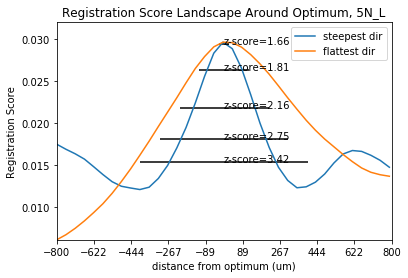

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_5N_R_scoreLandscape.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_5N_R_scoreLandscape.png


Child returned 0
0.43 seconds.


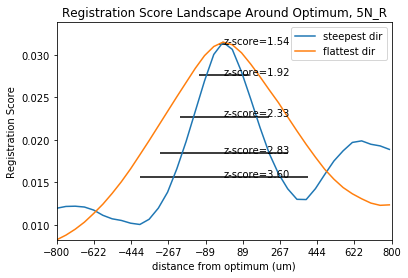

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_6N_L_scoreLandscape.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_6N_L_scoreLandscape.png


Child returned 0
0.38 seconds.


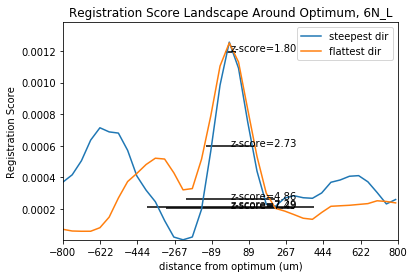

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_6N_R_scoreLandscape.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_6N_R_scoreLandscape.png


Child returned 0
0.37 seconds.


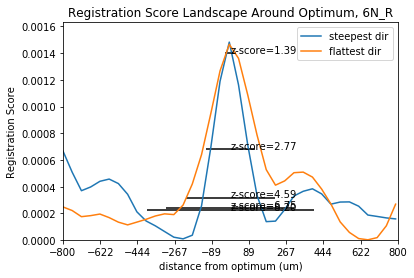

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_7N_L_scoreLandscape.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_7N_L_scoreLandscape.png


Child returned 0
0.43 seconds.


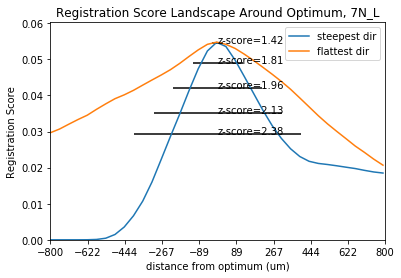

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_7N_R_scoreLandscape.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_7N_R_scoreLandscape.png


Child returned 0
0.43 seconds.


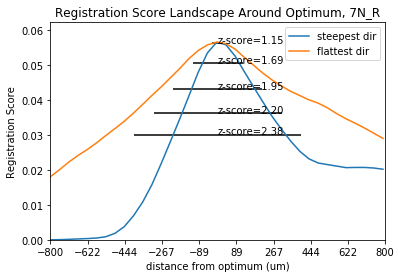

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_7n_L_scoreLandscape.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_7n_L_scoreLandscape.png


Child returned 0
0.42 seconds.


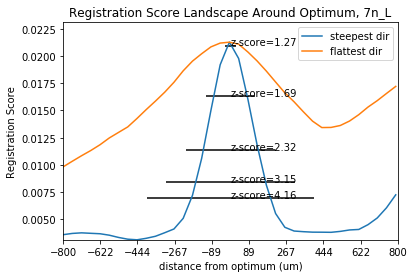

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_7n_R_scoreLandscape.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_7n_R_scoreLandscape.png


Child returned 0
0.48 seconds.


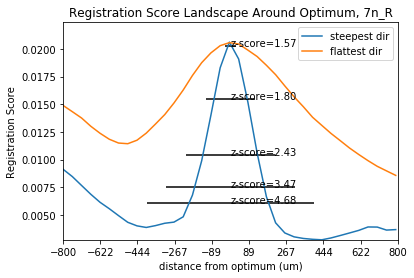

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Amb_L_scoreLandscape.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Amb_L_scoreLandscape.png


Child returned 0
0.38 seconds.


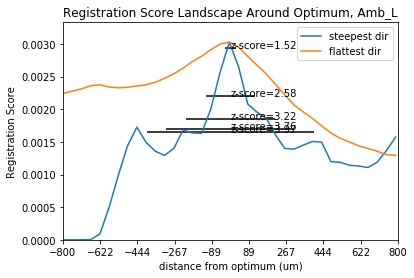

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Amb_R_scoreLandscape.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Amb_R_scoreLandscape.png


Child returned 0
0.38 seconds.


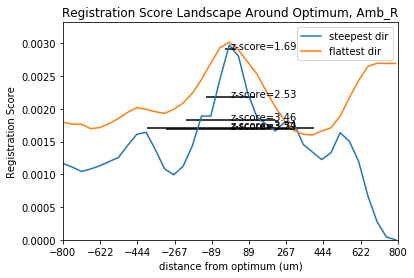

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_LC_L_scoreLandscape.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_LC_L_scoreLandscape.png


Child returned 0
0.37 seconds.


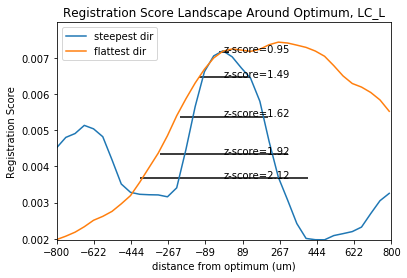

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_LC_R_scoreLandscape.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_LC_R_scoreLandscape.png


Child returned 0
0.37 seconds.


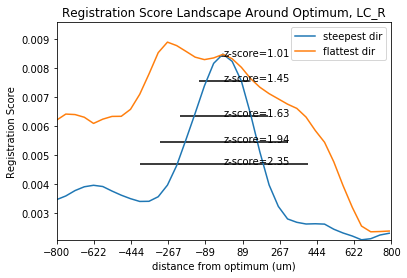

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_LRt_L_scoreLandscape.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_LRt_L_scoreLandscape.png


Child returned 0
0.48 seconds.


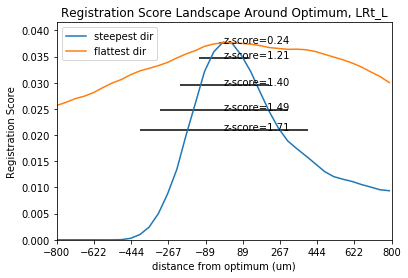

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_LRt_R_scoreLandscape.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_LRt_R_scoreLandscape.png


Child returned 0
0.43 seconds.


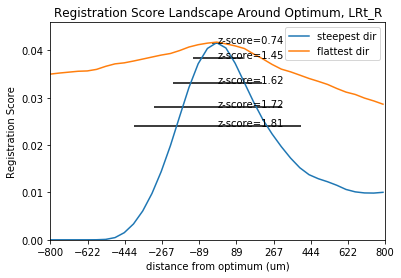

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Pn_L_scoreLandscape.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Pn_L_scoreLandscape.png


Child returned 0
0.42 seconds.


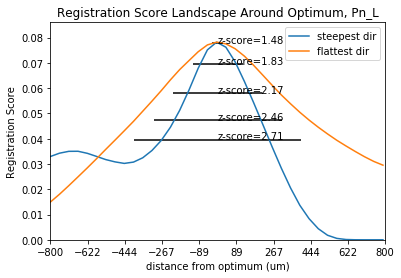

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Pn_R_scoreLandscape.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Pn_R_scoreLandscape.png


Child returned 0
0.42 seconds.


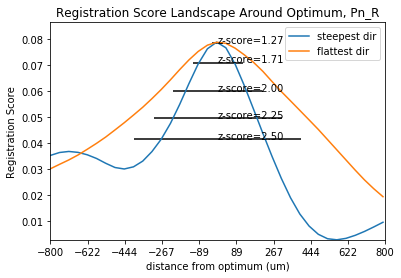

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Tz_L_scoreLandscape.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Tz_L_scoreLandscape.png


Child returned 0
0.38 seconds.


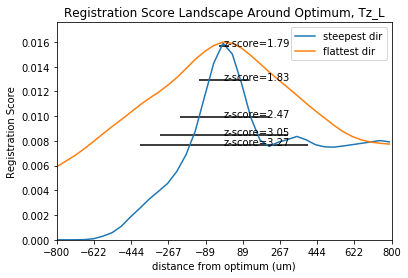

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Tz_R_scoreLandscape.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Tz_R_scoreLandscape.png


Child returned 0
0.38 seconds.


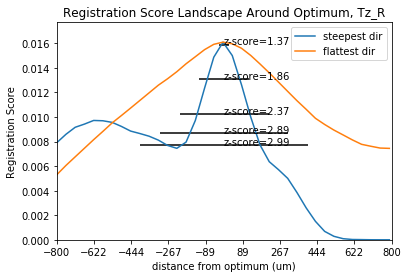

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VLL_L_scoreLandscape.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VLL_L_scoreLandscape.png


Child returned 0
0.42 seconds.


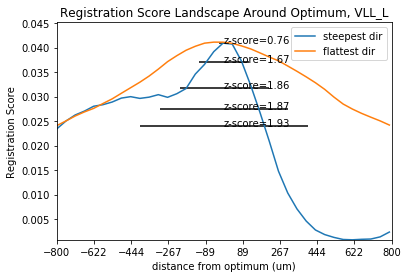

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VLL_R_scoreLandscape.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VLL_R_scoreLandscape.png


Child returned 0
0.42 seconds.


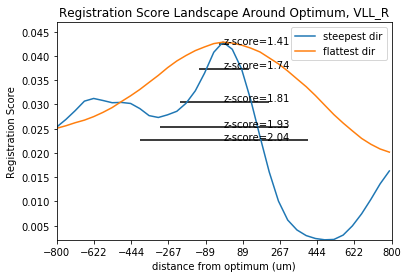

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_RMC_L_scoreLandscape.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_RMC_L_scoreLandscape.png


Child returned 0
0.38 seconds.


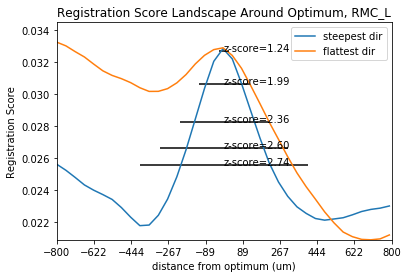

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_RMC_R_scoreLandscape.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_RMC_R_scoreLandscape.png


Child returned 0
0.43 seconds.


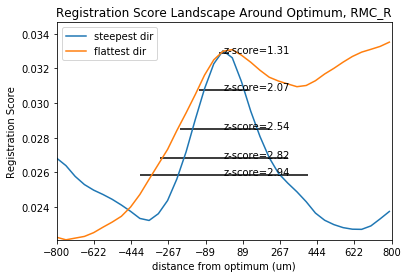

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SNC_L_scoreLandscape.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SNC_L_scoreLandscape.png


Child returned 0
0.37 seconds.


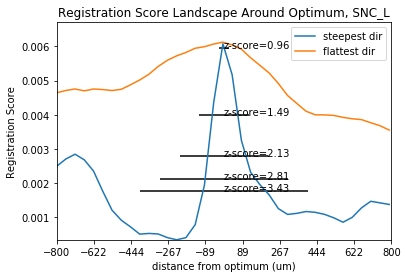

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SNC_R_scoreLandscape.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SNC_R_scoreLandscape.png


Child returned 0
0.42 seconds.


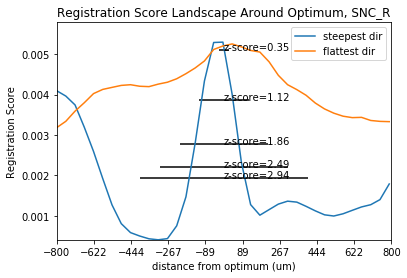

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SNR_L_scoreLandscape.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SNR_L_scoreLandscape.png


Child returned 0
0.42 seconds.


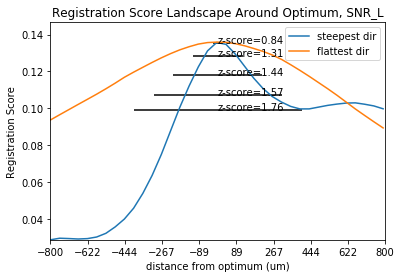

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SNR_R_scoreLandscape.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SNR_R_scoreLandscape.png


Child returned 0
0.37 seconds.


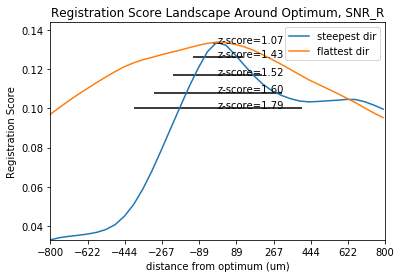

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_3N_L_scoreLandscape.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_3N_L_scoreLandscape.png


Child returned 0
0.43 seconds.


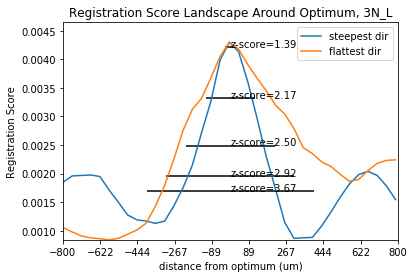

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_3N_R_scoreLandscape.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_3N_R_scoreLandscape.png


Child returned 0
0.42 seconds.


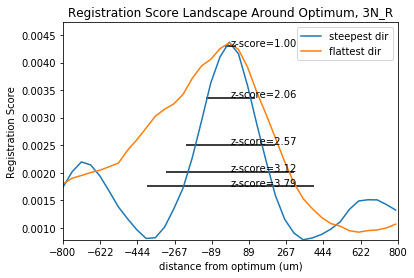

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_4N_L_scoreLandscape.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_4N_L_scoreLandscape.png


Child returned 0
0.42 seconds.


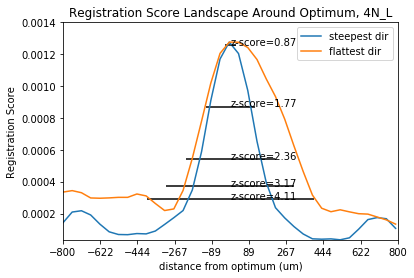

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_4N_R_scoreLandscape.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_4N_R_scoreLandscape.png


Child returned 0
0.42 seconds.


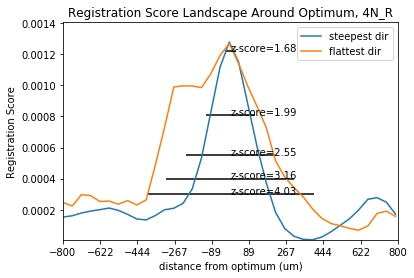

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5I_L_scoreLandscape.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5I_L_scoreLandscape.png


Child returned 0
0.42 seconds.


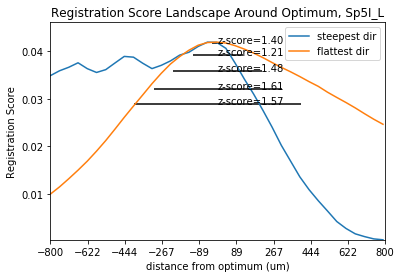

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5I_R_scoreLandscape.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5I_R_scoreLandscape.png


Child returned 0
0.38 seconds.


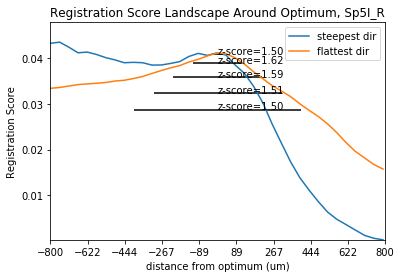

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5O_L_scoreLandscape.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5O_L_scoreLandscape.png


Child returned 0
0.37 seconds.


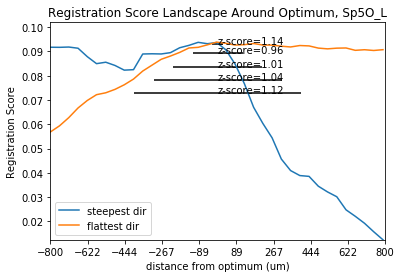

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5O_R_scoreLandscape.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5O_R_scoreLandscape.png


Child returned 0
0.37 seconds.


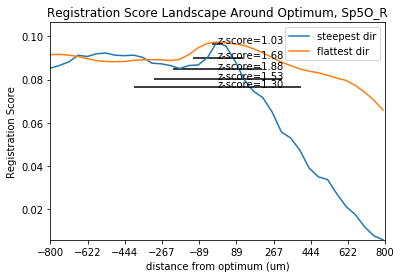

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5C_L_scoreLandscape.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5C_L_scoreLandscape.png


Child returned 0
0.37 seconds.


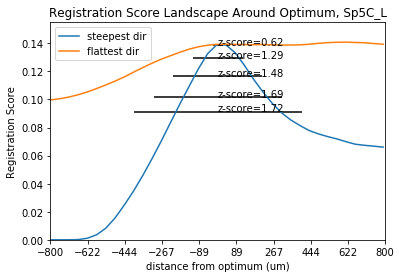

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5C_R_scoreLandscape.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5C_R_scoreLandscape.png


Child returned 0
0.37 seconds.


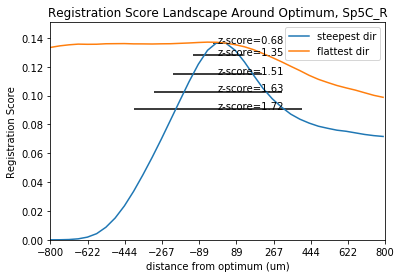

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_PBG_L_scoreLandscape.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_PBG_L_scoreLandscape.png


Child returned 0
0.48 seconds.


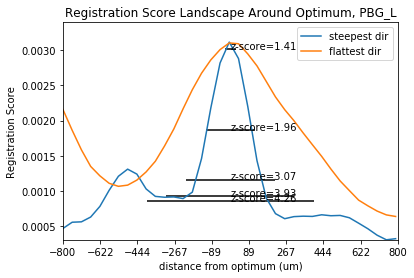

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_PBG_R_scoreLandscape.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_PBG_R_scoreLandscape.png


Child returned 0
0.42 seconds.


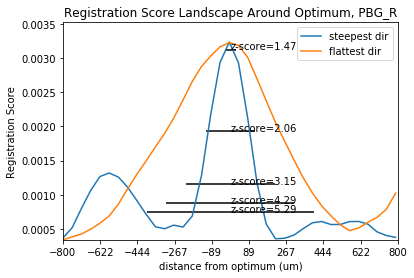

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_10N_L_scoreLandscape.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_10N_L_scoreLandscape.png


Child returned 0
0.42 seconds.


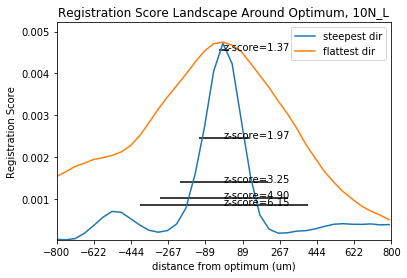

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_10N_R_scoreLandscape.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_10N_R_scoreLandscape.png


Child returned 0
0.38 seconds.


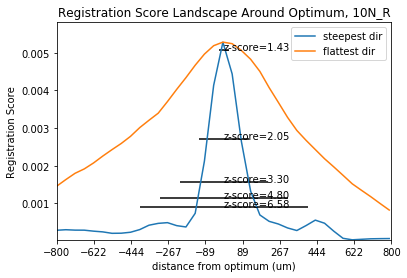

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VCA_L_scoreLandscape.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VCA_L_scoreLandscape.png


Child returned 0
0.43 seconds.


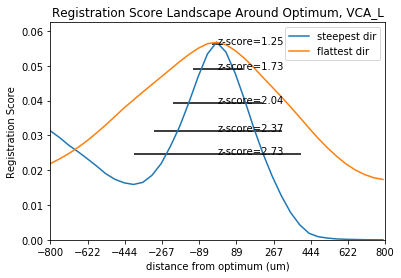

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VCA_R_scoreLandscape.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VCA_R_scoreLandscape.png


Child returned 0
0.37 seconds.


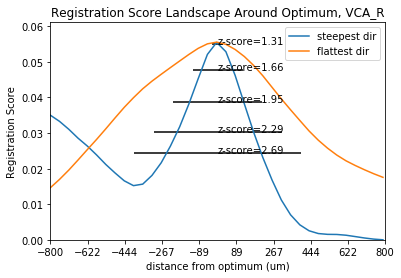

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VCP_L_scoreLandscape.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VCP_L_scoreLandscape.png


Child returned 0
0.48 seconds.


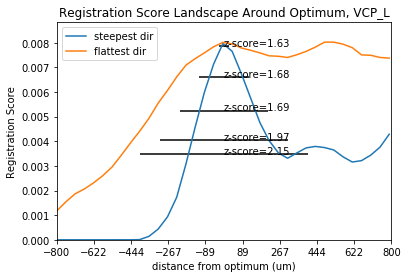

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VCP_R_scoreLandscape.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VCP_R_scoreLandscape.png


Child returned 0
0.38 seconds.


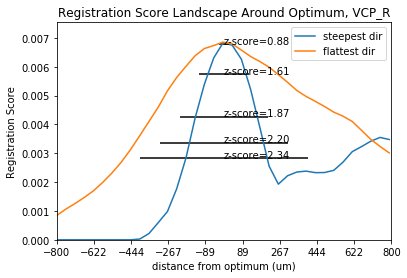

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_DC_L_scoreLandscape.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_DC_L_scoreLandscape.png


Child returned 0
0.43 seconds.


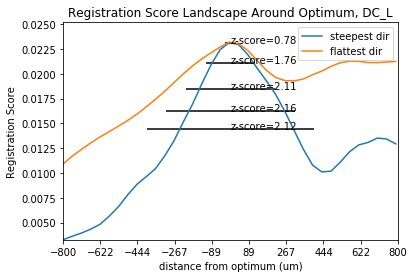

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_DC_R_scoreLandscape.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_DC_R_scoreLandscape.png


Child returned 0
0.37 seconds.


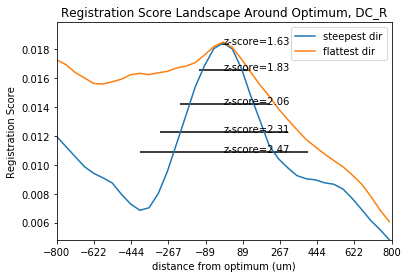

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_AP_scoreLandscape.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_AP_scoreLandscape.png


Child returned 0
0.43 seconds.


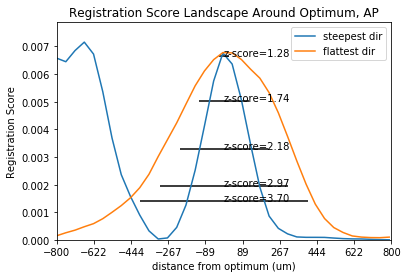

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_12N_scoreLandscape.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_12N_scoreLandscape.png


Child returned 0
0.37 seconds.


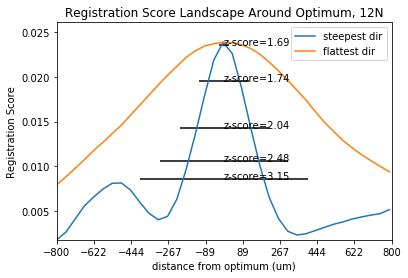

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_RtTg_scoreLandscape.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_RtTg_scoreLandscape.png


Child returned 0
0.44 seconds.


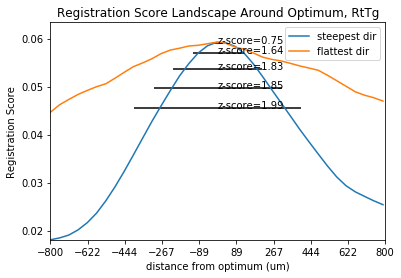

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Child returned 0


rm -rf /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_sp5.bp && mkdir -p /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_sp5.bp /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_sp5.bp


Child returned 1
0.37 seconds.
File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_sp5.bp
Score volume for sp5 does not exist.
Error sp5:list index out of range
File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Child returned 0


rm -rf /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_outerContour.bp && mkdir -p /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_outerContour.bp /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_outerContour.bp


Child returned 1
0.36 seconds.
File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_outerContour.bp
Score volume for outerContour does not exist.
Error outerContour:list index out of range
File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SC_scoreLandscape.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SC_scoreLandscape.png


Child returned 0
0.38 seconds.


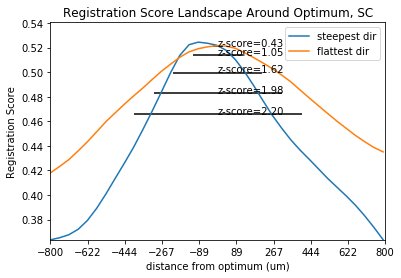

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_IC_scoreLandscape.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscape/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_IC_scoreLandscape.png


Child returned 0
0.38 seconds.


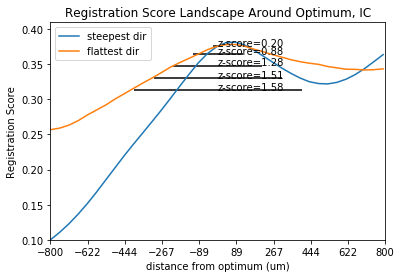

In [112]:
# for structure in ['AP']:
# for structure in ['AP', '7N_L', '5N_R', 'LRt_R', '12N', '10N_L']:
for structure in all_known_structures_sided:
    
    try:

        # Initialize Aligner object

        volume_fixed, structure_to_label_fixed, label_to_structure_fixed = \
            DataManager.load_original_volume_all_known_structures(stack=stack_fixed, 
                                                                  classifier_setting=classifier_setting,
                                                                 sided=False, volume_type='score',
                                                                 structures=[convert_to_original_name(structure)])

        if include_surround:
            volume_moving = DataManager.load_transformed_volume_all_known_structures(stack_m=stack_moving, stack_f=stack_fixed,
                                                                         classifier_setting_m=classifier_setting,
                                                                         classifier_setting_f=classifier_setting,
                                                                         warp_setting=upstream_warp_setting, 
                                                                         structures=[structure, 
                                                                                     convert_to_surround_name(structure, margin='200')])
        else:
            volume_moving = DataManager.load_transformed_volume_all_known_structures(stack_m=stack_moving, stack_f=stack_fixed,
                                                                         classifier_setting_m=classifier_setting,
                                                                         classifier_setting_f=classifier_setting,
                                                                         warp_setting=upstream_warp_setting, 
                                                                         structures=[structure])

        structure_to_label_moving = {s: l+1 for l, s in enumerate(sorted(volume_moving.keys()))}
        label_to_structure_moving = {l+1: s for l, s in enumerate(sorted(volume_moving.keys()))}
        volume_moving = {structure_to_label_moving[s]: v for s, v in volume_moving.items()}

        label_mapping_m2f = {label_m: structure_to_label_fixed[convert_to_original_name(name_m)] 
                             for label_m, name_m in label_to_structure_moving.iteritems()}

        if surround_weight == 'inverse':
            volume_moving_structure_sizes = {l: np.count_nonzero(vol > 0) for l, vol in volume_moving.iteritems()}
            label_weights_m = {label_m: -volume_moving_structure_sizes[structure_to_label_moving[convert_to_nonsurround_name(name_m)]]
                               /float(volume_moving_structure_sizes[label_m])
                               if is_surround_label(name_m) else 1. \
                               for label_m, name_m in label_to_structure_moving.iteritems()}
        elif isinstace(surround_weight, int) or isinstace(surround_weight, float):
            label_weights_m = {label_m: surround_weight if is_surround_label(name_m) else 1. \
                               for label_m, name_m in label_to_structure_moving.iteritems()}
        else:
            sys.stderr.write("surround_weight %s is not recognized. Using the default.\n" % surround_weight)

        aligner = Aligner4(volume_fixed, volume_moving, labelIndexMap_m2f=label_mapping_m2f)

        aligner.set_centroid(centroid_m='structure_centroid', centroid_f='centroid_m', 
                             indices_m=[structure_to_label_moving[structure]])                            

        aligner.set_regularization_weights(reg_weights)
        aligner.set_label_weights(label_weights_m)


        # Compute steepest and flattest directions based on the Hessian matrix.

        # Specify a step size.
        stepsize = hessian_stepsize_list[2]
        H, _ = hessians_all_stacks_all_structures_all_stepsizes[stack_fixed][structure][stepsize]
        U, S, UT = np.linalg.svd(H)
        steepest_direction = U[:,0]
        flattest_direction = U[:,-1]

        # Specify sample points.
        max_pooling_radius_um = 800
        max_pooling_radius_pixel = max_pooling_radius_um / xy_pixel_distance
        grid_size = 3
        waypoints = np.arange(-max_pooling_radius_pixel, max_pooling_radius_pixel, grid_size)
        dxdydzs_steepest_dir = np.outer(waypoints, steepest_direction)
        dxdydzs_flattest_dir = np.outer(waypoints, flattest_direction)

        # Compute a slice of the score function around the optimal estimate, along both the steepest and flattest directions.

        tx_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
                    DataManager.load_alignment_parameters(stack_m=stack_moving, stack_f=stack_fixed,
                                                          classifier_setting_m=classifier_setting,
                                                          classifier_setting_f=classifier_setting,
                                                          warp_setting=warp_setting,
                                                          param_suffix=structure)

        labels_for_computing_confidence = [structure_to_label_moving[structure]]

        neighbor_scores_slice_steepest_dir = aligner.compute_scores_neighborhood_samples(tx_params, dxs=dxdydzs_steepest_dir[:,0], 
                                                                      dys=dxdydzs_steepest_dir[:,1], 
                                                                      dzs=dxdydzs_steepest_dir[:,2],
                                                                   indices_m=labels_for_computing_confidence)

        neighbor_scores_slice_flattest_dir = aligner.compute_scores_neighborhood_samples(tx_params, 
                                                                                         dxs=dxdydzs_flattest_dir[:,0], 
                                                                      dys=dxdydzs_flattest_dir[:,1], 
                                                                      dzs=dxdydzs_flattest_dir[:,2],
                                                                   indices_m=labels_for_computing_confidence)

        # Plot
        plt.figure();

        plt.plot(waypoints * xy_pixel_distance, neighbor_scores_slice_steepest_dir, label='steepest dir')
        plt.plot(waypoints * xy_pixel_distance, neighbor_scores_slice_flattest_dir, label='flattest dir')

        ymin = np.min(np.r_[neighbor_scores_slice_steepest_dir, neighbor_scores_slice_flattest_dir])
        ymax = np.max(np.r_[neighbor_scores_slice_steepest_dir, neighbor_scores_slice_flattest_dir])
        plt.ylim([ymin, ymax+(ymax-ymin)*.1]);
        plt.xlim([-max_pooling_radius_um, max_pooling_radius_um]);
        plt.title('Registration Score Landscape Around Optimum, %s' % structure)
        plt.ylabel('Registration Score');
        plt.xlabel('distance from optimum (um)');
        plt.legend()
        plt.xticks(np.linspace(-max_pooling_radius_um, max_pooling_radius_um, 10));

        for poolradius_um, (z, fmax, mean, std) in zscores_all_stacks_all_structures[stack_fixed][structure].iteritems():
            plt.hlines(mean, -poolradius_um, poolradius_um);
            plt.text(x=0, y=mean, s='z-score=%.2f'%z, fontsize=10);

        
        landscape_plot_fp = DataManager.get_confidence_filepath(stack_m=stack_moving, stack_f=stack_fixed, 
                                               classifier_setting_m=classifier_setting, classifier_setting_f=classifier_setting,
                                               warp_setting=warp_setting,
                                                param_suffix=structure,
                                               what='score_landscape')
        create_parent_dir_if_not_exists(landscape_plot_fp)
        plt.savefig(landscape_plot_fp, bbox_inches='tight')
        upload_to_s3(landscape_plot_fp)
        
        plt.show();
        
    except Exception as e:
        sys.stderr.write('Error %s:' % structure + str(e) + '\n')

- Some score maxima landscapes show horseback shape.
- Flat landscape may be because
    - atlas structure shape being smaller than actual structure.

# Plot structure-wise registration score landscape, changing rotation

In [5]:
# Load all pre-computed z-scores.

zscores_all_stacks_all_structures = defaultdict(dict)

# for stack_fixed in all_nissl_stacks:
for stack_fixed in ['MD635', 'MD642']:

    for structure in all_known_structures_sided:
        try:
            zscores = DataManager.load_confidence(stack_m=stack_moving, stack_f=stack_fixed, 
                                               classifier_setting_m=classifier_setting, classifier_setting_f=classifier_setting,
                                               warp_setting=warp_setting,
                                                param_suffix=structure,
                                               what='zscores_rotations')
            zscores = {float(i): t for i, t in zscores.iteritems()}
            zscores_all_stacks_all_structures[stack_fixed][structure] = zscores
            
        except Exception as e:
            sys.stderr.write('%s\n' % e)
            sys.stderr.write('Error transforming volume %s.\n' % structure)
                
zscores_all_stacks_all_structures.default_factory = None

rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_sp5_zscoresRotations.pkl && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_sp5_zscoresRotations.pkl /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_sp5_zscoresRotations.pkl


Child returned 0
Child returned 1
0.39 seconds.
[Errno 2] No such file or directory: '/shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_sp5_zscoresRotations.pkl'
Error transforming volume sp5.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_outerContour_zscoresRotations.pkl && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_outerContour_zscoresRotations.pkl /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_outerContour_zscoresRotations.pkl


Child returned 1
0.35 seconds.
[Errno 2] No such file or directory: '/shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_outerContour_zscoresRotations.pkl'
Error transforming volume outerContour.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_sp5_zscoresRotations.pkl && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_sp5_zscoresRotations.pkl /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_sp5_zscoresRotations.pkl


Child returned 1
0.34 seconds.
[Errno 2] No such file or directory: '/shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_sp5_zscoresRotations.pkl'
Error transforming volume sp5.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_outerContour_zscoresRotations.pkl && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_outerContour_zscoresRotations.pkl /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_outerContour_zscoresRotations.pkl


Child returned 1
0.34 seconds.
[Errno 2] No such file or directory: '/shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_zscoresRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_outerContour_zscoresRotations.pkl'
Error transforming volume outerContour.


In [6]:
# Load all pre-computed hessians.

hessians_all_stacks_all_structures_all_stepsizes = defaultdict(dict)

# for stack_fixed in all_nissl_stacks:
for stack_fixed in ['MD635', 'MD642']:

    for structure in all_known_structures_sided:
        
        try:
            hessians_all_stepsizes = DataManager.load_confidence(stack_m=stack_moving, stack_f=stack_fixed, 
                                               classifier_setting_m=classifier_setting, classifier_setting_f=classifier_setting,
                                               warp_setting=warp_setting,
                                                param_suffix=structure,
                                               what='hessians_rotations')

            hessians_all_stepsizes = {float(i): t for i, t in hessians_all_stepsizes.iteritems()}
            hessians_all_stacks_all_structures_all_stepsizes[stack_fixed][structure] = hessians_all_stepsizes
            
        except Exception as e:
            sys.stderr.write('%s\n' % e)
            sys.stderr.write('Error transforming volume %s.\n' % structure)
                
hessians_all_stacks_all_structures_all_stepsizes.default_factory = None

Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_sp5_hessiansRotations.pkl && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_sp5_hessiansRotations.pkl /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_sp5_hessiansRotations.pkl


Child returned 1
0.34 seconds.
[Errno 2] No such file or directory: '/shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_sp5_hessiansRotations.pkl'
Error transforming volume sp5.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_outerContour_hessiansRotations.pkl && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_outerContour_hessiansRotations.pkl /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_outerContour_hessiansRotations.pkl


Child returned 1
0.34 seconds.
[Errno 2] No such file or directory: '/shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_outerContour_hessiansRotations.pkl'
Error transforming volume outerContour.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_sp5_hessiansRotations.pkl && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_sp5_hessiansRotations.pkl /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_sp5_hessiansRotations.pkl


Child returned 1
0.35 seconds.
[Errno 2] No such file or directory: '/shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_sp5_hessiansRotations.pkl'
Error transforming volume sp5.
Child returned 0


rm -rf /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_outerContour_hessiansRotations.pkl && mkdir -p /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations
aws s3 cp s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_outerContour_hessiansRotations.pkl /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_outerContour_hessiansRotations.pkl


Child returned 1
0.34 seconds.
[Errno 2] No such file or directory: '/shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_hessiansRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_outerContour_hessiansRotations.pkl'
Error transforming volume outerContour.


In [7]:
stack_fixed = 'MD642'

In [8]:
pool_radius_degrees_list = np.linspace(10, 45, 5)
pool_radius_radian_list = np.deg2rad(pool_radius_degrees_list)

In [9]:
rotation_stepsizes_degrees = np.linspace(5, 40, 5) # angle = 20 degrees
rotation_stepsizes_radians = np.deg2rad(rotation_stepsizes_degrees)

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_5N_L_scoreLandscapeRotations.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_5N_L_scoreLandscapeRotations.png


Child returned 0
0.53 seconds.


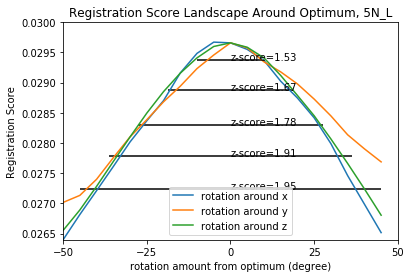

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_5N_R_scoreLandscapeRotations.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_5N_R_scoreLandscapeRotations.png


Child returned 0
0.37 seconds.


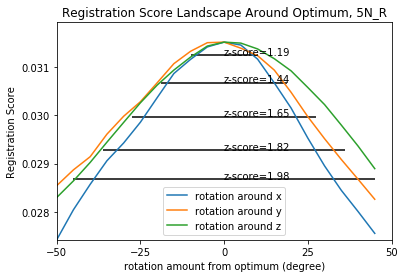

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_6N_L_scoreLandscapeRotations.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_6N_L_scoreLandscapeRotations.png


Child returned 0
0.42 seconds.


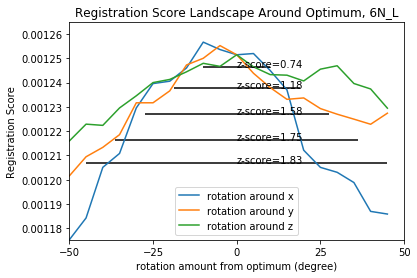

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_6N_R_scoreLandscapeRotations.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_6N_R_scoreLandscapeRotations.png


Child returned 0
0.38 seconds.


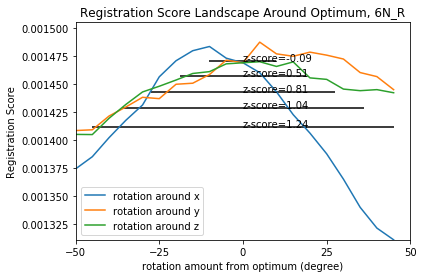

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_7N_L_scoreLandscapeRotations.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_7N_L_scoreLandscapeRotations.png


Child returned 0
0.38 seconds.


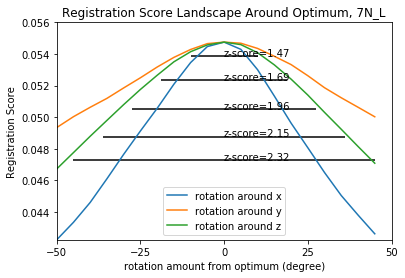

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_7N_R_scoreLandscapeRotations.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_7N_R_scoreLandscapeRotations.png


Child returned 0
0.43 seconds.


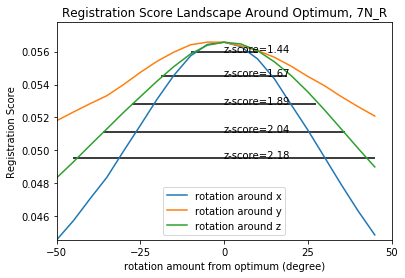

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_7n_L_scoreLandscapeRotations.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_7n_L_scoreLandscapeRotations.png


Child returned 0
0.42 seconds.


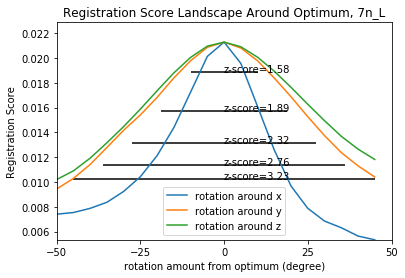

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_7n_R_scoreLandscapeRotations.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_7n_R_scoreLandscapeRotations.png


Child returned 0
0.37 seconds.


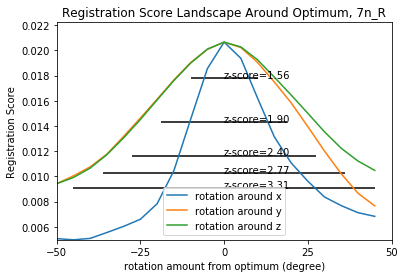

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Amb_L_scoreLandscapeRotations.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Amb_L_scoreLandscapeRotations.png


Child returned 0
0.42 seconds.


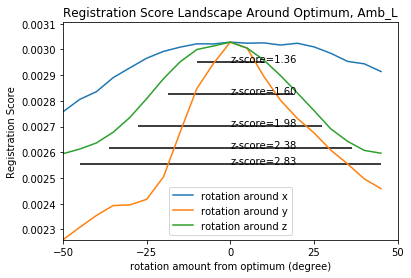

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Amb_R_scoreLandscapeRotations.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Amb_R_scoreLandscapeRotations.png


Child returned 0
0.37 seconds.


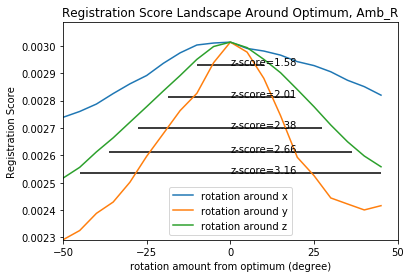

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_LC_L_scoreLandscapeRotations.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_LC_L_scoreLandscapeRotations.png


Child returned 0
0.43 seconds.


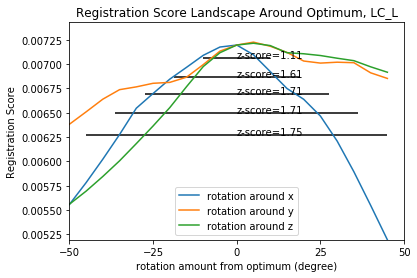

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_LC_R_scoreLandscapeRotations.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_LC_R_scoreLandscapeRotations.png


Child returned 0
0.37 seconds.


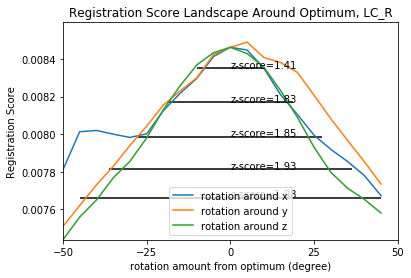

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_LRt_L_scoreLandscapeRotations.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_LRt_L_scoreLandscapeRotations.png


Child returned 0
0.42 seconds.


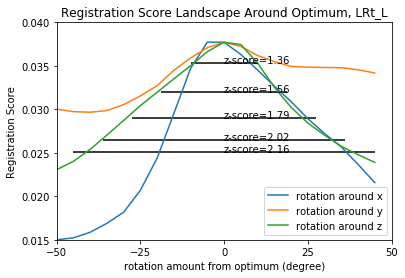

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_LRt_R_scoreLandscapeRotations.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_LRt_R_scoreLandscapeRotations.png


Child returned 0
0.42 seconds.


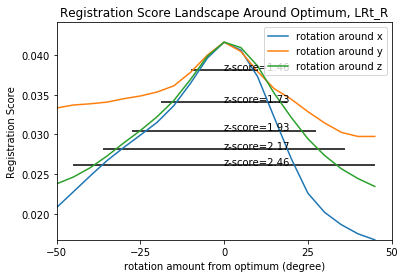

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Pn_L_scoreLandscapeRotations.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Pn_L_scoreLandscapeRotations.png


Child returned 0
0.43 seconds.


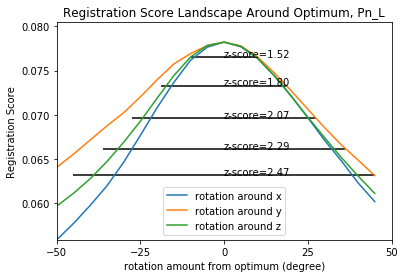

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Pn_R_scoreLandscapeRotations.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Pn_R_scoreLandscapeRotations.png


Child returned 0
0.43 seconds.


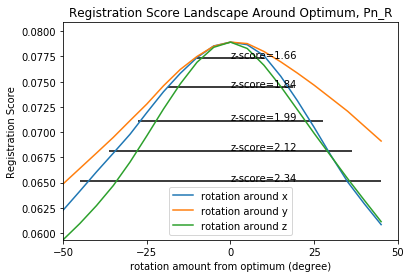

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Tz_L_scoreLandscapeRotations.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Tz_L_scoreLandscapeRotations.png


Child returned 0
0.38 seconds.


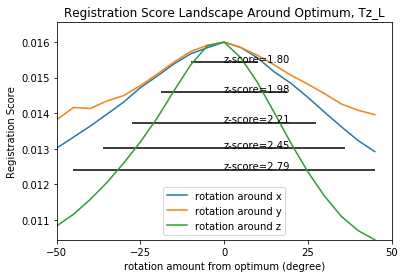

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Tz_R_scoreLandscapeRotations.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Tz_R_scoreLandscapeRotations.png


Child returned 0
0.43 seconds.


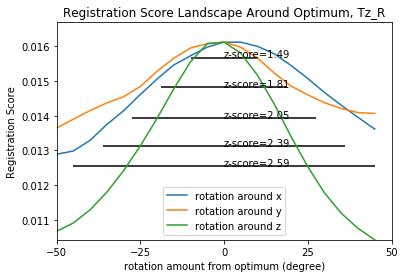

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VLL_L_scoreLandscapeRotations.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VLL_L_scoreLandscapeRotations.png


Child returned 0
0.47 seconds.


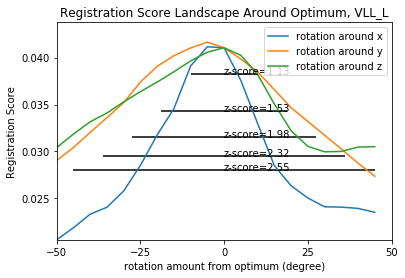

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VLL_R_scoreLandscapeRotations.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VLL_R_scoreLandscapeRotations.png


Child returned 0
0.38 seconds.


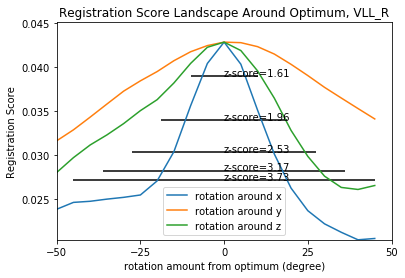

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_RMC_L_scoreLandscapeRotations.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_RMC_L_scoreLandscapeRotations.png


Child returned 0
0.37 seconds.


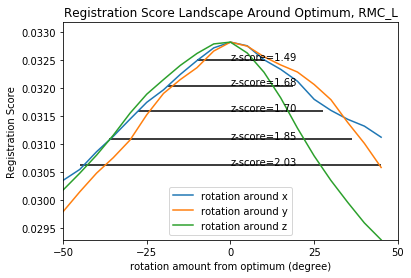

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_RMC_R_scoreLandscapeRotations.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_RMC_R_scoreLandscapeRotations.png


Child returned 0
0.37 seconds.


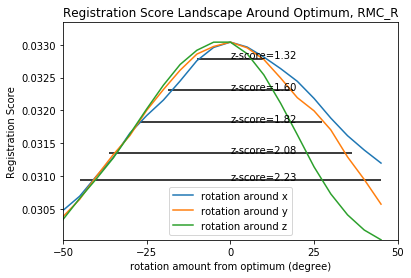

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SNC_L_scoreLandscapeRotations.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SNC_L_scoreLandscapeRotations.png


Child returned 0
0.42 seconds.


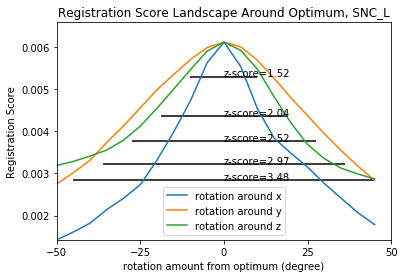

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SNC_R_scoreLandscapeRotations.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SNC_R_scoreLandscapeRotations.png


Child returned 0
0.42 seconds.


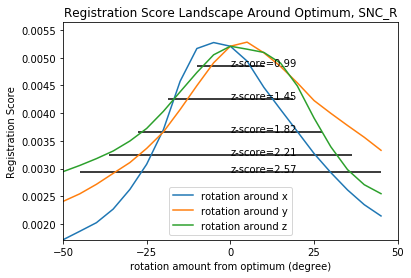

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SNR_L_scoreLandscapeRotations.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SNR_L_scoreLandscapeRotations.png


Child returned 0
0.48 seconds.


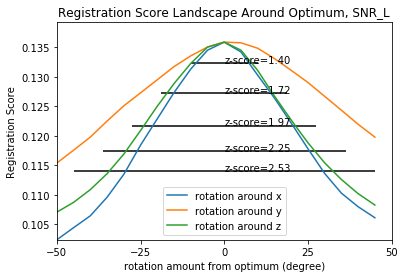

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SNR_R_scoreLandscapeRotations.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SNR_R_scoreLandscapeRotations.png


Child returned 0
0.42 seconds.


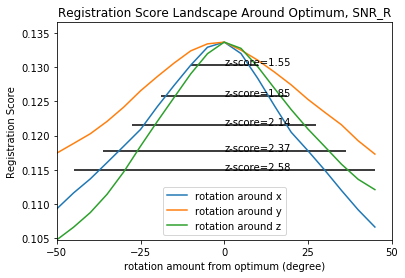

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_3N_L_scoreLandscapeRotations.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_3N_L_scoreLandscapeRotations.png


Child returned 0
0.43 seconds.


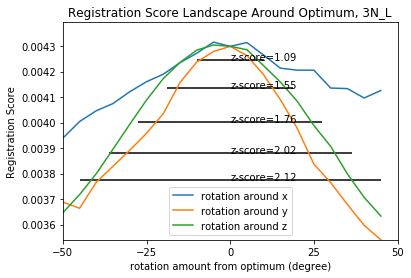

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_3N_R_scoreLandscapeRotations.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_3N_R_scoreLandscapeRotations.png


Child returned 0
0.38 seconds.


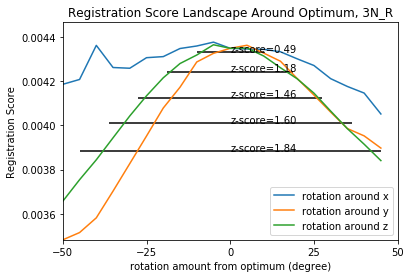

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_4N_L_scoreLandscapeRotations.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_4N_L_scoreLandscapeRotations.png


Child returned 0
0.38 seconds.


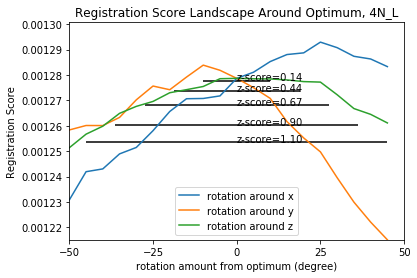

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_4N_R_scoreLandscapeRotations.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_4N_R_scoreLandscapeRotations.png


Child returned 0
0.43 seconds.


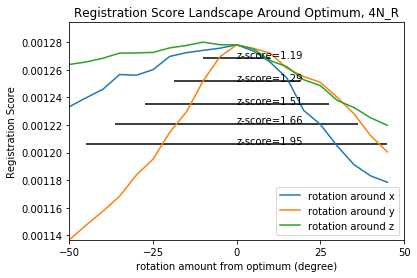

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5I_L_scoreLandscapeRotations.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5I_L_scoreLandscapeRotations.png


Child returned 0
0.42 seconds.


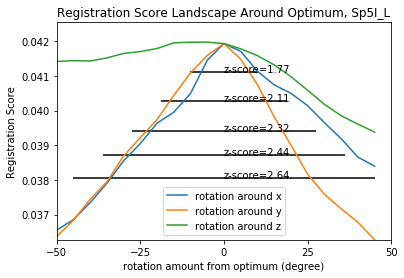

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5I_R_scoreLandscapeRotations.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5I_R_scoreLandscapeRotations.png


Child returned 0
0.42 seconds.


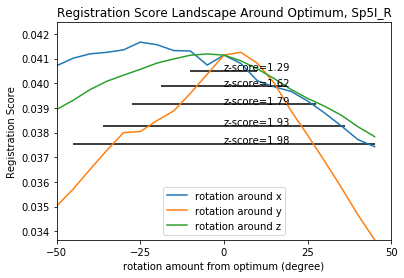

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5O_L_scoreLandscapeRotations.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5O_L_scoreLandscapeRotations.png


Child returned 0
0.37 seconds.


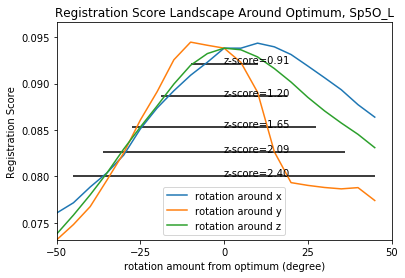

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5O_R_scoreLandscapeRotations.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5O_R_scoreLandscapeRotations.png


Child returned 0
0.37 seconds.


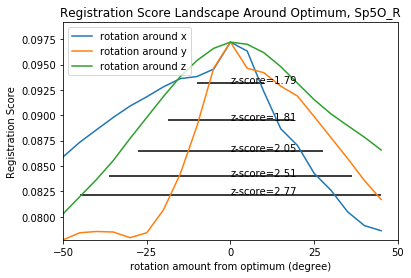

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5C_L_scoreLandscapeRotations.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5C_L_scoreLandscapeRotations.png


Child returned 0
0.37 seconds.


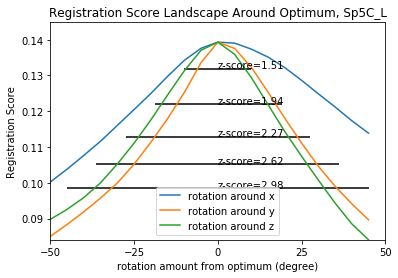

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5C_R_scoreLandscapeRotations.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5C_R_scoreLandscapeRotations.png


Child returned 0
0.37 seconds.


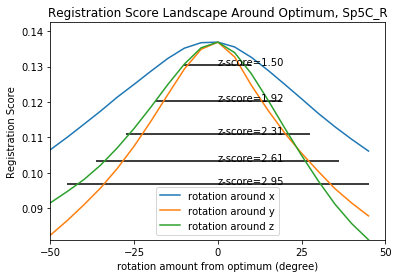

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_PBG_L_scoreLandscapeRotations.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_PBG_L_scoreLandscapeRotations.png


Child returned 0
0.43 seconds.


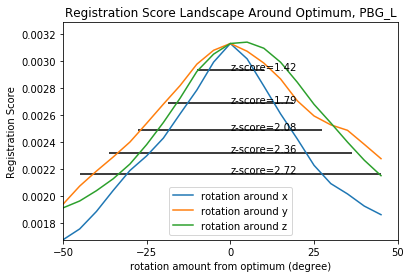

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_PBG_R_scoreLandscapeRotations.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_PBG_R_scoreLandscapeRotations.png


Child returned 0
0.43 seconds.


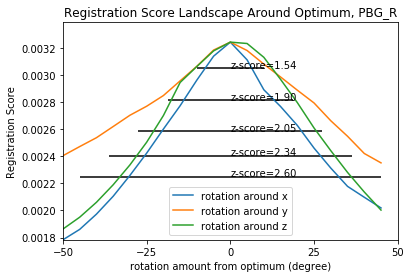

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_10N_L_scoreLandscapeRotations.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_10N_L_scoreLandscapeRotations.png


Child returned 0
0.42 seconds.


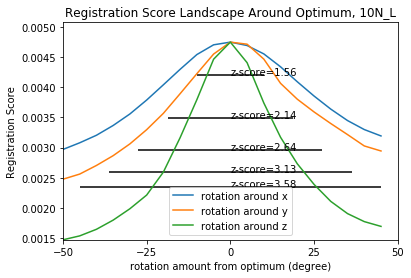

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_10N_R_scoreLandscapeRotations.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_10N_R_scoreLandscapeRotations.png


Child returned 0
0.43 seconds.


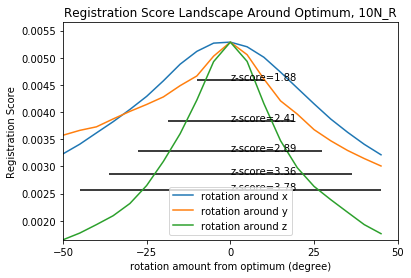

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VCA_L_scoreLandscapeRotations.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VCA_L_scoreLandscapeRotations.png


Child returned 0
0.37 seconds.


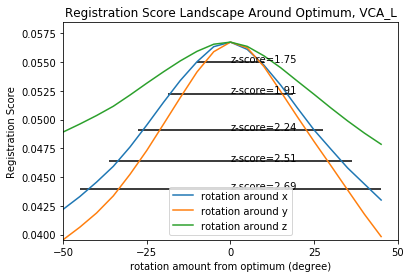

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VCA_R_scoreLandscapeRotations.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VCA_R_scoreLandscapeRotations.png


Child returned 0
0.43 seconds.


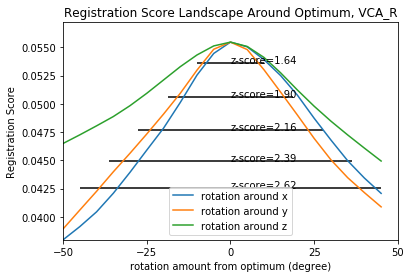

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VCP_L_scoreLandscapeRotations.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VCP_L_scoreLandscapeRotations.png


Child returned 0
0.37 seconds.


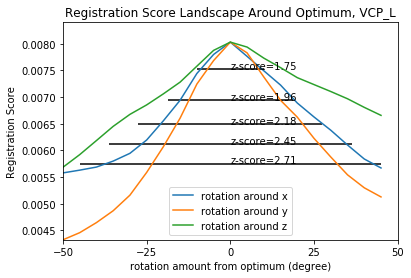

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VCP_R_scoreLandscapeRotations.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VCP_R_scoreLandscapeRotations.png


Child returned 0
0.42 seconds.


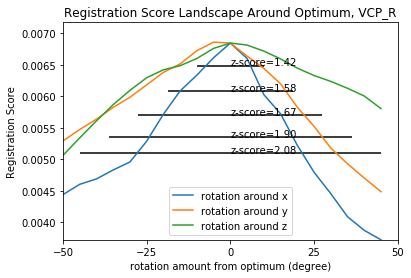

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_DC_L_scoreLandscapeRotations.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_DC_L_scoreLandscapeRotations.png


Child returned 0
0.37 seconds.


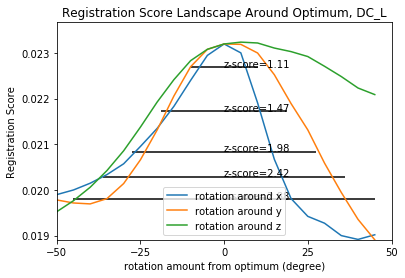

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_DC_R_scoreLandscapeRotations.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_DC_R_scoreLandscapeRotations.png


Child returned 0
0.37 seconds.


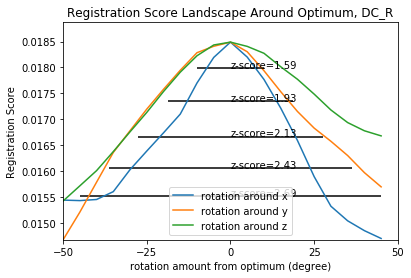

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_AP_scoreLandscapeRotations.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_AP_scoreLandscapeRotations.png


Child returned 0
0.43 seconds.


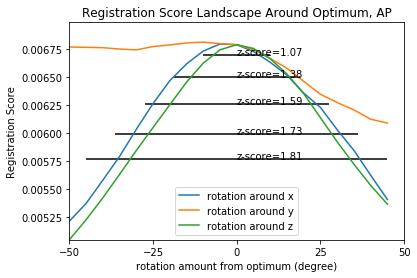

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_12N_scoreLandscapeRotations.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_12N_scoreLandscapeRotations.png


Child returned 0
0.48 seconds.


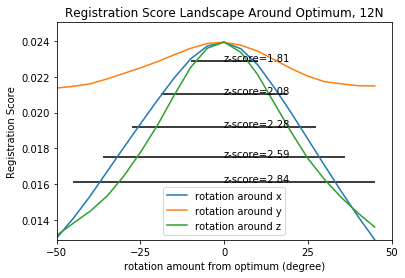

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_RtTg_scoreLandscapeRotations.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_RtTg_scoreLandscapeRotations.png


Child returned 0
0.42 seconds.


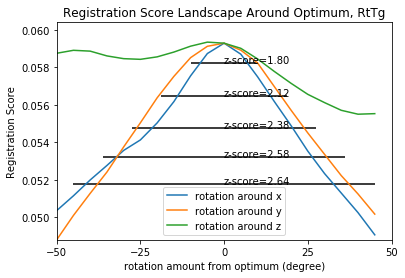

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Child returned 0


rm -rf /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_sp5.bp && mkdir -p /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_sp5.bp /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_sp5.bp


Child returned 1
0.37 seconds.
File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_sp5.bp
Score volume for sp5 does not exist.
Error sp5: list index out of range
File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Child returned 0


rm -rf /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_outerContour.bp && mkdir -p /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes
aws s3 cp s3://mousebrainatlas-data/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_outerContour.bp /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_outerContour.bp


Child returned 1
0.35 seconds.
File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_scoreVolume_clf_37/score_volumes/MD642_down32_scoreVolume_clf_37_outerContour.bp
Score volume for outerContour does not exist.
Error outerContour: list index out of range
File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SC_scoreLandscapeRotations.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SC_scoreLandscapeRotations.png


Child returned 0
0.43 seconds.


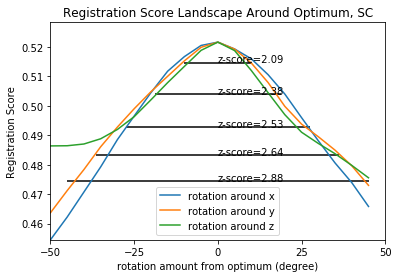

File does not exist: /shared/CSHL_volumes/MD642/MD642_down32_annotationVolume/MD642_down32_annotationVolume_nameToLabel.txt
Prior structure/index map not found. Generating a new one.
Volume shape: (487, 897, 388)
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_IC_scoreLandscapeRotations.png s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_scoreLandscapeRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_IC_scoreLandscapeRotations.png


Child returned 0
0.42 seconds.


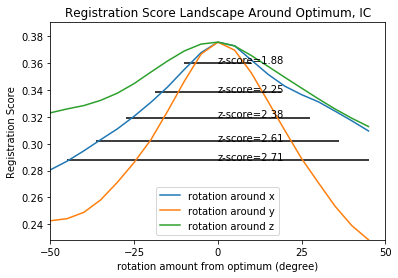

In [20]:
# for structure in ['7N_L']:
# for structure in ['AP', '7N_L', '5N_R', 'LRt_R', '12N', '10N_L']:
for structure in all_known_structures_sided:
    
    try:

        # Initialize Aligner object

        volume_fixed, structure_to_label_fixed, label_to_structure_fixed = \
            DataManager.load_original_volume_all_known_structures(stack=stack_fixed, 
                                                                  classifier_setting=classifier_setting,
                                                                 sided=False, volume_type='score',
                                                                 structures=[convert_to_original_name(structure)])

        if include_surround:
            volume_moving = DataManager.load_transformed_volume_all_known_structures(stack_m=stack_moving, stack_f=stack_fixed,
                                                                         classifier_setting_m=classifier_setting,
                                                                         classifier_setting_f=classifier_setting,
                                                                         warp_setting=upstream_warp_setting, 
                                                                         structures=[structure, 
                                                                                     convert_to_surround_name(structure, margin='200')])
        else:
            volume_moving = DataManager.load_transformed_volume_all_known_structures(stack_m=stack_moving, stack_f=stack_fixed,
                                                                         classifier_setting_m=classifier_setting,
                                                                         classifier_setting_f=classifier_setting,
                                                                         warp_setting=upstream_warp_setting, 
                                                                         structures=[structure])

        structure_to_label_moving = {s: l+1 for l, s in enumerate(sorted(volume_moving.keys()))}
        label_to_structure_moving = {l+1: s for l, s in enumerate(sorted(volume_moving.keys()))}
        volume_moving = {structure_to_label_moving[s]: v for s, v in volume_moving.items()}

        label_mapping_m2f = {label_m: structure_to_label_fixed[convert_to_original_name(name_m)] 
                             for label_m, name_m in label_to_structure_moving.iteritems()}

        if surround_weight == 'inverse':
            volume_moving_structure_sizes = {l: np.count_nonzero(vol > 0) for l, vol in volume_moving.iteritems()}
            label_weights_m = {label_m: -volume_moving_structure_sizes[structure_to_label_moving[convert_to_nonsurround_name(name_m)]]
                               /float(volume_moving_structure_sizes[label_m])
                               if is_surround_label(name_m) else 1. \
                               for label_m, name_m in label_to_structure_moving.iteritems()}
        elif isinstace(surround_weight, int) or isinstace(surround_weight, float):
            label_weights_m = {label_m: surround_weight if is_surround_label(name_m) else 1. \
                               for label_m, name_m in label_to_structure_moving.iteritems()}
        else:
            sys.stderr.write("surround_weight %s is not recognized. Using the default.\n" % surround_weight)

        aligner = Aligner4(volume_fixed, volume_moving, labelIndexMap_m2f=label_mapping_m2f)

        aligner.set_centroid(centroid_m='structure_centroid', centroid_f='centroid_m', 
                             indices_m=[structure_to_label_moving[structure]])                            

        aligner.set_regularization_weights(reg_weights)
        aligner.set_label_weights(label_weights_m)

        #######################################################################################
        # Compute steepest and flattest directions based on the Hessian matrix.

        # Specify a step size.
#         stepsize = rotation_stepsizes_radians[2]
#         H, _ = hessians_all_stacks_all_structures_all_stepsizes[stack_fixed][structure][stepsize]
#         U, S, UT = np.linalg.svd(H)
#         steepest_direction = U[:,0]
#         flattest_direction = U[:,-1]
#         steepest_direction = [1,0,0]
#         flattest_direction = [0,1,0]

        # Specify sample points.
        max_pooling_radius_degree = 50
        max_pooling_radius_rad = np.deg2rad(max_pooling_radius_degree)
        grid_size_degree = 5
        grid_size_rad = np.deg2rad(grid_size_degree)
        waypoints_rad = np.arange(-max_pooling_radius_rad, max_pooling_radius_rad, grid_size_rad)

        # Compute a slice of the score function around the optimal estimate, along both the steepest and flattest directions.

        tx_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
                    DataManager.load_alignment_parameters(stack_m=stack_moving, stack_f=stack_fixed,
                                                          classifier_setting_m=classifier_setting,
                                                          classifier_setting_f=classifier_setting,
                                                          warp_setting=warp_setting,
                                                          param_suffix=structure)

        labels_for_computing_confidence = [structure_to_label_moving[structure]]

        neighbor_scores_slice_rot_around_z = aligner.compute_scores_neighborhood_samples_rotation(tx_params, 
                                                                      dtheta_xys=waypoints_rad,
                                                                   indices_m=labels_for_computing_confidence)
        neighbor_scores_slice_rot_around_x = aligner.compute_scores_neighborhood_samples_rotation(tx_params, 
                                                                      dtheta_yzs=waypoints_rad,
                                                                   indices_m=labels_for_computing_confidence)
        neighbor_scores_slice_rot_around_y = aligner.compute_scores_neighborhood_samples_rotation(tx_params, 
                                                                      dtheta_xzs=waypoints_rad,
                                                                   indices_m=labels_for_computing_confidence)

        # Plot
        plt.figure();

        plt.plot(np.rad2deg(waypoints_rad), neighbor_scores_slice_rot_around_x, label='rotation around x')
        plt.plot(np.rad2deg(waypoints_rad), neighbor_scores_slice_rot_around_y, label='rotation around y')
        plt.plot(np.rad2deg(waypoints_rad), neighbor_scores_slice_rot_around_z, label='rotation around z')

        ymin = np.min(np.r_[neighbor_scores_slice_rot_around_x, neighbor_scores_slice_rot_around_y, neighbor_scores_slice_rot_around_z])
        ymax = np.max(np.r_[neighbor_scores_slice_rot_around_x, neighbor_scores_slice_rot_around_y, neighbor_scores_slice_rot_around_z])
        plt.ylim([ymin, ymax+(ymax-ymin)*.1]);
        plt.xlim([-max_pooling_radius_degree, max_pooling_radius_degree]);
        plt.title('Registration Score Landscape Around Optimum, %s' % structure)
        plt.ylabel('Registration Score');
        plt.xlabel('rotation amount from optimum (degree)');
        plt.legend()
        plt.xticks(np.linspace(-max_pooling_radius_degree, max_pooling_radius_degree, 5));

        for poolradius_rad, (z, fmax, mean, std) in zscores_all_stacks_all_structures[stack_fixed][structure].iteritems():
            plt.hlines(mean, -np.rad2deg(poolradius_rad), np.rad2deg(poolradius_rad));
            plt.text(x=0, y=mean, s='z-score=%.2f'%z, fontsize=10);

        
        landscape_plot_fp = DataManager.get_confidence_filepath(stack_m=stack_moving, stack_f=stack_fixed, 
                                               classifier_setting_m=classifier_setting, classifier_setting_f=classifier_setting,
                                               warp_setting=warp_setting,
                                                param_suffix=structure,
                                               what='score_landscape_rotations')
        create_parent_dir_if_not_exists(landscape_plot_fp)
        plt.savefig(landscape_plot_fp, bbox_inches='tight')
        upload_to_s3(landscape_plot_fp)
        
        plt.show();
        
    except Exception as e:
        sys.stderr.write('Error %s: %s\n' % (structure, str(e)))

# Compute Peak Radius for all structures in all stacks

In [113]:
stack_moving = 'atlasV3'

In [114]:
classifier_setting = 37
warp_setting = 8

In [115]:
downscale = 32
xy_pixel_distance = XY_PIXEL_DISTANCE_LOSSLESS * downscale

In [117]:
peak_radius_all_stacks_all_structures = defaultdict(dict)

# for stack_fixed in all_nissl_stacks:
for stack_fixed in ['MD635', 'MD642']:

    for structure in all_known_structures_sided:
        try:
            
            # Compute peak radius using hessian and z-score.

            peak_radius = defaultdict(dict)
            for poolradius_um, (zscore, fmax, mu, std) in zscores_all_stacks_all_structures[stack_fixed][structure].iteritems():
                for stepsize_um, (H, fmax) in hessians_all_stacks_all_structures_all_stepsizes[stack_fixed][structure].iteritems():
                    if poolradius_um > stepsize_um * 1:  # compute only if pooling radius is at least twice the step size
                        U, S, UT = np.linalg.svd(H)

                        # using the smallest eigenvalues of Hessians (flattest direction), drop to mean
                        peak_radius_pixel_max = np.sqrt(2*(fmax-mu)/S[-1])

                        # using the largest eigenvalues of Hessians (steepest direction), drop to mean
                        peak_radius_pixel_min = np.sqrt(2*(fmax-mu)/S[0])

                        # using the largest eigenvalues of Hessians, drop to 2-sigma
                        peak_radius_pixel_2sigma = np.sqrt(2*(fmax-(mu+2*std))/S[0])

                        peak_radius[poolradius_um][stepsize_um] = (peak_radius_pixel_max * xy_pixel_distance,
                                                                  peak_radius_pixel_min * xy_pixel_distance,
                                                                  peak_radius_pixel_2sigma * xy_pixel_distance)
            peak_radius.default_factory = None
            
            peak_radius_fp = DataManager.get_confidence_filepath(stack_m=stack_moving, stack_f=stack_fixed, 
                                                           classifier_setting_m=classifier_setting, classifier_setting_f=classifier_setting,
                                                           warp_setting=warp_setting,
                                                            param_suffix=structure,
                                                           what='peak_radius')
            create_parent_dir_if_not_exists(peak_radius_fp)
            save_pickle(peak_radius, peak_radius_fp)
            upload_to_s3(peak_radius_fp)
            
            peak_radius_all_stacks_all_structures[stack_fixed][structure] = peak_radius

        except Exception as e:
            sys.stderr.write('Error %s:' % structure + str(e) + '\n')
                
peak_radius_all_stacks_all_structures.default_factory = None

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in sqrt


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_5N_L_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_5N_L_peakRadius.pkl


Child returned 0
0.43 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_5N_R_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_5N_R_peakRadius.pkl


Child returned 0
0.38 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_6N_L_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_6N_L_peakRadius.pkl


Child returned 0
0.43 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_6N_R_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_6N_R_peakRadius.pkl


Child returned 0
0.38 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_7N_L_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_7N_L_peakRadius.pkl


Child returned 0
0.38 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_7N_R_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_7N_R_peakRadius.pkl


Child returned 0
0.38 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_7n_L_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_7n_L_peakRadius.pkl


Child returned 0
0.38 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_7n_R_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_7n_R_peakRadius.pkl


Child returned 0
0.38 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Amb_L_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Amb_L_peakRadius.pkl


Child returned 0
0.43 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Amb_R_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Amb_R_peakRadius.pkl


Child returned 0
0.37 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_LC_L_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_LC_L_peakRadius.pkl


Child returned 0
0.38 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_LC_R_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_LC_R_peakRadius.pkl


Child returned 0
0.37 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_LRt_L_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_LRt_L_peakRadius.pkl


Child returned 0
0.38 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_LRt_R_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_LRt_R_peakRadius.pkl


Child returned 0
0.37 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Pn_L_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Pn_L_peakRadius.pkl


Child returned 0
0.38 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Pn_R_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Pn_R_peakRadius.pkl


Child returned 0
0.38 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Tz_L_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Tz_L_peakRadius.pkl


Child returned 0
0.38 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Tz_R_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Tz_R_peakRadius.pkl


Child returned 0
0.43 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VLL_L_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VLL_L_peakRadius.pkl


Child returned 0
0.38 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VLL_R_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VLL_R_peakRadius.pkl


Child returned 0
0.38 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_RMC_L_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_RMC_L_peakRadius.pkl


Child returned 0
0.37 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_RMC_R_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_RMC_R_peakRadius.pkl


Child returned 0
0.38 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SNC_L_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SNC_L_peakRadius.pkl


Child returned 0
0.38 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SNC_R_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SNC_R_peakRadius.pkl


Child returned 0
0.38 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SNR_L_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SNR_L_peakRadius.pkl


Child returned 0
0.38 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SNR_R_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SNR_R_peakRadius.pkl


Child returned 0
0.38 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_3N_L_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_3N_L_peakRadius.pkl


Child returned 0
0.43 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_3N_R_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_3N_R_peakRadius.pkl


Child returned 0
0.38 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_4N_L_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_4N_L_peakRadius.pkl


Child returned 0
0.38 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_4N_R_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_4N_R_peakRadius.pkl


Child returned 0
0.43 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5I_L_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5I_L_peakRadius.pkl


Child returned 0
0.43 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5I_R_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5I_R_peakRadius.pkl


Child returned 0
0.42 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5O_L_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5O_L_peakRadius.pkl


Child returned 0
0.38 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5O_R_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5O_R_peakRadius.pkl


Child returned 0
0.37 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5C_L_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5C_L_peakRadius.pkl


Child returned 0
0.43 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5C_R_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5C_R_peakRadius.pkl


Child returned 0
0.38 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_PBG_L_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_PBG_L_peakRadius.pkl


Child returned 0
0.37 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_PBG_R_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_PBG_R_peakRadius.pkl


Child returned 0
0.38 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_10N_L_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_10N_L_peakRadius.pkl


Child returned 0
0.48 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_10N_R_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_10N_R_peakRadius.pkl


Child returned 0
0.43 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VCA_L_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VCA_L_peakRadius.pkl


Child returned 0
0.38 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VCA_R_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VCA_R_peakRadius.pkl


Child returned 0
0.38 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VCP_L_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VCP_L_peakRadius.pkl


Child returned 0
0.38 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VCP_R_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VCP_R_peakRadius.pkl


Child returned 0
0.38 seconds.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_DC_L_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_DC_L_peakRadius.pkl


Child returned 0
0.37 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_DC_R_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_DC_R_peakRadius.pkl


Child returned 0
0.37 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_AP_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_AP_peakRadius.pkl


Child returned 0
0.42 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_12N_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_12N_peakRadius.pkl


Child returned 0
0.38 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_RtTg_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_RtTg_peakRadius.pkl


Child returned 0
0.38 seconds.
Error sp5:'sp5'
Error outerContour:'outerContour'


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SC_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SC_peakRadius.pkl


Child returned 0
0.43 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_IC_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_IC_peakRadius.pkl


Child returned 0
0.48 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_5N_L_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_5N_L_peakRadius.pkl


Child returned 0
0.38 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_5N_R_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_5N_R_peakRadius.pkl


Child returned 0
0.38 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_6N_L_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_6N_L_peakRadius.pkl


Child returned 0
0.43 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_6N_R_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_6N_R_peakRadius.pkl


Child returned 0
0.43 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_7N_L_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_7N_L_peakRadius.pkl


Child returned 0
0.38 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_7N_R_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_7N_R_peakRadius.pkl


Child returned 0
0.37 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_7n_L_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_7n_L_peakRadius.pkl


Child returned 0
0.38 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_7n_R_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_7n_R_peakRadius.pkl


Child returned 0
0.38 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Amb_L_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Amb_L_peakRadius.pkl


Child returned 0
0.38 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Amb_R_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Amb_R_peakRadius.pkl


Child returned 0
0.38 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_LC_L_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_LC_L_peakRadius.pkl


Child returned 0
0.38 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_LC_R_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_LC_R_peakRadius.pkl


Child returned 0
0.43 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_LRt_L_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_LRt_L_peakRadius.pkl


Child returned 0
0.38 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_LRt_R_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_LRt_R_peakRadius.pkl


Child returned 0
0.38 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Pn_L_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Pn_L_peakRadius.pkl


Child returned 0
0.38 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Pn_R_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Pn_R_peakRadius.pkl


Child returned 0
0.43 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Tz_L_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Tz_L_peakRadius.pkl


Child returned 0
0.38 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Tz_R_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Tz_R_peakRadius.pkl


Child returned 0
0.38 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VLL_L_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VLL_L_peakRadius.pkl


Child returned 0
0.37 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VLL_R_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VLL_R_peakRadius.pkl


Child returned 0
0.38 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_RMC_L_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_RMC_L_peakRadius.pkl


Child returned 0
0.38 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_RMC_R_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_RMC_R_peakRadius.pkl


Child returned 0
0.43 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SNC_L_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SNC_L_peakRadius.pkl


Child returned 0
0.38 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SNC_R_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SNC_R_peakRadius.pkl


Child returned 0
0.38 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SNR_L_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SNR_L_peakRadius.pkl


Child returned 0
0.38 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SNR_R_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SNR_R_peakRadius.pkl


Child returned 0
0.43 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_3N_L_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_3N_L_peakRadius.pkl


Child returned 0
0.38 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_3N_R_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_3N_R_peakRadius.pkl


Child returned 0
0.37 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_4N_L_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_4N_L_peakRadius.pkl


Child returned 0
0.43 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_4N_R_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_4N_R_peakRadius.pkl


Child returned 0
0.37 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5I_L_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5I_L_peakRadius.pkl


Child returned 0
0.58 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5I_R_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5I_R_peakRadius.pkl


Child returned 0
0.43 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5O_L_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5O_L_peakRadius.pkl


Child returned 0
0.38 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5O_R_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5O_R_peakRadius.pkl


Child returned 0
0.38 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5C_L_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5C_L_peakRadius.pkl


Child returned 0
0.38 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5C_R_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5C_R_peakRadius.pkl


Child returned 0
0.38 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_PBG_L_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_PBG_L_peakRadius.pkl


Child returned 0
0.38 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_PBG_R_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_PBG_R_peakRadius.pkl


Child returned 0
0.38 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_10N_L_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_10N_L_peakRadius.pkl


Child returned 0
0.38 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_10N_R_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_10N_R_peakRadius.pkl


Child returned 0
0.38 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VCA_L_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VCA_L_peakRadius.pkl


Child returned 0
0.38 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VCA_R_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VCA_R_peakRadius.pkl


Child returned 0
0.38 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VCP_L_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VCP_L_peakRadius.pkl


Child returned 0
0.38 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VCP_R_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VCP_R_peakRadius.pkl


Child returned 0
0.38 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_DC_L_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_DC_L_peakRadius.pkl


Child returned 0
0.37 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_DC_R_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_DC_R_peakRadius.pkl


Child returned 0
0.37 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_AP_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_AP_peakRadius.pkl


Child returned 0
0.38 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_12N_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_12N_peakRadius.pkl


Child returned 0
0.43 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_RtTg_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_RtTg_peakRadius.pkl


Child returned 0
0.43 seconds.
Error sp5:'sp5'
Error outerContour:'outerContour'


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SC_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SC_peakRadius.pkl


Child returned 0
0.37 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_IC_peakRadius.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadius/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_IC_peakRadius.pkl


Child returned 0
0.38 seconds.


In [31]:
pooling_radius_list = sorted(zscores.keys())
print 'pooling radius:', pooling_radius_list
hessian_stepsize_list = sorted(hessians_all_stepsizes.keys())
print 'hessian stepsize:', hessian_stepsize_list

pooling radius: [25.0, 118.75, 212.5, 306.25, 400.0]
hessian stepsize: [14.72, 84.64, 154.56, 224.48000000000002, 294.40000000000003]


# Compute Peak Radius for all structures in all stacks, for rotation

In [73]:
peak_radius_rad_all_stacks_all_structures = defaultdict(dict)

# for stack_fixed in all_nissl_stacks:
for stack_fixed in ['MD635', 'MD642']:
# for stack_fixed in ['MD635']:

    for structure in all_known_structures_sided:
#     for structure in ['7N_R']:
        try:
            
            # Compute peak radius using hessian and z-score.

            peak_radius_rad = defaultdict(dict)
            for poolradius_rad, (zscore, fmax, mu, std) in zscores_all_stacks_all_structures[stack_fixed][structure].iteritems():
                for stepsize_rad, (H, fmax) in hessians_all_stacks_all_structures_all_stepsizes[stack_fixed][structure].iteritems():
                    if poolradius_rad > stepsize_rad * 1:  # compute only if pooling radius is at least twice the step size
#                         U, S, UT = np.linalg.svd(H)
                        S_theta_xy = -H[2,2]
                        S_theta_yz = -H[0,0]
                        S_theta_xz = -H[1,1]

                        # using the smallest eigenvalues of Hessians (flattest direction), drop to mean
                        peak_radius_rad_theta_xy = np.sqrt(2*(fmax-mu)/S_theta_xy)
                        peak_radius_rad_theta_yz = np.sqrt(2*(fmax-mu)/S_theta_yz)
                        peak_radius_rad_theta_xz = np.sqrt(2*(fmax-mu)/S_theta_xz)

#                         # using the diagonal elements of Hessians, drop to 2-sigma
#                         peak_radius_rad_theta_xy_2sigma = np.sqrt(2*(fmax-(mu+2*std))/S_theta_xy)
#                         peak_radius_rad_theta_yz_2sigma = np.sqrt(2*(fmax-(mu+2*std))/S_theta_yz)
#                         peak_radius_rad_theta_xz_2sigma = np.sqrt(2*(fmax-(mu+2*std))/S_theta_xz)

                        peak_radius_rad[poolradius_rad][stepsize_rad] = (peak_radius_rad_theta_xy,
                                                                      peak_radius_rad_theta_yz,
                                                                      peak_radius_rad_theta_xz)
#                                                                       peak_radius_rad_theta_xy_2sigma,
#                                                                       peak_radius_rad_theta_yz_2sigma,
#                                                                       peak_radius_rad_theta_xz_2sigma)
            peak_radius_rad.default_factory = None
            
            peak_radius_fp = DataManager.get_confidence_filepath(stack_m=stack_moving, stack_f=stack_fixed, 
                                                           classifier_setting_m=classifier_setting, classifier_setting_f=classifier_setting,
                                                           warp_setting=warp_setting,
                                                            param_suffix=structure,
                                                           what='peak_radius_rotations')
            create_parent_dir_if_not_exists(peak_radius_fp)
            save_pickle(peak_radius_rad, peak_radius_fp)
            upload_to_s3(peak_radius_fp)
            
            peak_radius_rad_all_stacks_all_structures[stack_fixed][structure] = peak_radius_rad

        except Exception as e:
            sys.stderr.write('Error %s: %s.\n' % (structure, str(e)))
                
peak_radius_rad_all_stacks_all_structures.default_factory = None

aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_5N_L_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_5N_L_peakRadiusRotations.pkl


Child returned 0
0.43 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_5N_R_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_5N_R_peakRadiusRotations.pkl


Child returned 0
0.38 seconds.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in sqrt


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_6N_L_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_6N_L_peakRadiusRotations.pkl


Child returned 0
0.42 seconds.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in sqrt


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_6N_R_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_6N_R_peakRadiusRotations.pkl


Child returned 0
0.38 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_7N_L_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_7N_L_peakRadiusRotations.pkl


Child returned 0
0.42 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_7N_R_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_7N_R_peakRadiusRotations.pkl


Child returned 0
0.38 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_7n_L_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_7n_L_peakRadiusRotations.pkl


Child returned 0
0.38 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_7n_R_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_7n_R_peakRadiusRotations.pkl


Child returned 0
0.37 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Amb_L_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Amb_L_peakRadiusRotations.pkl


Child returned 0
0.37 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Amb_R_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Amb_R_peakRadiusRotations.pkl


Child returned 0
0.43 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_LC_L_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_LC_L_peakRadiusRotations.pkl


Child returned 0
0.37 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_LC_R_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_LC_R_peakRadiusRotations.pkl


Child returned 0
0.38 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_LRt_L_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_LRt_L_peakRadiusRotations.pkl


Child returned 0
0.42 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_LRt_R_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_LRt_R_peakRadiusRotations.pkl


Child returned 0
0.38 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Pn_L_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Pn_L_peakRadiusRotations.pkl


Child returned 0
0.37 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Pn_R_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Pn_R_peakRadiusRotations.pkl


Child returned 0
0.43 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Tz_L_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Tz_L_peakRadiusRotations.pkl


Child returned 0
0.42 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Tz_R_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Tz_R_peakRadiusRotations.pkl


Child returned 0
0.38 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VLL_L_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VLL_L_peakRadiusRotations.pkl


Child returned 0
0.37 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VLL_R_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VLL_R_peakRadiusRotations.pkl


Child returned 0
0.37 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_RMC_L_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_RMC_L_peakRadiusRotations.pkl


Child returned 0
0.38 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_RMC_R_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_RMC_R_peakRadiusRotations.pkl


Child returned 0
0.39 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SNC_L_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SNC_L_peakRadiusRotations.pkl


Child returned 0
0.43 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SNC_R_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SNC_R_peakRadiusRotations.pkl


Child returned 0
0.39 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SNR_L_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SNR_L_peakRadiusRotations.pkl


Child returned 0
0.37 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SNR_R_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SNR_R_peakRadiusRotations.pkl


Child returned 0
0.42 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_3N_L_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_3N_L_peakRadiusRotations.pkl


Child returned 0
0.38 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_3N_R_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_3N_R_peakRadiusRotations.pkl


Child returned 0
0.37 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_4N_L_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_4N_L_peakRadiusRotations.pkl


Child returned 0
0.37 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_4N_R_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_4N_R_peakRadiusRotations.pkl


Child returned 0
0.42 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5I_L_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5I_L_peakRadiusRotations.pkl


Child returned 0
0.38 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5I_R_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5I_R_peakRadiusRotations.pkl


Child returned 0
0.42 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5O_L_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5O_L_peakRadiusRotations.pkl


Child returned 0
0.38 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5O_R_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5O_R_peakRadiusRotations.pkl


Child returned 0
0.38 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5C_L_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5C_L_peakRadiusRotations.pkl


Child returned 0
0.37 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5C_R_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_Sp5C_R_peakRadiusRotations.pkl


Child returned 0
0.38 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_PBG_L_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_PBG_L_peakRadiusRotations.pkl


Child returned 0
0.38 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_PBG_R_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_PBG_R_peakRadiusRotations.pkl


Child returned 0
0.37 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_10N_L_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_10N_L_peakRadiusRotations.pkl


Child returned 0
0.37 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_10N_R_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_10N_R_peakRadiusRotations.pkl


Child returned 0
0.37 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VCA_L_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VCA_L_peakRadiusRotations.pkl


Child returned 0
0.37 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VCA_R_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VCA_R_peakRadiusRotations.pkl


Child returned 0
0.37 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VCP_L_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VCP_L_peakRadiusRotations.pkl


Child returned 0
0.38 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VCP_R_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_VCP_R_peakRadiusRotations.pkl


Child returned 0
0.37 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_DC_L_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_DC_L_peakRadiusRotations.pkl


Child returned 0
0.37 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_DC_R_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_DC_R_peakRadiusRotations.pkl


Child returned 0
0.37 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_AP_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_AP_peakRadiusRotations.pkl


Child returned 0
0.37 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_12N_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_12N_peakRadiusRotations.pkl


Child returned 0
1.03 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_RtTg_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_RtTg_peakRadiusRotations.pkl


Child returned 0
0.37 seconds.
Error sp5: 'sp5'.
Error outerContour: 'outerContour'.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SC_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_SC_peakRadiusRotations.pkl


Child returned 0
0.37 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_IC_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD635_down32_scoreVolume_clf_37_parameters_IC_peakRadiusRotations.pkl


Child returned 0
0.37 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_5N_L_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_5N_L_peakRadiusRotations.pkl


Child returned 0
0.37 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_5N_R_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_5N_R_peakRadiusRotations.pkl


Child returned 0
0.42 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_6N_L_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_6N_L_peakRadiusRotations.pkl


Child returned 0
0.37 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_6N_R_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_6N_R_peakRadiusRotations.pkl


Child returned 0
0.37 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_7N_L_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_7N_L_peakRadiusRotations.pkl


Child returned 0
0.37 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_7N_R_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_7N_R_peakRadiusRotations.pkl


Child returned 0
1.73 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_7n_L_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_7n_L_peakRadiusRotations.pkl


Child returned 0
0.37 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_7n_R_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_7n_R_peakRadiusRotations.pkl


Child returned 0
0.37 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Amb_L_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Amb_L_peakRadiusRotations.pkl


Child returned 0
0.38 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Amb_R_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Amb_R_peakRadiusRotations.pkl


Child returned 0
0.37 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_LC_L_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_LC_L_peakRadiusRotations.pkl


Child returned 0
0.37 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_LC_R_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_LC_R_peakRadiusRotations.pkl


Child returned 0
0.37 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_LRt_L_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_LRt_L_peakRadiusRotations.pkl


Child returned 0
0.37 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_LRt_R_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_LRt_R_peakRadiusRotations.pkl


Child returned 0
0.37 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Pn_L_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Pn_L_peakRadiusRotations.pkl


Child returned 0
0.47 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Pn_R_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Pn_R_peakRadiusRotations.pkl


Child returned 0
0.48 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Tz_L_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Tz_L_peakRadiusRotations.pkl


Child returned 0
0.37 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Tz_R_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Tz_R_peakRadiusRotations.pkl


Child returned 0
0.37 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VLL_L_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VLL_L_peakRadiusRotations.pkl


Child returned 0
0.37 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VLL_R_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VLL_R_peakRadiusRotations.pkl


Child returned 0
0.37 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_RMC_L_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_RMC_L_peakRadiusRotations.pkl


Child returned 0
0.37 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_RMC_R_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_RMC_R_peakRadiusRotations.pkl


Child returned 0
0.37 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SNC_L_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SNC_L_peakRadiusRotations.pkl


Child returned 0
0.38 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SNC_R_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SNC_R_peakRadiusRotations.pkl


Child returned 0
0.47 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SNR_L_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SNR_L_peakRadiusRotations.pkl


Child returned 0
0.42 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SNR_R_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SNR_R_peakRadiusRotations.pkl


Child returned 0
0.37 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_3N_L_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_3N_L_peakRadiusRotations.pkl


Child returned 0
0.42 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_3N_R_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_3N_R_peakRadiusRotations.pkl


Child returned 0
0.37 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_4N_L_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_4N_L_peakRadiusRotations.pkl


Child returned 0
0.37 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_4N_R_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_4N_R_peakRadiusRotations.pkl


Child returned 0
0.42 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5I_L_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5I_L_peakRadiusRotations.pkl


Child returned 0
0.42 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5I_R_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5I_R_peakRadiusRotations.pkl


Child returned 0
0.37 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5O_L_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5O_L_peakRadiusRotations.pkl


Child returned 0
0.38 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5O_R_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5O_R_peakRadiusRotations.pkl


Child returned 0
0.37 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5C_L_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5C_L_peakRadiusRotations.pkl


Child returned 0
0.37 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5C_R_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_Sp5C_R_peakRadiusRotations.pkl


Child returned 0
0.42 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_PBG_L_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_PBG_L_peakRadiusRotations.pkl


Child returned 0
0.42 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_PBG_R_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_PBG_R_peakRadiusRotations.pkl


Child returned 0
0.38 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_10N_L_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_10N_L_peakRadiusRotations.pkl


Child returned 0
0.37 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_10N_R_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_10N_R_peakRadiusRotations.pkl


Child returned 0
0.37 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VCA_L_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VCA_L_peakRadiusRotations.pkl


Child returned 0
0.37 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VCA_R_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VCA_R_peakRadiusRotations.pkl


Child returned 0
0.37 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VCP_L_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VCP_L_peakRadiusRotations.pkl


Child returned 0
0.37 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VCP_R_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_VCP_R_peakRadiusRotations.pkl


Child returned 0
0.37 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_DC_L_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_DC_L_peakRadiusRotations.pkl


Child returned 0
0.37 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_DC_R_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_DC_R_peakRadiusRotations.pkl


Child returned 0
0.42 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_AP_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_AP_peakRadiusRotations.pkl


Child returned 0
0.37 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_12N_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_12N_peakRadiusRotations.pkl


Child returned 0
0.42 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_RtTg_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_RtTg_peakRadiusRotations.pkl


Child returned 0
0.47 seconds.
Error sp5: 'sp5'.
Error outerContour: 'outerContour'.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SC_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_SC_peakRadiusRotations.pkl


Child returned 0
0.42 seconds.


aws s3 cp /shared/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_IC_peakRadiusRotations.pkl s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV3/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_peakRadiusRotations/atlasV3_down32_scoreVolume_clf_37_warp_8_MD642_down32_scoreVolume_clf_37_parameters_IC_peakRadiusRotations.pkl


Child returned 0
0.37 seconds.


# Rank structures by confidence

In [125]:
stack_fixed = 'MD635'

In [128]:
# zscores_all_stacks_all_structures[stack_fixed][structure]
# hessians_all_stacks_all_structures_all_stepsizes[stack_fixed][structure]
prmax_all_structures = {structure: x[118.75][84.64][0] for structure, x in peak_radius_all_stacks_all_structures[stack_fixed].iteritems()}

structures_sorted_by_prmax, prmax_sorted = zip(*sorted(prmax_all_structures.items(), key=lambda x: x[1]))

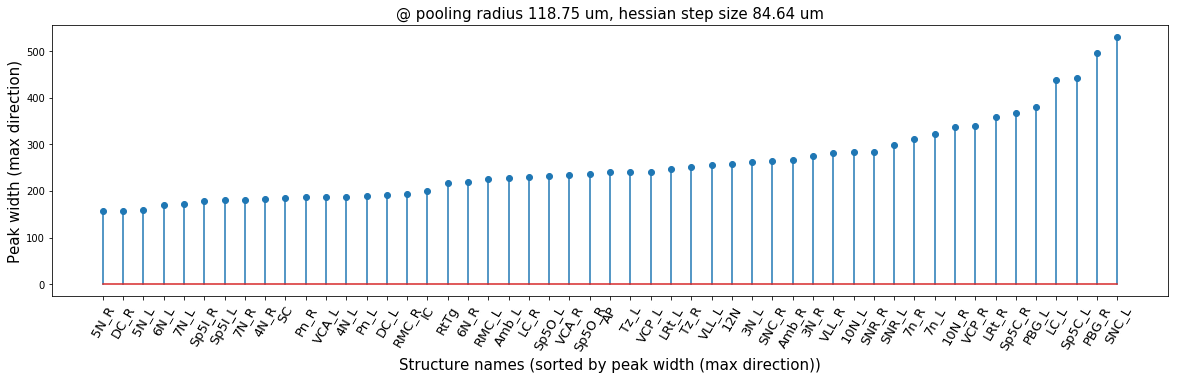

In [129]:
plt.figure(figsize=(20,5));
plt.stem(range(len(prmax_sorted)), prmax_sorted);
plt.xticks(range(len(structures_sorted_by_prmax)), structures_sorted_by_prmax, rotation='60', fontsize=13);
plt.xlabel('Structure names (sorted by peak width (max direction))', fontsize=15);
plt.ylabel('Peak width (max direction)', fontsize=15);
plt.title('@ pooling radius 118.75 um, hessian step size 84.64 um', fontsize=15);

In [130]:
zscores_all_structures = {structure: x[118.75][0] for structure, x in zscores_all_stacks_all_structures[stack_fixed].iteritems()}
structures_sorted_by_zscore, zscores_sorted = zip(*sorted(zscores_all_structures.items(), key=lambda x: x[1], reverse=True))

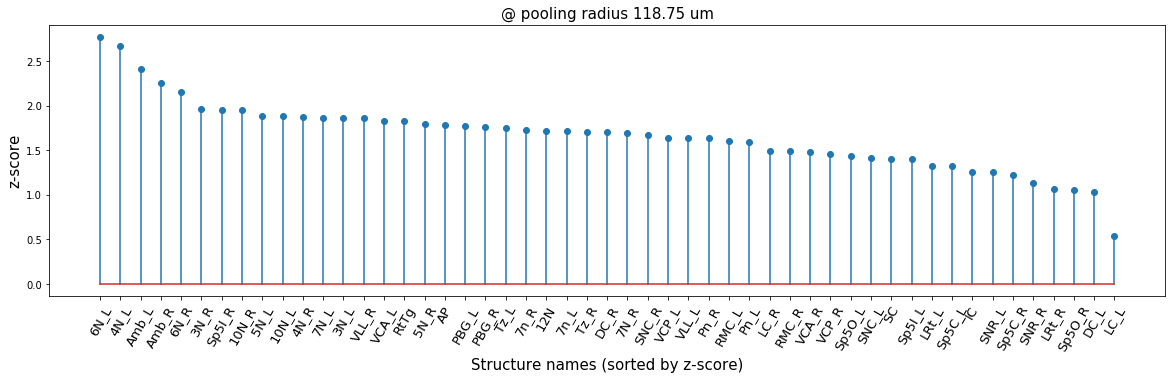

In [134]:
plt.figure(figsize=(20,5));
plt.stem(range(len(zscores_sorted)), zscores_sorted);
plt.xticks(range(len(structures_sorted_by_zscore)), structures_sorted_by_zscore, rotation='60', fontsize=13);
plt.xlabel('Structure names (sorted by z-score)', fontsize=15);
plt.ylabel('z-score', fontsize=15);
plt.title('@ pooling radius 118.75 um', fontsize=15);

In [164]:
structures_ranked = [structures_sided_sorted_by_size[i] for i in \
                                  np.argsort(\
                                             np.argsort(np.argsort([zscores_all_structures[s] for s in structures_sided_sorted_by_size])[::-1]) + \
                                             np.argsort(np.argsort([prmax_all_structures[s] for s in structures_sided_sorted_by_size])))]

In [169]:
print structures_ranked[-10:]

['LRt_L', 'Sp5O_R', 'VCP_R', 'SNR_L', 'SNR_R', 'SNC_L', 'Sp5C_L', 'Sp5C_R', 'LRt_R', 'LC_L']


In [136]:
print 'Unconfident structures:', set(structures_sorted_by_prmax[-15:]) & set(structures_sorted_by_zscore[-15:])

Unconfident structures: set(['LRt_R', 'VCP_R', 'Sp5C_L', 'SNR_L', 'SNC_L', 'LC_L', 'Sp5C_R', 'SNR_R'])


# Rank structures by confidence, for rotations

In [95]:
prAroundZ_all_structures = {structure: x[np.deg2rad(pool_radius_degrees_list[2])][np.deg2rad(rotation_stepsizes_degrees[2])][0] for structure, x in peak_radius_rad_all_stacks_all_structures[stack_fixed].iteritems()}
structures_sorted_by_prAroundZ, prAroundZ_sorted = zip(*sorted(prAroundZ_all_structures.items(), key=lambda (s, pr): pr))

prAroundX_all_structures = {structure: x[np.deg2rad(pool_radius_degrees_list[2])][np.deg2rad(rotation_stepsizes_degrees[2])][2] for structure, x in peak_radius_rad_all_stacks_all_structures[stack_fixed].iteritems()}
structures_sorted_by_prAroundX, prAroundX_sorted = zip(*sorted(prAroundX_all_structures.items(), key=lambda (s, pr): pr))

prAroundY_all_structures = {structure: x[np.deg2rad(pool_radius_degrees_list[2])][np.deg2rad(rotation_stepsizes_degrees[2])][1] for structure, x in peak_radius_rad_all_stacks_all_structures[stack_fixed].iteritems()}
structures_sorted_by_prAroundY, prAroundY_sorted = zip(*sorted(prAroundY_all_structures.items(), key=lambda (s, pr): pr))

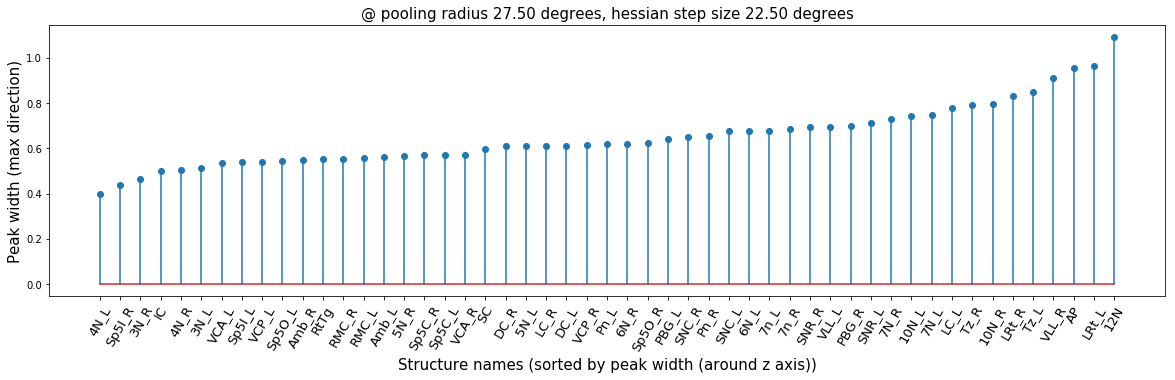

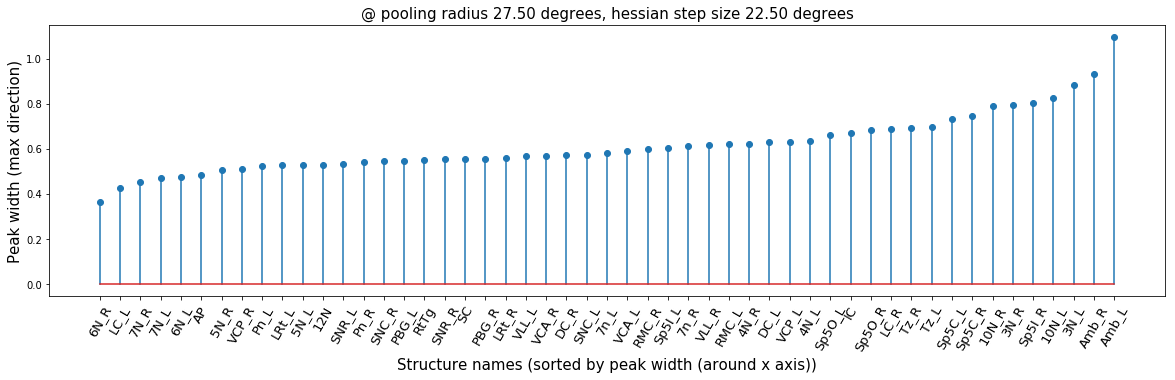

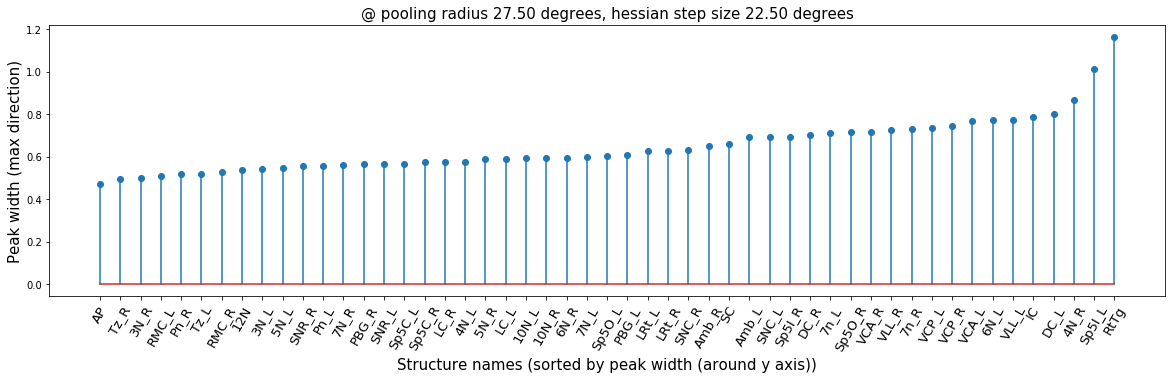

In [96]:
plt.figure(figsize=(20,5));
plt.stem(range(len(prAroundZ_sorted)), prAroundZ_sorted);
plt.xticks(range(len(structures_sorted_by_prAroundZ)), structures_sorted_by_prAroundZ, rotation='60', fontsize=13);
plt.xlabel('Structure names (sorted by peak width (around z axis))', fontsize=15);
plt.ylabel('Peak width (max direction)', fontsize=15);
plt.title('@ pooling radius %.2f degrees, hessian step size %.2f degrees' % (pool_radius_degrees_list[2], rotation_stepsizes_degrees[2]), 
          fontsize=15);
plt.show();

plt.figure(figsize=(20,5));
plt.stem(range(len(prAroundX_sorted)), prAroundX_sorted);
plt.xticks(range(len(structures_sorted_by_prAroundX)), structures_sorted_by_prAroundX, rotation='60', fontsize=13);
plt.xlabel('Structure names (sorted by peak width (around x axis))', fontsize=15);
plt.ylabel('Peak width (max direction)', fontsize=15);
plt.title('@ pooling radius %.2f degrees, hessian step size %.2f degrees' % (pool_radius_degrees_list[2], rotation_stepsizes_degrees[2]), 
          fontsize=15);
plt.show();

plt.figure(figsize=(20,5));
plt.stem(range(len(prAroundY_sorted)), prAroundY_sorted);
plt.xticks(range(len(structures_sorted_by_prAroundY)), structures_sorted_by_prAroundY, rotation='60', fontsize=13);
plt.xlabel('Structure names (sorted by peak width (around y axis))', fontsize=15);
plt.ylabel('Peak width (max direction)', fontsize=15);
plt.title('@ pooling radius %.2f degrees, hessian step size %.2f degrees' % (pool_radius_degrees_list[2], rotation_stepsizes_degrees[2]), 
          fontsize=15);
plt.show();

# Plot peak radius of different structures in one stack

In [19]:
# Choose one set of meta parameters.

pool_radius = pooling_radius_list[2]
hessian_stepsize = hessian_stepsize_list[1]

In [20]:
structures_sided_sorted_by_size = ['4N_L', '4N_R', '6N_L', '6N_R', 'Amb_L', 'Amb_R', 'PBG_L', 'PBG_R', '10N_L', '10N_R', 'AP', '3N_L', '3N_R', 'LC_L', 'LC_R', 'SNC_L', 'SNC_R', 'Tz_L', 'Tz_R', '7n_L', '7n_R', 'RMC_L', 'RMC_R', '5N_L', '5N_R', 'VCP_L', 'VCP_R', '12N', 'LRt_L', 'LRt_R', '7N_L', '7N_R', 'VCA_L', 'VCA_R', 'VLL_L', 'VLL_R', 'DC_L', 'DC_R', 'Sp5O_L', 'Sp5O_R', 'Sp5I_L', 'Sp5I_R', 'Pn_L', 'Pn_R', 'RtTg', 'SNR_L', 'SNR_R', 'Sp5C_L', 'Sp5C_R', 'IC', 'SC']

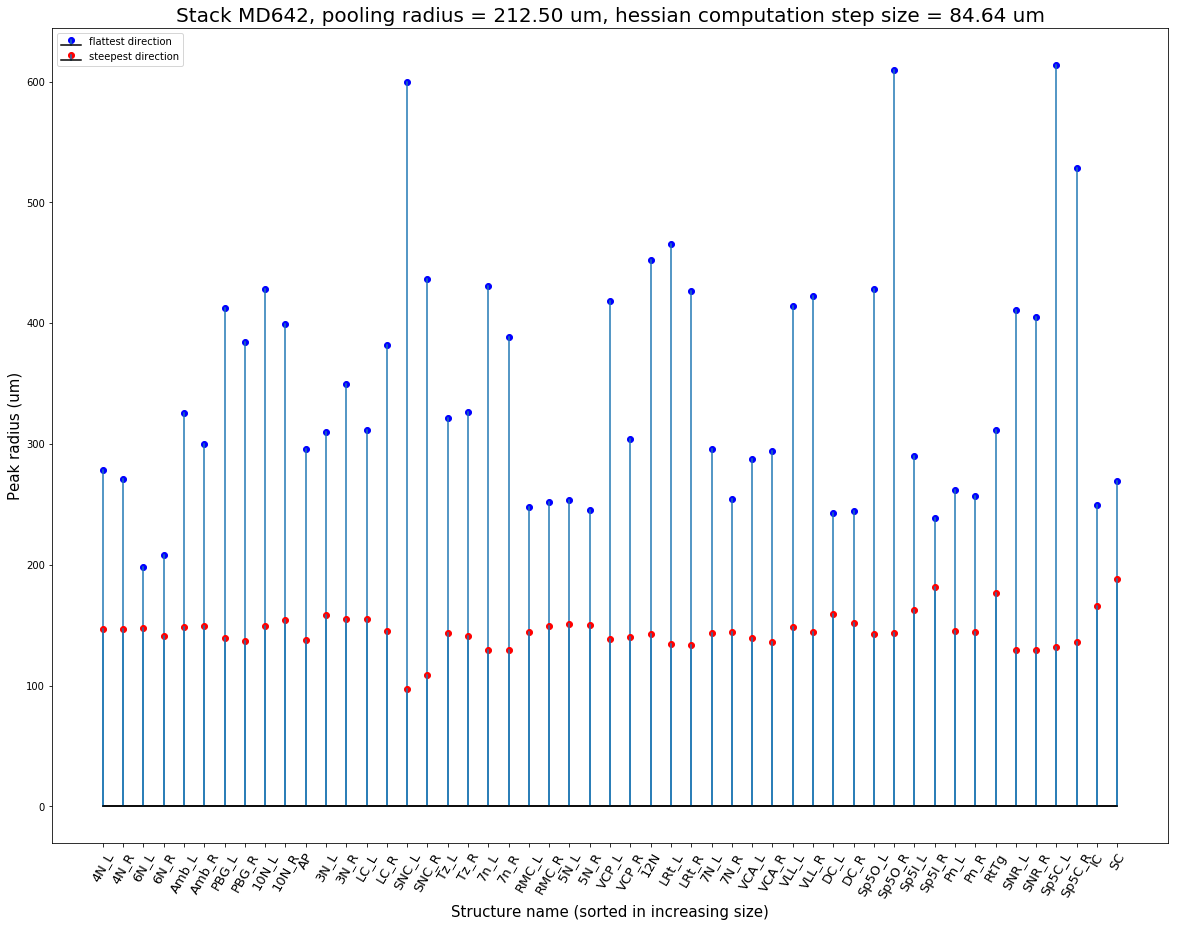

In [21]:
D = np.array([peak_radius_all_stacks_all_structures['MD642'][s][pool_radius][hessian_stepsize][:2]
     for s in structures_sided_sorted_by_size])

plt.figure(figsize=(20, 15));
plt.stem(range(1, len(structures_sided_sorted_by_size)+1), D[:,0], label='flattest direction', markerfmt='bo', basefmt='k');
plt.stem(range(1, len(structures_sided_sorted_by_size)+1), D[:,1], label='steepest direction', markerfmt='ro', basefmt='k');
plt.xticks(range(1, len(structures_sided_sorted_by_size)+1), structures_sided_sorted_by_size, 
           rotation='60', fontsize=13);
plt.xlabel('Structure name (sorted in increasing size)', fontsize=15);
plt.ylabel('Peak radius (um)', fontsize=15);
plt.title('Stack %s, pooling radius = %.2f um, hessian computation step size = %.2f um' % (stack_fixed, pool_radius, hessian_stepsize), fontsize=20);
plt.legend();

# Plot peak radius of different structures in one stack, for rotation

In [99]:
# Choose one set of meta parameters.

pool_radius_rad = np.deg2rad(pool_radius_degrees_list[2])
hessian_stepsize_rad = np.deg2rad(rotation_stepsizes_degrees[2])

In [100]:
structures_sided_sorted_by_size = ['4N_L', '4N_R', '6N_L', '6N_R', 'Amb_L', 'Amb_R', 'PBG_L', 'PBG_R', '10N_L', '10N_R', 'AP', '3N_L', '3N_R', 'LC_L', 'LC_R', 'SNC_L', 'SNC_R', 'Tz_L', 'Tz_R', '7n_L', '7n_R', 'RMC_L', 'RMC_R', '5N_L', '5N_R', 'VCP_L', 'VCP_R', '12N', 'LRt_L', 'LRt_R', '7N_L', '7N_R', 'VCA_L', 'VCA_R', 'VLL_L', 'VLL_R', 'DC_L', 'DC_R', 'Sp5O_L', 'Sp5O_R', 'Sp5I_L', 'Sp5I_R', 'Pn_L', 'Pn_R', 'RtTg', 'SNR_L', 'SNR_R', 'Sp5C_L', 'Sp5C_R', 'IC', 'SC']

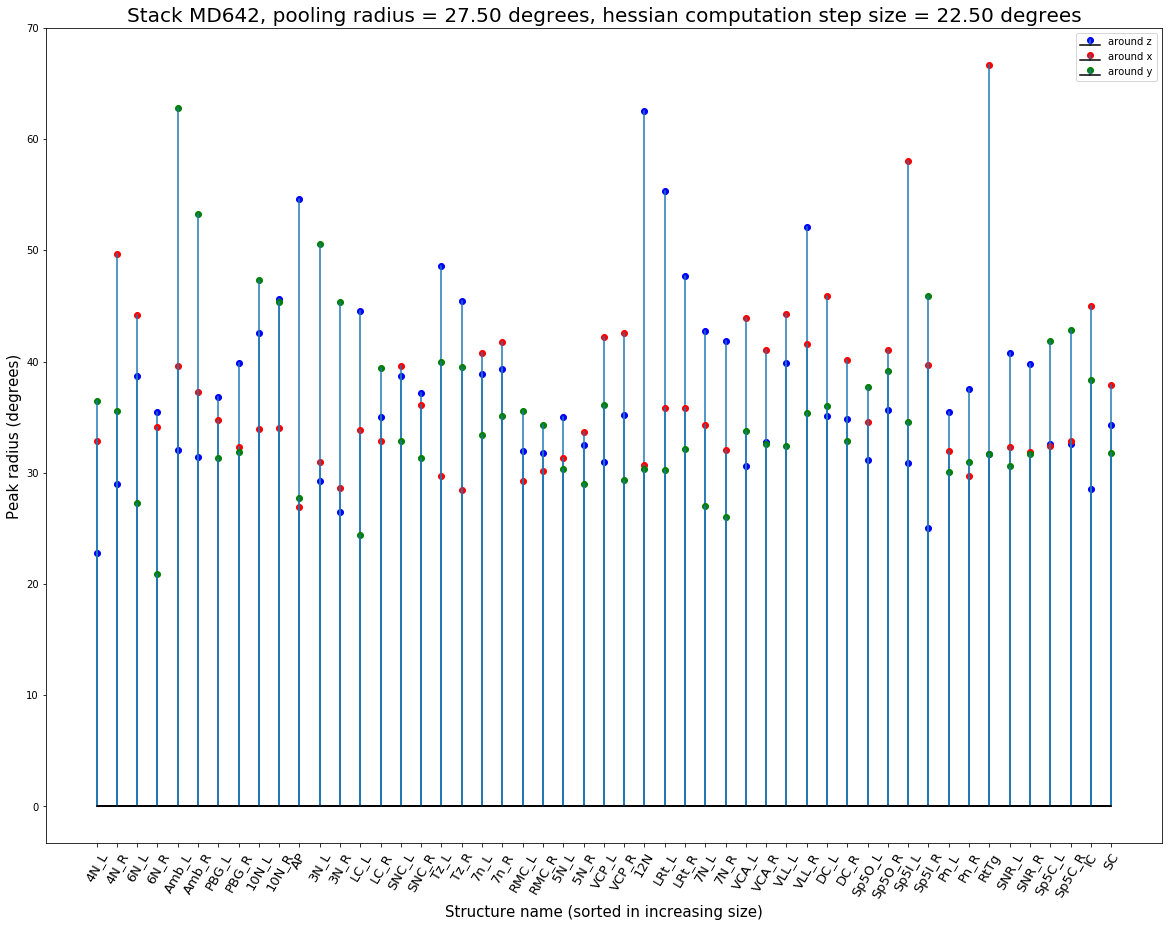

In [110]:
D = np.array([np.rad2deg(peak_radius_rad_all_stacks_all_structures['MD642'][s][pool_radius_rad][hessian_stepsize_rad])
     for s in structures_sided_sorted_by_size])

plt.figure(figsize=(20, 15));
plt.stem(range(1, len(structures_sided_sorted_by_size)+1), D[:,0], label='around z', markerfmt='bo', basefmt='k');
plt.stem(range(1, len(structures_sided_sorted_by_size)+1), D[:,1], label='around x', markerfmt='ro', basefmt='k');
plt.stem(range(1, len(structures_sided_sorted_by_size)+1), D[:,2], label='around y', markerfmt='go', basefmt='k');
plt.xticks(range(1, len(structures_sided_sorted_by_size)+1), structures_sided_sorted_by_size, 
           rotation='60', fontsize=13);
plt.xlabel('Structure name (sorted in increasing size)', fontsize=15);
plt.ylabel('Peak radius (degrees)', fontsize=15);
plt.title('Stack %s, pooling radius = %.2f degrees, hessian computation step size = %.2f degrees' % (stack_fixed, np.rad2deg(pool_radius_rad), np.rad2deg(hessian_stepsize_rad)), fontsize=20);
plt.legend();

# Plot z-scores of different structures for all stacks

In [32]:
# Choose one set of meta parameters.

pool_radius = pooling_radius_list[1]
hessian_stepsize = hessian_stepsize_list[0]

In [33]:
zsocres_all_structures_all_stacks_one_poolingRadius = defaultdict(dict)
for st, zs_all_structs in zscores_all_stacks_all_structures.iteritems():
    for struct, zs in zs_all_structs.iteritems():
        zsocres_all_structures_all_stacks_one_poolingRadius[struct][st] = zs[pool_radius][0]
        
zsocres_all_structures_all_stacks_one_poolingRadius.default_factory = None

In [34]:
structures_sided_sorted_by_size = ['4N_L', '4N_R', '6N_L', '6N_R', 'Amb_L', 'Amb_R', 'PBG_L', 'PBG_R', '10N_L', '10N_R', 'AP', '3N_L', '3N_R', 'LC_L', 'LC_R', 'SNC_L', 'SNC_R', 'Tz_L', 'Tz_R', '7n_L', '7n_R', 'RMC_L', 'RMC_R', '5N_L', '5N_R', 'VCP_L', 'VCP_R', '12N', 'LRt_L', 'LRt_R', '7N_L', '7N_R', 'VCA_L', 'VCA_R', 'VLL_L', 'VLL_R', 'DC_L', 'DC_R', 'Sp5O_L', 'Sp5O_R', 'Sp5I_L', 'Sp5I_R', 'Pn_L', 'Pn_R', 'RtTg', 'SNR_L', 'SNR_R', 'Sp5C_L', 'Sp5C_R', 'IC', 'SC']

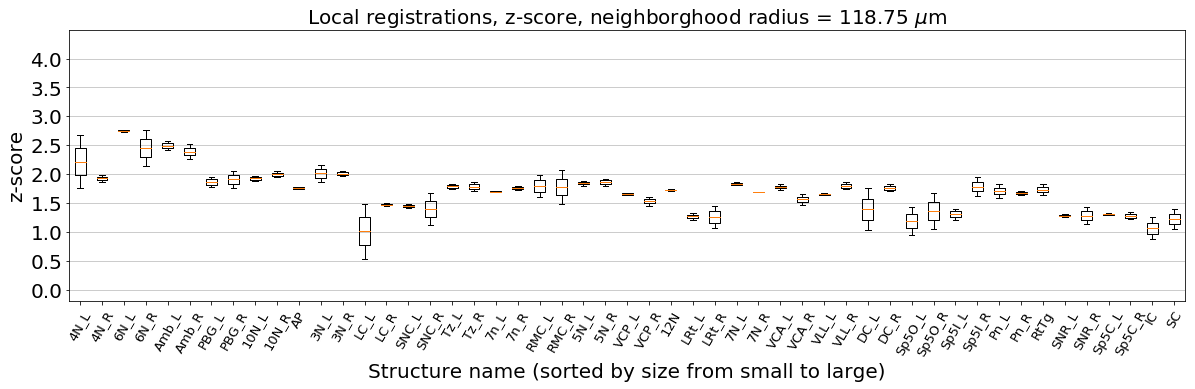

In [35]:
plt.figure(figsize=(20, 5));

D = [zsocres_all_structures_all_stacks_one_poolingRadius[s].values() 
     for s in structures_sided_sorted_by_size]

plt.boxplot(D);
plt.xticks(range(1, len(structures_sided_sorted_by_size)+1), structures_sided_sorted_by_size, 
           rotation='60', fontsize=13);
plt.yticks(np.arange(0, 4.5, .5), map(str, np.arange(0, 4.5, .5)), fontsize=20);
plt.ylim([-.2,4.5]);
plt.xlabel('Structure name (sorted by size from small to large)', fontsize=20);
plt.ylabel('z-score', fontsize=20);
# plt.title('z-score', fontsize=20);
plt.title('Local registrations, z-score, neighborghood radius = %.2f $\mu$m' % (pool_radius), fontsize=20);

plt.gca().yaxis.grid(True, linestyle='-', which='major', color='grey', alpha=0.5)
# Hide these grid behind plot objects
plt.gca().set_axisbelow(True)

In [36]:
np.mean(D)

1.6975214027832433

# Plot z-scores of different structures for all stacks, for rotation

In [112]:
# Choose one set of meta parameters.

pool_radius_rad = np.deg2rad(pool_radius_degrees_list[2])
hessian_stepsize_rad = np.deg2rad(rotation_stepsizes_degrees[2])

In [114]:
zscores_all_structures_all_stacks_one_poolingRadius = defaultdict(dict)
for st, zs_all_structs in zscores_all_stacks_all_structures.iteritems():
    for struct, zs in zs_all_structs.iteritems():
        zscores_all_structures_all_stacks_one_poolingRadius[struct][st] = zs[pool_radius_rad][0]
        
zscores_all_structures_all_stacks_one_poolingRadius.default_factory = None

In [115]:
structures_sided_sorted_by_size = ['4N_L', '4N_R', '6N_L', '6N_R', 'Amb_L', 'Amb_R', 'PBG_L', 'PBG_R', '10N_L', '10N_R', 'AP', '3N_L', '3N_R', 'LC_L', 'LC_R', 'SNC_L', 'SNC_R', 'Tz_L', 'Tz_R', '7n_L', '7n_R', 'RMC_L', 'RMC_R', '5N_L', '5N_R', 'VCP_L', 'VCP_R', '12N', 'LRt_L', 'LRt_R', '7N_L', '7N_R', 'VCA_L', 'VCA_R', 'VLL_L', 'VLL_R', 'DC_L', 'DC_R', 'Sp5O_L', 'Sp5O_R', 'Sp5I_L', 'Sp5I_R', 'Pn_L', 'Pn_R', 'RtTg', 'SNR_L', 'SNR_R', 'Sp5C_L', 'Sp5C_R', 'IC', 'SC']

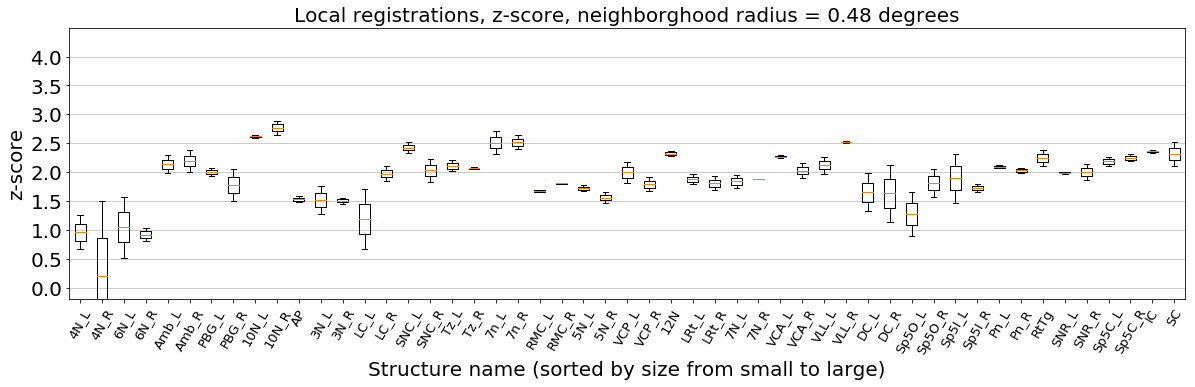

In [116]:
plt.figure(figsize=(20, 5));

D = [zscores_all_structures_all_stacks_one_poolingRadius[s].values() 
     for s in structures_sided_sorted_by_size]

plt.boxplot(D);
plt.xticks(range(1, len(structures_sided_sorted_by_size)+1), structures_sided_sorted_by_size, 
           rotation='60', fontsize=13);
plt.yticks(np.arange(0, 4.5, .5), map(str, np.arange(0, 4.5, .5)), fontsize=20);
plt.ylim([-.2,4.5]);
plt.xlabel('Structure name (sorted by size from small to large)', fontsize=20);
plt.ylabel('z-score', fontsize=20);
# plt.title('z-score', fontsize=20);
plt.title('Local registrations, z-score, neighborghood radius = %.2f degrees' % (pool_radius_rad), fontsize=20);

plt.gca().yaxis.grid(True, linestyle='-', which='major', color='grey', alpha=0.5)
# Hide these grid behind plot objects
plt.gca().set_axisbelow(True)

# Plot peak radius of different structures for all stacks

In [37]:
# Choose one set of meta parameters.

pool_radius = pooling_radius_list[1]
hessian_stepsize = hessian_stepsize_list[0]
print pool_radius
print hessian_stepsize

118.75
14.72


In [38]:
peak_radius_max_oneCombination = defaultdict(dict)
peak_radius_min_oneCombination = defaultdict(dict)
for stack, x_per_stack in peak_radius_all_stacks_all_structures.iteritems():
    for struct, x in x_per_stack.iteritems():
        prmax, prmin, pr2sigma = x[pool_radius][hessian_stepsize]
        peak_radius_min_oneCombination[struct][stack] = prmin
        peak_radius_max_oneCombination[struct][stack] = prmax

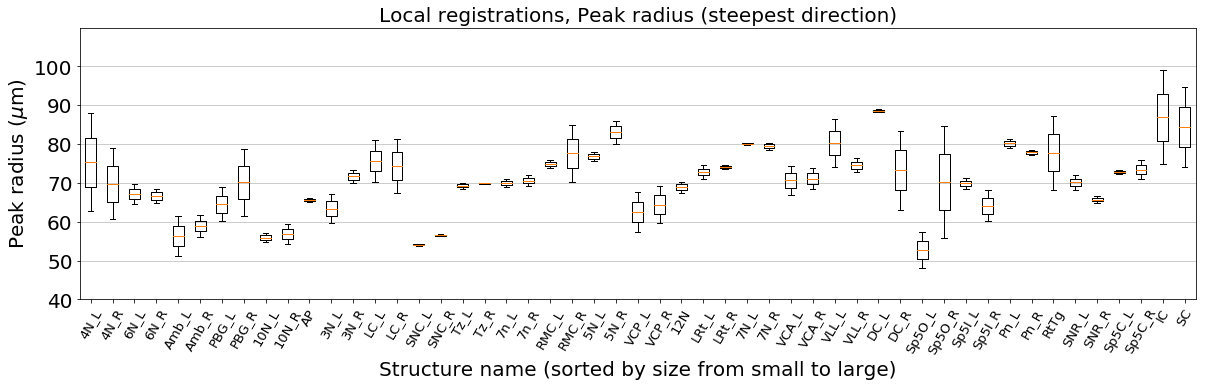

In [39]:
plt.figure(figsize=(20, 5));

D = [peak_radius_min_oneCombination[struct].values() for struct in structures_sided_sorted_by_size]
plt.boxplot(D);
plt.ylim([40, 110]);
plt.xticks(range(1, len(structures_sided_sorted_by_size)+1), structures_sided_sorted_by_size, rotation='60', fontsize=13);
plt.xlabel('Structure name (sorted by size from small to large)', fontsize=20);
plt.yticks(np.arange(40, 110, 10), map(str, np.arange(40, 110, 10)), fontsize=20);
plt.ylabel('Peak radius ($\mu$m)', fontsize=20);
plt.title('Local registrations, Peak radius (steepest direction)', fontsize=20);

plt.gca().yaxis.grid(True, linestyle='-', which='major', color='grey', alpha=0.5)
# Hide these grid behind plot objects
plt.gca().set_axisbelow(True)

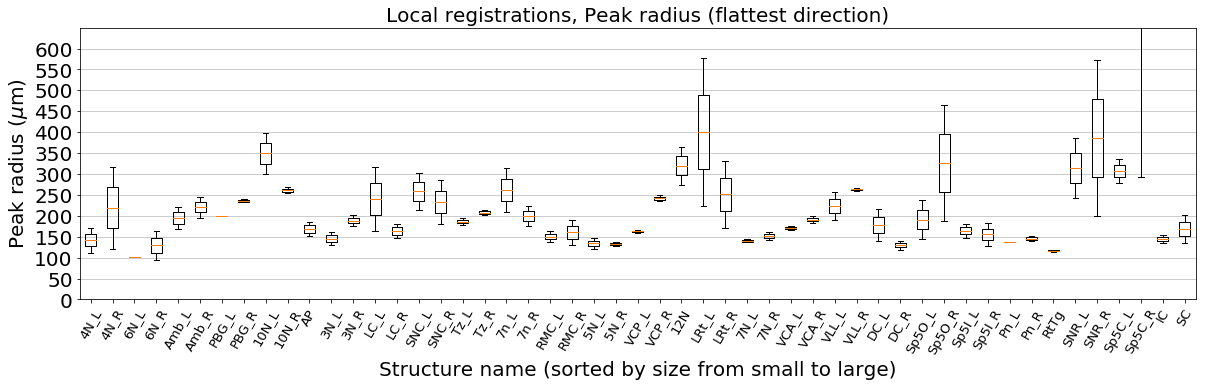

In [40]:
plt.figure(figsize=(20, 5));

D = [peak_radius_max_oneCombination[struct].values() for struct in structures_sided_sorted_by_size]
plt.boxplot(D);
plt.ylim([0, 650]);
plt.xticks(range(1, len(structures_sided_sorted_by_size)+1), structures_sided_sorted_by_size, rotation='60', fontsize=13);
plt.xlabel('Structure name (sorted by size from small to large)', fontsize=20);
plt.yticks(np.arange(0, 650, 50), map(str, np.arange(0, 650, 50)), fontsize=20);
plt.ylabel('Peak radius ($\mu$m)', fontsize=20);
plt.title('Local registrations, Peak radius (flattest direction)', fontsize=20);

plt.gca().yaxis.grid(True, linestyle='-', which='major', color='grey', alpha=0.5)
# Hide these grid behind plot objects
plt.gca().set_axisbelow(True)

# Plot peak radius of different structures for all stacks, for rotation

In [121]:
# Choose one set of meta parameters.

pool_radius_rad = np.deg2rad(pool_radius_degrees_list[2])
hessian_stepsize_rad = np.deg2rad(rotation_stepsizes_degrees[2])

In [131]:
peak_radius_rad_around_x_oneCombination = defaultdict(dict)
peak_radius_rad_around_y_oneCombination = defaultdict(dict)
peak_radius_rad_around_z_oneCombination = defaultdict(dict)
for stack, x_per_stack in peak_radius_rad_all_stacks_all_structures.iteritems():
    for struct, x in x_per_stack.iteritems():
        prAroundZ, prAroundX, prAroundY = x[pool_radius_rad][hessian_stepsize_rad]
        peak_radius_rad_around_x_oneCombination[struct][stack] = prAroundX
        peak_radius_rad_around_y_oneCombination[struct][stack] = prAroundY
        peak_radius_rad_around_z_oneCombination[struct][stack] = prAroundZ

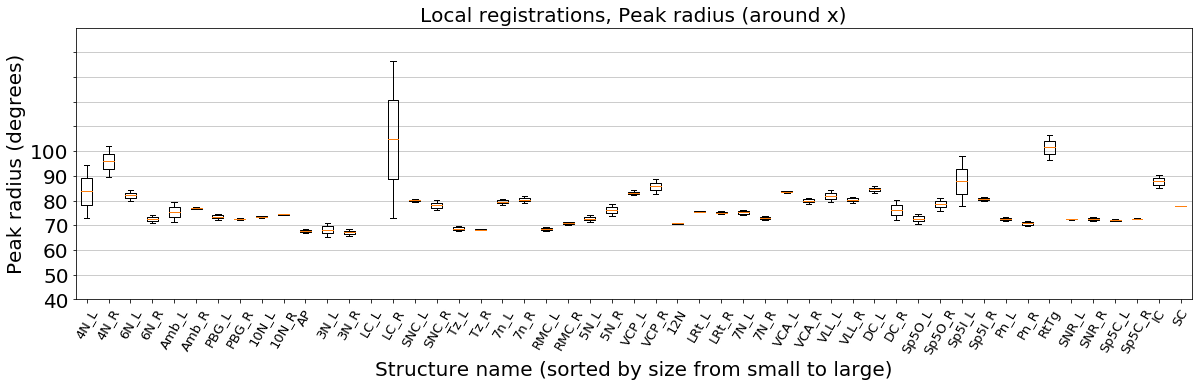

In [125]:
plt.figure(figsize=(20, 5));

D = [np.rad2deg(peak_radius_rad_around_x_oneCombination[struct].values()) 
     for struct in structures_sided_sorted_by_size]
plt.boxplot(D);
plt.ylim([0, 110]);
plt.xticks(range(1, len(structures_sided_sorted_by_size)+1), structures_sided_sorted_by_size, rotation='60', fontsize=13);
plt.xlabel('Structure name (sorted by size from small to large)', fontsize=20);
plt.yticks(np.arange(0, 110, 10), map(str, np.arange(40, 110, 10)), fontsize=20);
plt.ylabel('Peak radius (degrees)', fontsize=20);
plt.title('Local registrations, Peak radius (around x)', fontsize=20);

plt.gca().yaxis.grid(True, linestyle='-', which='major', color='grey', alpha=0.5)
# Hide these grid behind plot objects
plt.gca().set_axisbelow(True)

In [ ]:
plt.figure(figsize=(20, 5));

D = [np.rad2deg(peak_radius_rad_around_x_oneCombination[struct].values()) 
     for struct in structures_sided_sorted_by_size]
plt.boxplot(D);
plt.ylim([0, 110]);
plt.xticks(range(1, len(structures_sided_sorted_by_size)+1), structures_sided_sorted_by_size, rotation='60', fontsize=13);
plt.xlabel('Structure name (sorted by size from small to large)', fontsize=20);
plt.yticks(np.arange(0, 110, 10), map(str, np.arange(40, 110, 10)), fontsize=20);
plt.ylabel('Peak radius (degrees)', fontsize=20);
plt.title('Local registrations, Peak radius (around x)', fontsize=20);

plt.gca().yaxis.grid(True, linestyle='-', which='major', color='grey', alpha=0.5)
# Hide these grid behind plot objects
plt.gca().set_axisbelow(True)

# Put both flattest / steepest directions in one figure

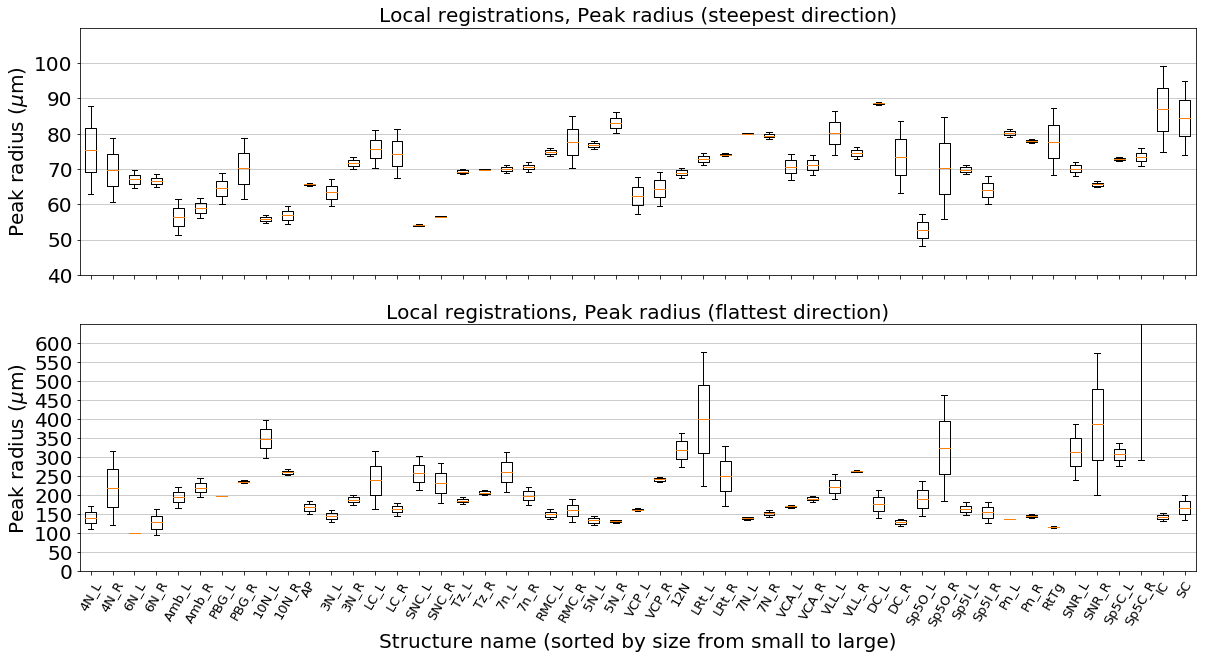

In [41]:
# Version 1: Two subplots

fig, axes = plt.subplots(2, 1, figsize=(20,10), sharex=True);

D = [peak_radius_min_oneCombination[struct].values() for struct in structures_sided_sorted_by_size]
axes[0].boxplot(D);
axes[0].set_ylim([40, 110]);

axes[0].set_yticks(np.arange(40, 110, 10));
axes[0].set_yticklabels(map(str, np.arange(40, 110, 10)), fontsize=20);
axes[0].set_ylabel('Peak radius ($\mu$m)', fontsize=20);
axes[0].set_title('Local registrations, Peak radius (steepest direction)', fontsize=20);

axes[0].yaxis.grid(True, linestyle='-', which='major', color='grey', alpha=0.5)
# Hide these grid behind plot objects
axes[0].set_axisbelow(True)

D = [peak_radius_max_oneCombination[struct].values() for struct in structures_sided_sorted_by_size]
axes[1].boxplot(D);
axes[1].set_ylim([0, 650]);
axes[1].set_yticks(np.arange(0, 650, 50));
axes[1].set_yticklabels(map(str, np.arange(0, 650, 50)), fontsize=20);
axes[1].set_ylabel('Peak radius ($\mu$m)', fontsize=20);
axes[1].set_title('Local registrations, Peak radius (flattest direction)', fontsize=20);

axes[1].yaxis.grid(True, linestyle='-', which='major', color='grey', alpha=0.5)
# Hide these grid behind plot objects
axes[1].set_axisbelow(True)

plt.xticks(range(1, len(structures_sided_sorted_by_size)+1), structures_sided_sorted_by_size, rotation='60', fontsize=13);
plt.xlabel('Structure name (sorted by size from small to large)', fontsize=20);

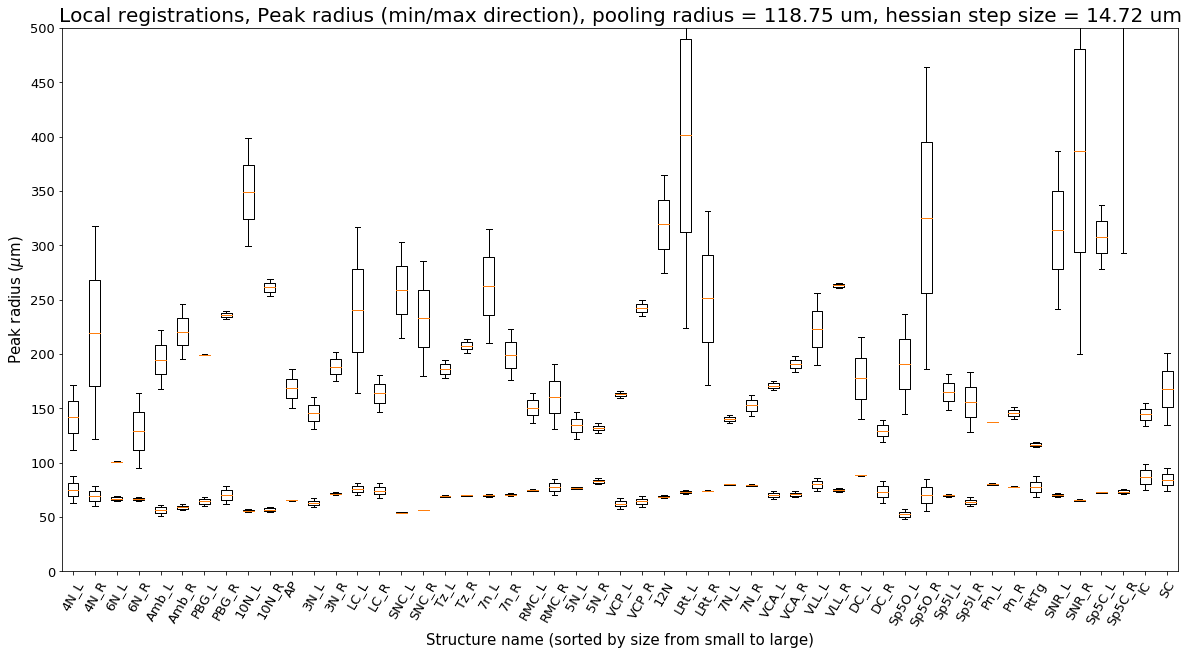

In [42]:
# Version 2: in one plot

plt.figure(figsize=(20, 10));

D = [peak_radius_min_oneCombination[struct].values() for struct in structures_sided_sorted_by_size]

# plt.figure(figsize=(20, 15));
# # plt.stem(range(1, len(boxplot_labels)+1), D);
plt.boxplot(D);
# # plt.ylim([26, 42]);
# plt.xticks(range(1, len(boxplot_labels)+1), boxplot_labels, rotation='60', fontsize=13);
# plt.xlabel('Structure name', fontsize=15);
# plt.ylabel('Peak radius (um)', fontsize=15);
# plt.title('Peak radius min, pooling radius = %.2f um, hessian step size = %.2f um' % (pool_radius, hessian_stepsize), fontsize=20);

###########################        

D = [peak_radius_max_oneCombination[struct].values() for struct in structures_sided_sorted_by_size]

# plt.figure(figsize=(20, 15));
# plt.stem(range(1, len(boxplot_labels)+1), D);
plt.boxplot(D);
plt.ylim([0, 500]);
plt.xticks(range(1, len(structures_sided_sorted_by_size)+1), structures_sided_sorted_by_size, rotation='60', fontsize=13);
plt.xlabel('Structure name (sorted by size from small to large)', fontsize=15);
plt.yticks(np.arange(0, 550, 50), map(str, np.arange(0, 550, 50)), fontsize=13);
plt.ylabel('Peak radius ($\mu$m)', fontsize=15);
plt.title('Local registrations, Peak radius (min/max direction), pooling radius = %.2f um, hessian step size = %.2f um' % (pool_radius, hessian_stepsize), fontsize=20);

In [29]:
def plot_peak_radius(peak_radius):
    for poolradius_um, v in peak_radius.iteritems():
        xs, ys_max_min = zip(*sorted(v.items()))
        ys_max, ys_min = zip(*ys_max_min)
        c = np.array(random_colors(1)[0])/255.
        plt.plot(xs, ys_max, linestyle='-', color=c, label='pool=%dum, max' % poolradius_um);
        plt.plot(xs, ys_min, linestyle='--', color=c, label='pool=%dum, min' % poolradius_um);
    plt.legend(loc='lower right');
    plt.xlabel('Hessian step size (um)');
    plt.ylabel('Peak radius (um)');
    plt.show();

# OLD CODE

In [ ]:
# peak radius computed using largest eigenvalue

peak_radius_allStructures = {}
zscores_allStructures = {}

for name_s in structures_sided:
        
#     hessian_fp = DataManager.get_hessian_filepath(stack_moving=stack_moving, stack_fixed=stack_fixed, 
#                                         moving_volume_type='score', fixed_volume_type='score', 
#                                         label=name_s,
#                                         train_sample_scheme=train_sample_scheme, 
#                                         global_transform_scheme=global_transform_scheme, 
#                                         local_transform_scheme=local_transform_scheme)  
#     hessians = load_pickle(hessian_fp)
    
#     zscore_fp = DataManager.get_zscore_filepath(stack_moving=stack_moving, stack_fixed=stack_fixed, 
#                                         moving_volume_type='score', fixed_volume_type='score', 
#                                         label=name_s,
#                                         train_sample_scheme=train_sample_scheme, 
#                                         global_transform_scheme=global_transform_scheme, 
#                                         local_transform_scheme=local_transform_scheme)
#     zscores = load_pickle(zscore_fp)
    
    zscores_allStructures[name_s] = zscores
    
    ###################################################
        
    peak_radius = {}
        
    for pooling_radius, (zscore, fmax, mu, std) in zscores.iteritems():
        
        peak_radius[pooling_radius] = {}
        
        for step_size, (H, fmax) in hessians.iteritems():
            if pooling_radius > step_size * 2:  # compute only if pooling radius is at least twice the step size
                U, S, UT = np.linalg.svd(H)
                peak_radius[pooling_radius][step_size] = np.sqrt(2*(fmax-mu)/S[0])

    peak_radius_allStructures[name_s] = peak_radius

In [ ]:
# Compute peak radius using the largest eigenvalues of Hessians

for pooling_radius, (zscore, fmax, mu, std) in zscores.iteritems():
    peak_radius[pooling_radius] = {}
    for step_size, (H, fmax) in Hs.iteritems():
        if pooling_radius > step_size * 2:  # compute only if pooling radius is at least twice the step size
            U, S, UT = np.linalg.svd(H)
            peak_radius[pooling_radius][step_size] = np.sqrt(2*(fmax-mu)/S[0])

peak_radius_allStructures[name_s] = peak_radius

# Compute peak radius using the smallest eigenvalues of Hessians

for pooling_radius, (zscore, fmax, mu, std) in zscores.iteritems():
    peak_radius[pooling_radius] = {}
    for step_size, (H, fmax) in Hs.iteritems():
        if pooling_radius > step_size * 2:  # compute only if pooling radius is at least twice the step size
            U, S, UT = np.linalg.svd(H)
            peak_radius[pooling_radius][step_size] = np.sqrt(2*(fmax-mu)/S[-1])

peak_radius_allStructures[name_s] = peak_radius

# Local

In [ ]:
#END

In [ ]:
fp = DataManager.get_hessian_filepath(stack_moving=stack_moving, stack_fixed=stack_fixed, 
                                        moving_volume_type='score', fixed_volume_type='score', 
                                        label=name_s,
                                        train_sample_scheme=train_sample_scheme, 
                                        global_transform_scheme=global_transform_scheme, 
                                        local_transform_scheme=local_transform_scheme)
    
hessians = load_pickle(fp)

In [15]:
zscores_allStructures = {}

for name_s in structures_sided:
    
    fp = DataManager.get_zscore_filepath(stack_moving=stack_moving, stack_fixed=stack_fixed, 
                                    moving_volume_type='score', fixed_volume_type='score', 
                                    label=name_s,
                                    train_sample_scheme=train_sample_scheme, 
                                    global_transform_scheme=global_transform_scheme, 
                                    local_transform_scheme=local_transform_scheme)

    zscores = load_pickle(fp)
    
    zscores_allStructures[name_s] = zscores

In [16]:
pooling_radius_list = sorted(zscores_allStructures['7N_L'].keys())

In [17]:
D = np.array([[z[0] for r, z in d.items()] for n, d in sorted(zscores_allStructures.items())])

In [18]:
boxplot_labels = sorted(zscores_allStructures.keys())

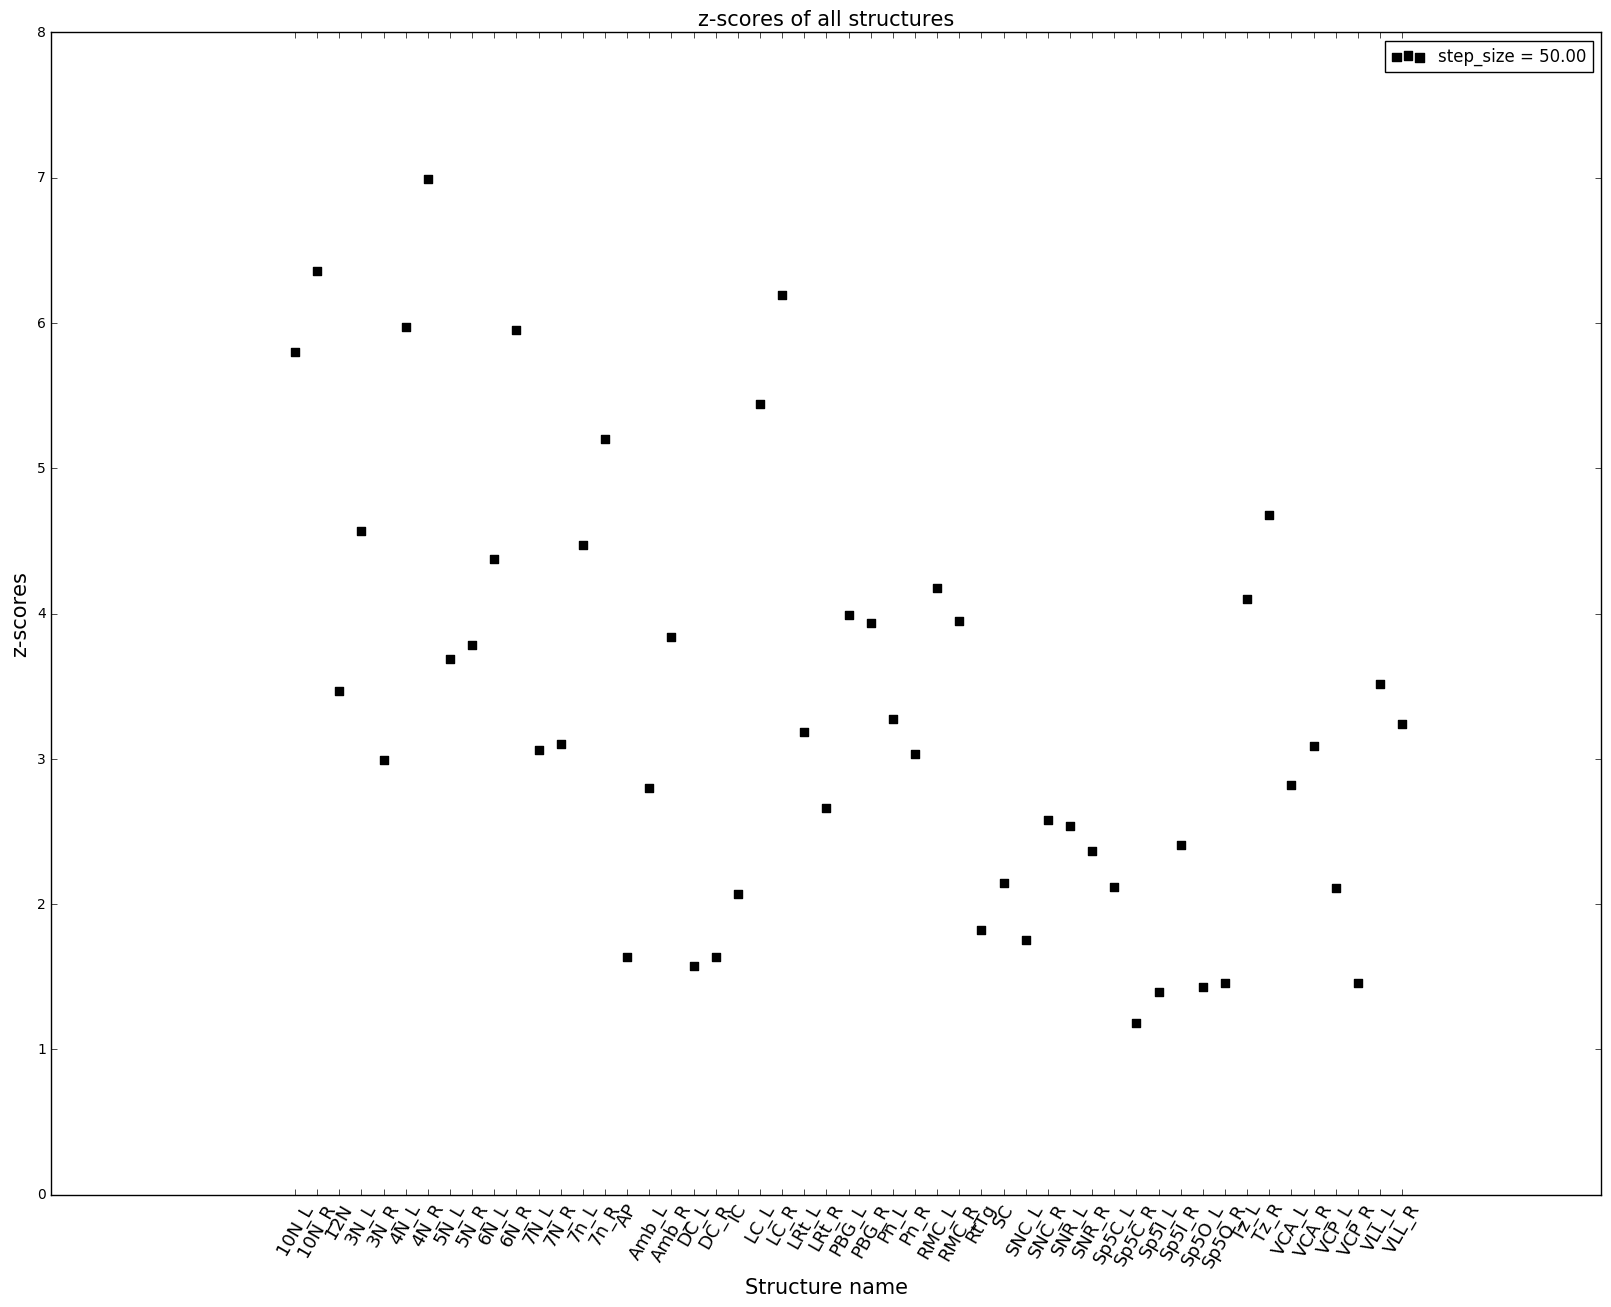

In [41]:
fig = plt.figure(figsize=(20, 15));
# fig, axes = plt.subplots(4, 1, figsize=(20, 30), sharex=False, sharey=True);

# plt.scatter(range(1, len(boxplot_labels)+1), D[:,0], marker='o', s=40, c='b', label='step_size = %.2f' % pooling_radius_list[0]);
# plt.scatter(range(1, len(boxplot_labels)+1), D[:,1], marker='^', s=40, c='g', label='step_size = %.2f' % pooling_radius_list[1]);
# plt.scatter(range(1, len(boxplot_labels)+1), D[:,2], marker='*', s=40, c='r', label='step_size = %.2f' % pooling_radius_list[2]);
plt.scatter(range(1, len(boxplot_labels)+1), D[:,3], marker='s', s=40, c='k', label='step_size = %.2f' % pooling_radius_list[3]);

plt.xticks(range(1, len(boxplot_labels)+1), boxplot_labels, rotation='60', fontsize=13);
plt.xlabel('Structure name', fontsize=15);
# plt.yticks(np.arange(0.2, 5, .1), fontsize=15);
plt.ylabel('z-scores', fontsize=15);
plt.title('z-scores of all structures', fontsize=15);
plt.legend();

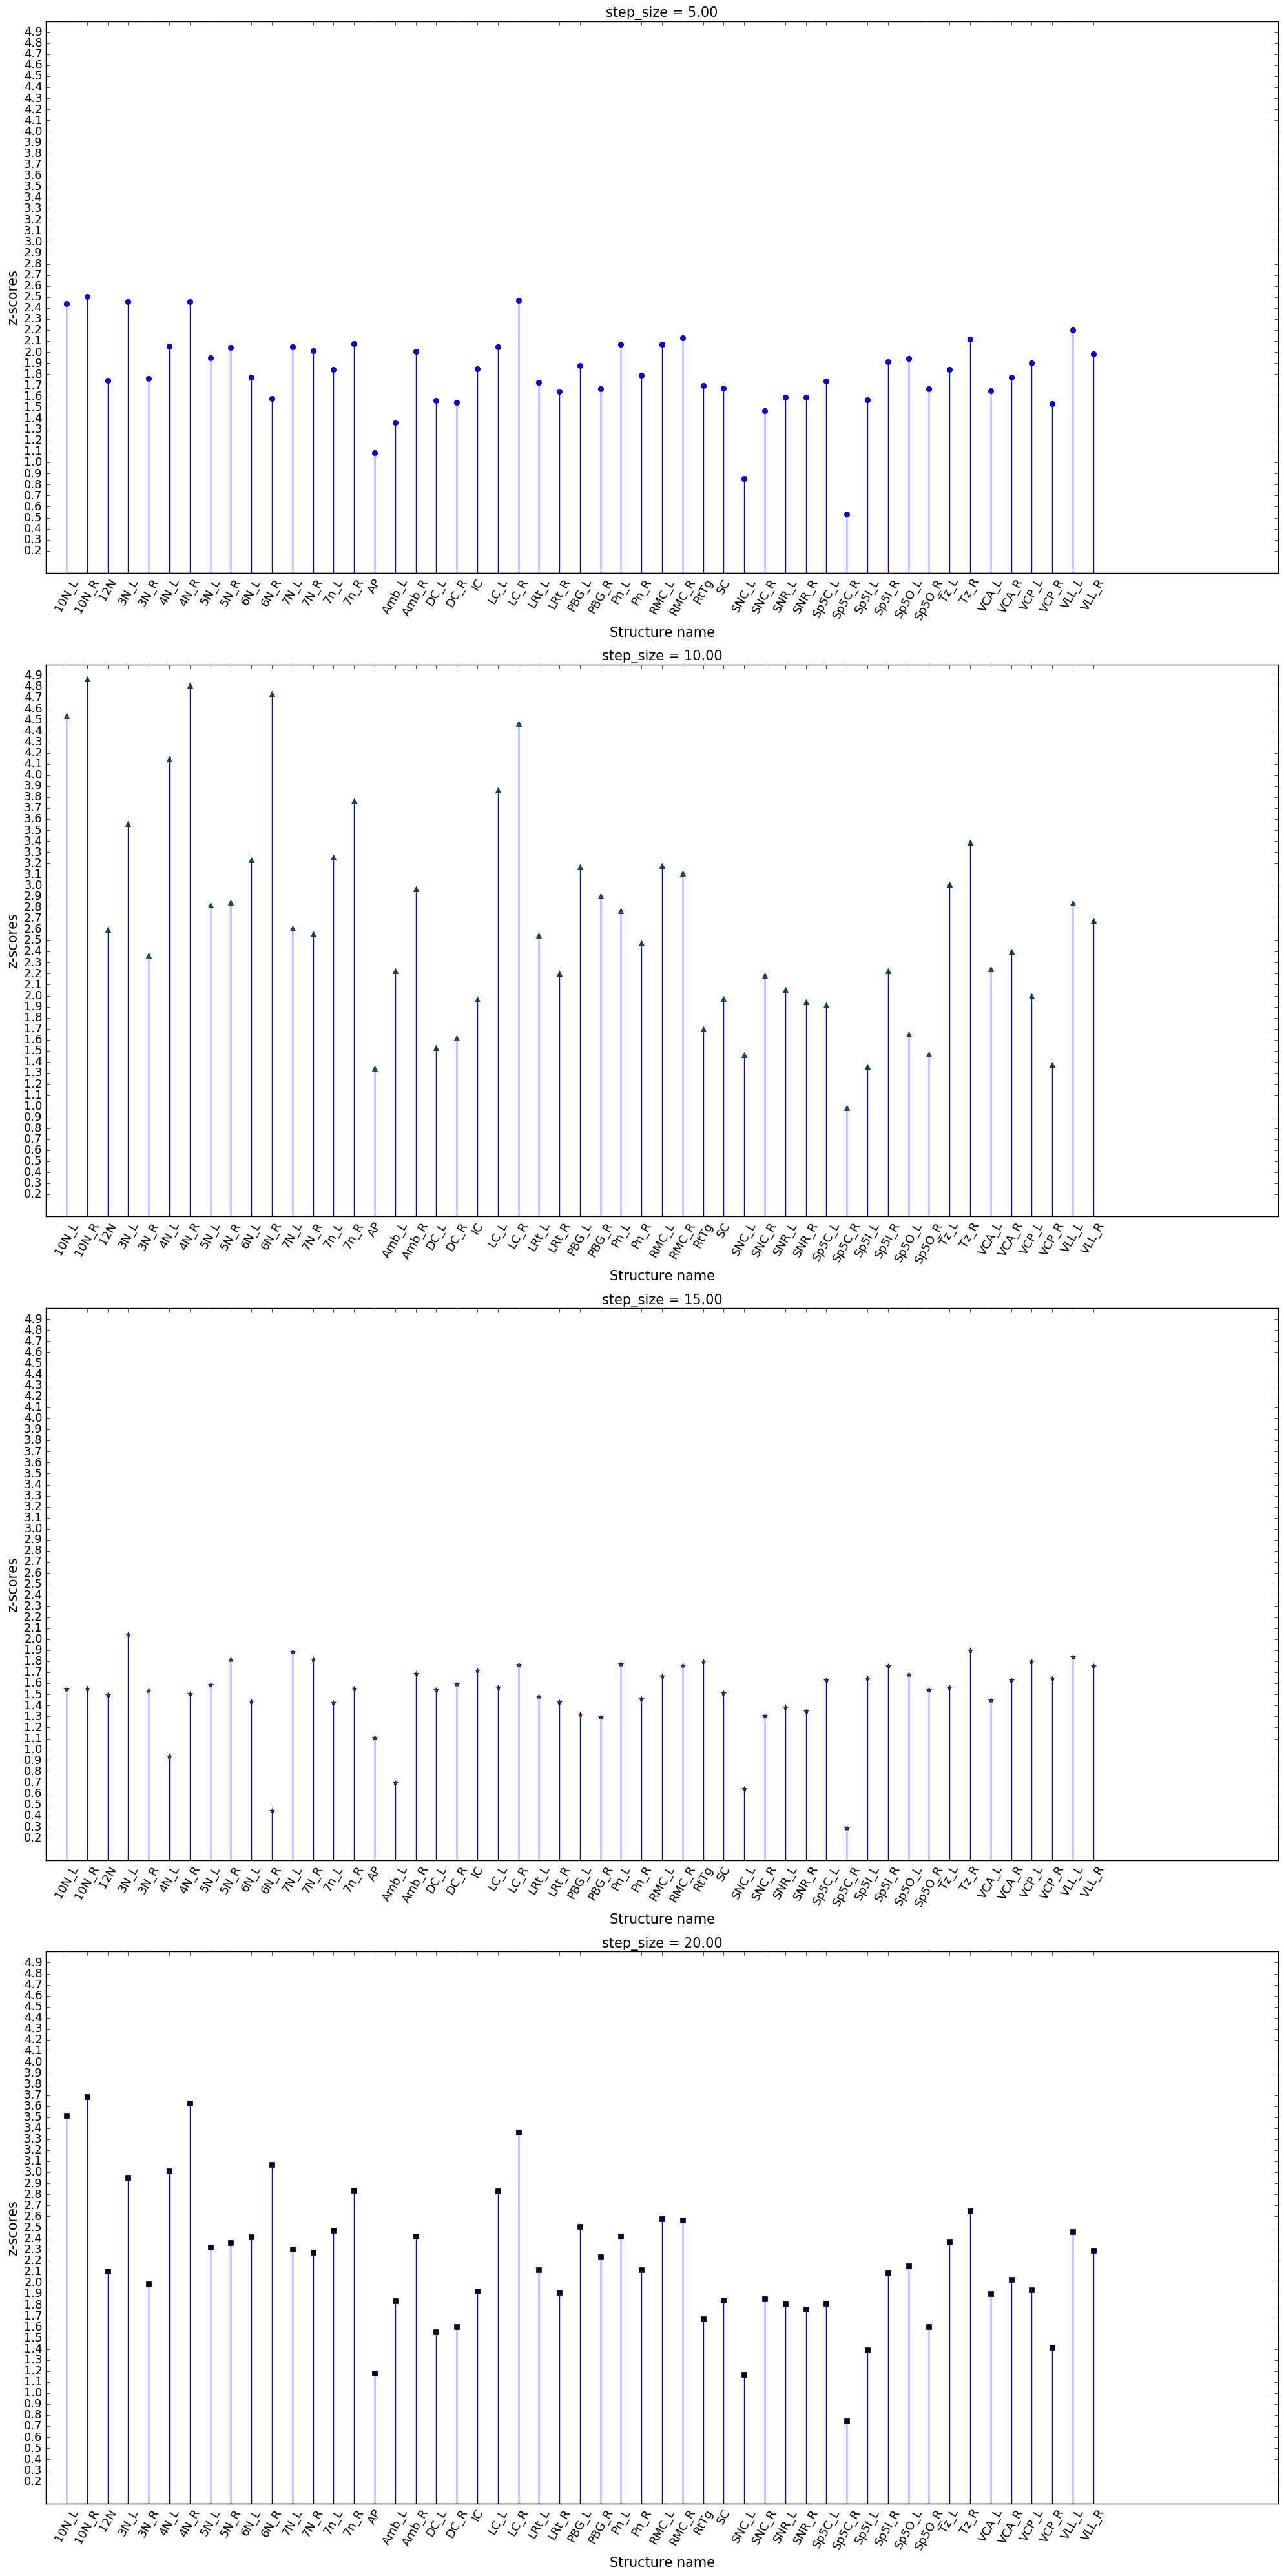

In [175]:
# fig = plt.figure(figsize=(20, 15));
fig, axes = plt.subplots(4, 1, figsize=(20, 40), sharex=False, sharey=True);

axes[0].stem(range(1, len(boxplot_labels)+1), D[:,0], markerfmt='bo', s=40);
axes[1].stem(range(1, len(boxplot_labels)+1), D[:,1], markerfmt='g^', s=40);
axes[2].stem(range(1, len(boxplot_labels)+1), D[:,2], markerfmt='r*', s=40);
axes[3].stem(range(1, len(boxplot_labels)+1), D[:,3], markerfmt='ks', s=40);

for i, ax in enumerate(axes):
    ax.set_xticks(range(1, len(boxplot_labels)+1))
    ax.set_xticklabels(boxplot_labels, rotation='60', fontsize=13);
    ax.set_xlabel('Structure name', fontsize=15);
    ax.set_yticks(np.arange(0.2, 5, .1));
    ax.set_yticklabels(np.arange(0.2, 5, .1), fontsize=13);
    ax.set_ylabel('z-scores', fontsize=15);
    ax.set_title('step_size = %.2f' % pooling_radius_list[i], fontsize=15);

plt.tight_layout()

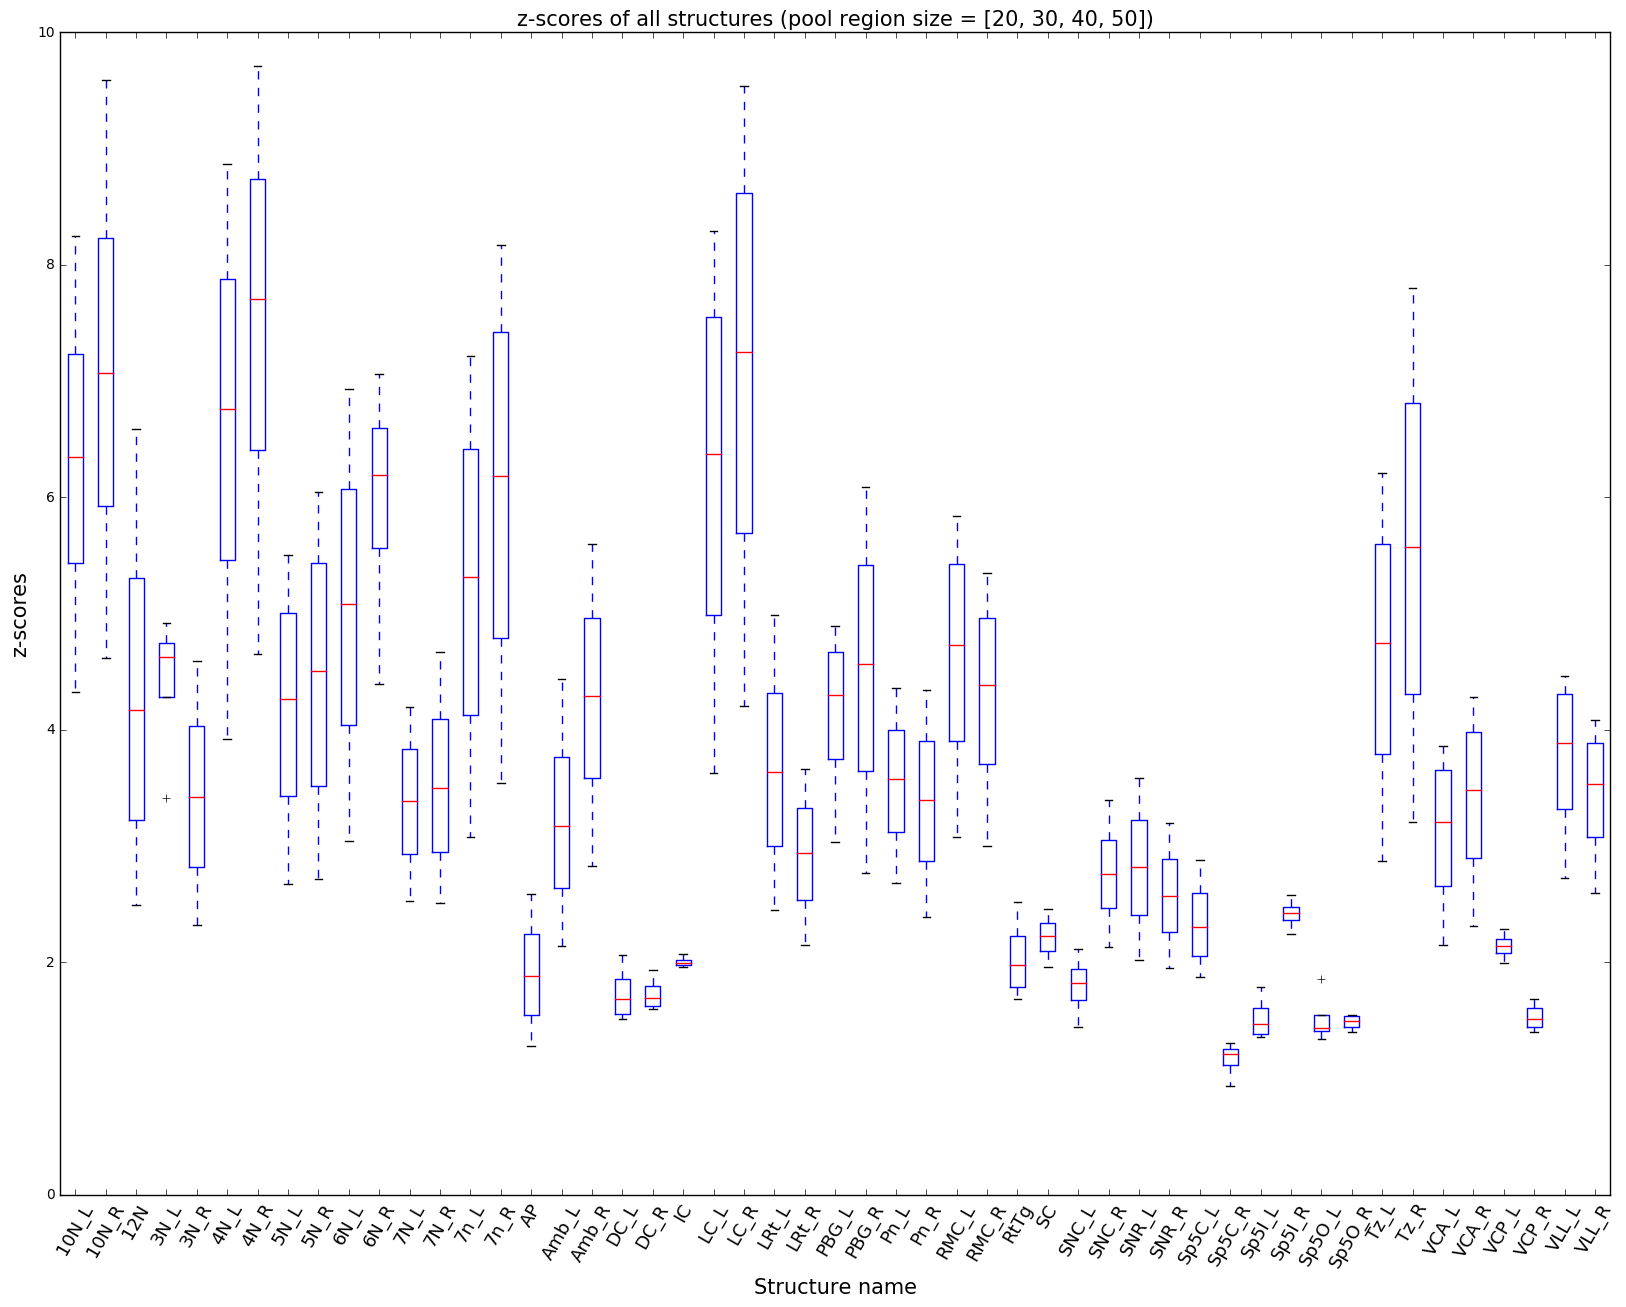

In [21]:
plt.figure(figsize=(20, 15));
plt.boxplot(D.T);
plt.xticks(range(1, len(boxplot_labels)+1), boxplot_labels, rotation='60', fontsize=13);
plt.xlabel('Structure name', fontsize=15);
# plt.yticks(np.arange(0.2, 5, .1), fontsize=15);
plt.ylabel('z-scores', fontsize=15);
plt.title('z-scores of all structures (pool region size = %s)' % pooling_radius_list, fontsize=15);

In [89]:
volume_moving_structure_sizes = {l: np.count_nonzero(vol > 0) for l, vol in volume_moving.iteritems()}

# for lm, s in volume_moving_structure_sizes.iteritems():
#     print label_to_name_moving[lm], s, 'voxels'

In [127]:
dets_allStructures = {}

for name_s in structures_sided:

        
    fp = DataManager.get_hessian_filepath(stack_moving=stack_moving, stack_fixed=stack_fixed, 
                                        moving_volume_type='score', fixed_volume_type='score', 
                                        label=name_s,
                                        train_sample_scheme=train_sample_scheme, 
                                        global_transform_scheme=global_transform_scheme, 
                                        local_transform_scheme=local_transform_scheme)
    
    hessians = load_pickle(fp)
    
    dets = {step_size: np.abs(np.linalg.det(H / volume_moving_structure_sizes[name_to_label_moving[name_s]]))
            for step_size, H in hessians.iteritems()}
    
    dets_allStructures[name_s] = dets

In [134]:
H = [[z for r, z in d.items()][5:7] for n, d in sorted(dets_allStructures.items())]

In [130]:
boxplot_labels = sorted(dets_allStructures.keys())

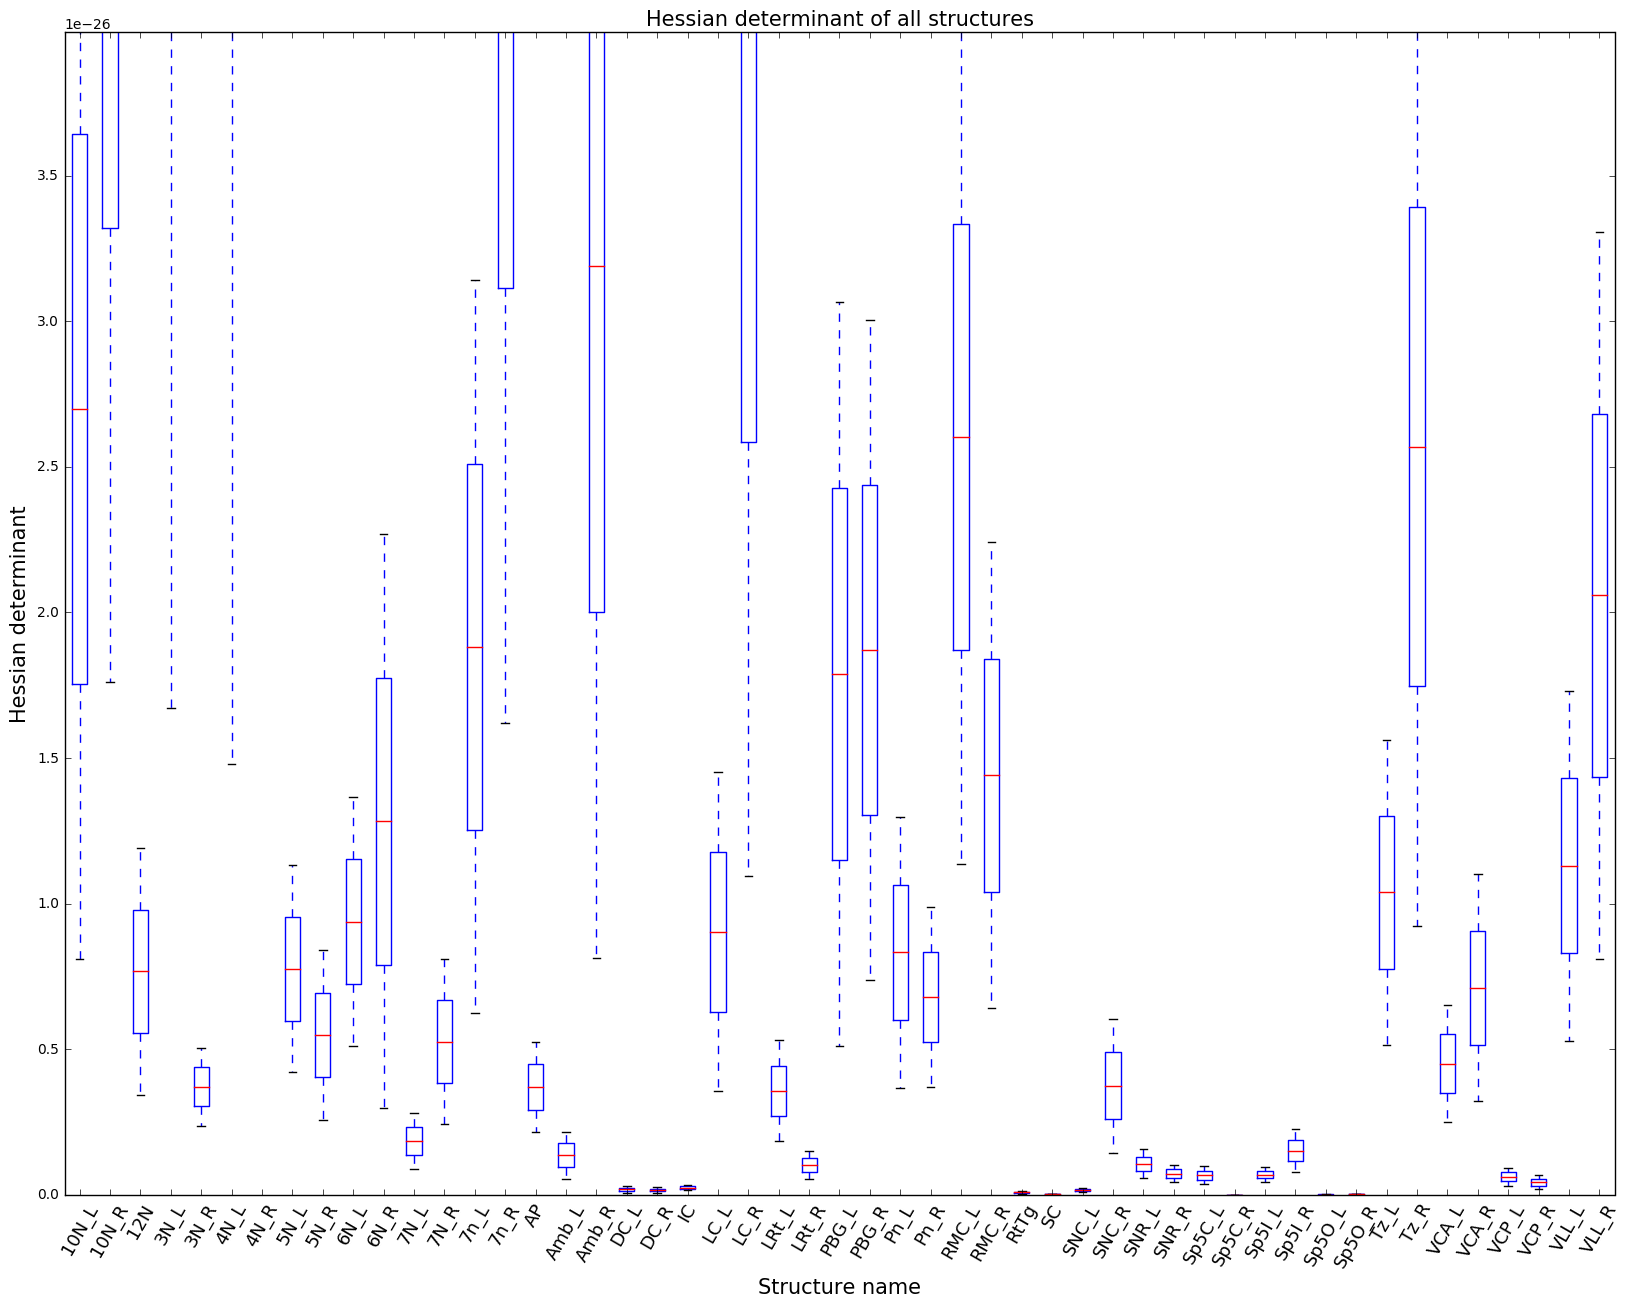

In [135]:
plt.figure(figsize=(20, 15));
plt.boxplot(H);
plt.xticks(range(1, len(boxplot_labels)+1), boxplot_labels, rotation='60', fontsize=13);
plt.xlabel('Structure name', fontsize=15);
plt.ylim(0, np.percentile(H, 90));
plt.ylabel('Hessian determinant', fontsize=15);
plt.title('Hessian determinant of all structures', fontsize=15);

# NEW VERSION

# peak radius computed using largest eigenvalue


In [24]:
# peak radius computed using largest eigenvalue

peak_radius_allStructures = {}
zscores_allStructures = {}

for name_s in structures_sided:

        
    hessian_fp = DataManager.get_hessian_filepath(stack_moving=stack_moving, stack_fixed=stack_fixed, 
                                        moving_volume_type='score', fixed_volume_type='score', 
                                        label=name_s,
                                        train_sample_scheme=train_sample_scheme, 
                                        global_transform_scheme=global_transform_scheme, 
                                        local_transform_scheme=local_transform_scheme)
    
    hessians = load_pickle(hessian_fp)
    
    
    zscore_fp = DataManager.get_zscore_filepath(stack_moving=stack_moving, stack_fixed=stack_fixed, 
                                        moving_volume_type='score', fixed_volume_type='score', 
                                        label=name_s,
                                        train_sample_scheme=train_sample_scheme, 
                                        global_transform_scheme=global_transform_scheme, 
                                        local_transform_scheme=local_transform_scheme)
    
    zscores = load_pickle(zscore_fp)
    
    zscores_allStructures[name_s] = zscores
    
    ###################################################
        
    peak_radius = {}
        
    for pooling_radius, (zscore, fmax, mu, std) in zscores.iteritems():
        
        peak_radius[pooling_radius] = {}
        
        for step_size, (H, fmax) in hessians.iteritems():
            if pooling_radius > step_size * 2:  # compute only if pooling radius is at least twice the step size
                U, S, UT = np.linalg.svd(H)
                peak_radius[pooling_radius][step_size] = np.sqrt(2*(fmax-mu)/S[0])

    peak_radius_allStructures[name_s] = peak_radius
    

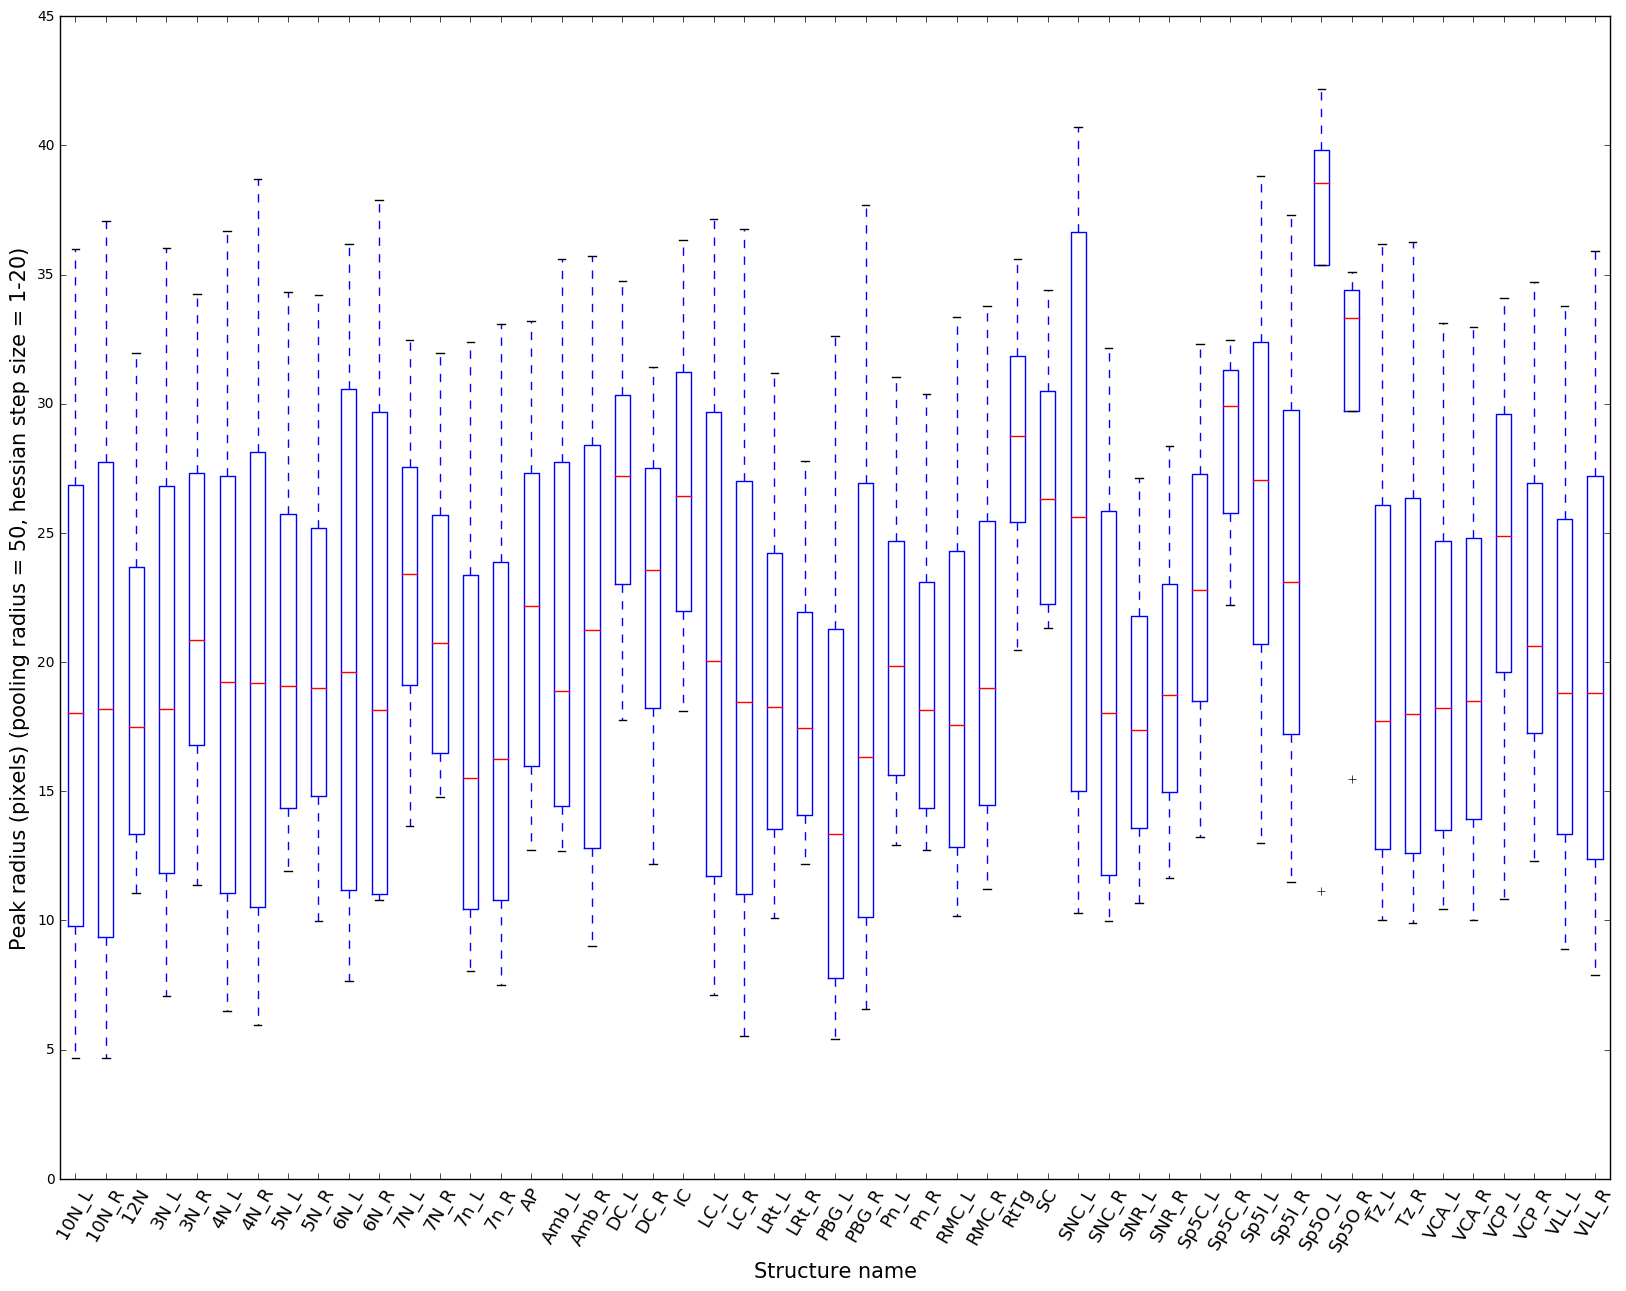

In [25]:
peak_radius_oneCombination = {n: x[50] for n, x in peak_radius_allStructures.iteritems()}
boxplot_labels = [n for n, x in sorted(peak_radius_oneCombination.items())]
D = [x.values() for n, x in sorted(peak_radius_oneCombination.items())]

plt.figure(figsize=(20, 15));
# plt.stem(range(1, len(boxplot_labels)+1), D);
plt.boxplot(D);
# plt.ylim([26, 42]);
plt.xticks(range(1, len(boxplot_labels)+1), boxplot_labels, rotation='60', fontsize=13);
plt.xlabel('Structure name', fontsize=15);
plt.ylabel('Peak radius (pixels) (pooling radius = 50, hessian step size = 1-20)', fontsize=15);

# peak radius computed using smallest eigenvalue


In [30]:
# peak radius computed using smallest eigenvalue

peak_radius_allStructures = {}
zscores_allStructures = {}

for name_s in structures_sided:

        
    hessian_fp = DataManager.get_hessian_filepath(stack_moving=stack_moving, stack_fixed=stack_fixed, 
                                        moving_volume_type='score', fixed_volume_type='score', 
                                        label=name_s,
                                        train_sample_scheme=train_sample_scheme, 
                                        global_transform_scheme=global_transform_scheme, 
                                        local_transform_scheme=local_transform_scheme)
    
    hessians = load_pickle(hessian_fp)
    
    
    zscore_fp = DataManager.get_zscore_filepath(stack_moving=stack_moving, stack_fixed=stack_fixed, 
                                        moving_volume_type='score', fixed_volume_type='score', 
                                        label=name_s,
                                        train_sample_scheme=train_sample_scheme, 
                                        global_transform_scheme=global_transform_scheme, 
                                        local_transform_scheme=local_transform_scheme)
    
    zscores = load_pickle(zscore_fp)
    
    zscores_allStructures[name_s] = zscores
    
    ###################################################
        
    peak_radius = {}
        
    for pooling_radius, (zscore, fmax, mu, std) in zscores.iteritems():
        
        peak_radius[pooling_radius] = {}
        
        for step_size, (H, fmax) in hessians.iteritems():
            if pooling_radius > step_size * 2:  # compute only if pooling radius is at least twice the step size
                U, S, UT = np.linalg.svd(H)
                peak_radius[pooling_radius][step_size] = np.sqrt(2*(fmax-mu)/S[-1])

    peak_radius_allStructures[name_s] = peak_radius
    

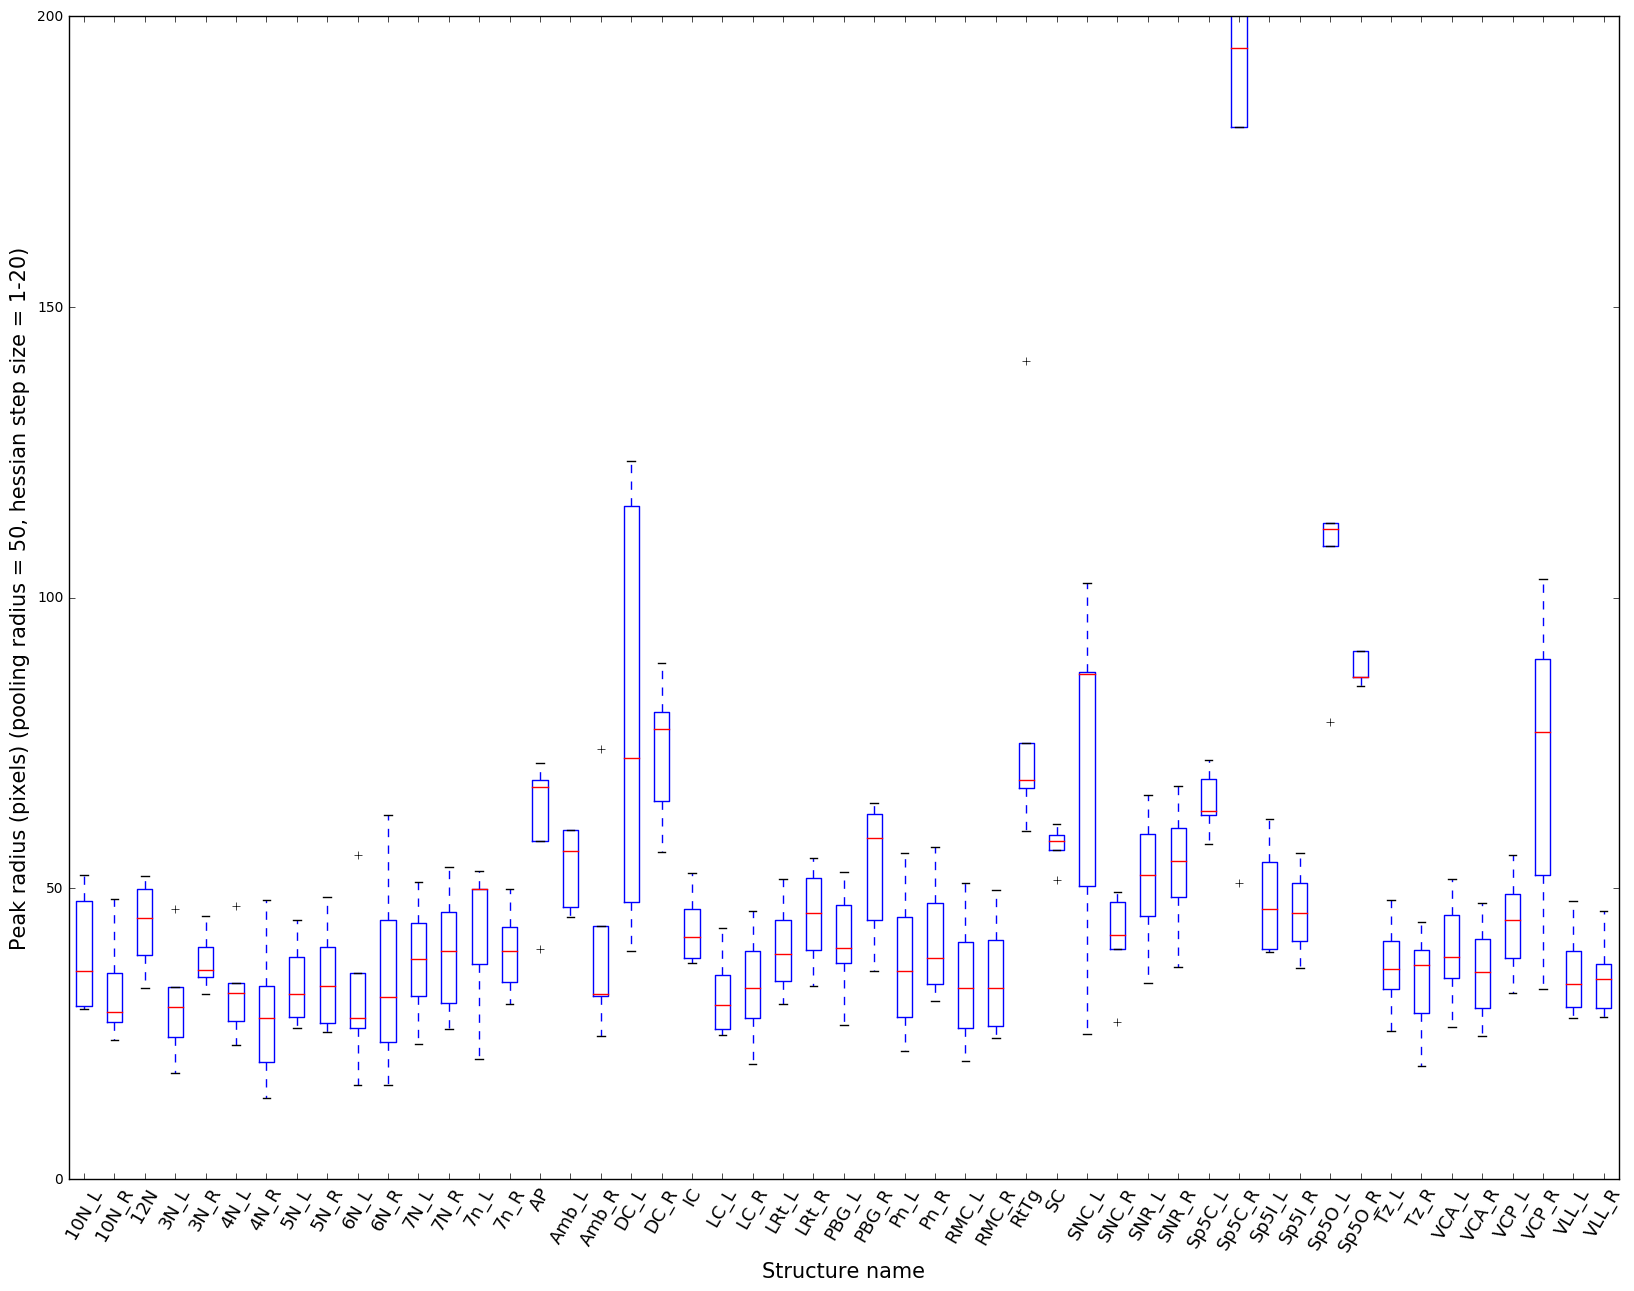

In [34]:
peak_radius_oneCombination = {n: x[50] for n, x in peak_radius_allStructures.iteritems()}
boxplot_labels = [n for n, x in sorted(peak_radius_oneCombination.items())]
D = [x.values() for n, x in sorted(peak_radius_oneCombination.items())]

plt.figure(figsize=(20, 15));
# plt.stem(range(1, len(boxplot_labels)+1), D);
plt.boxplot(D);
plt.ylim([0, 200]);
plt.xticks(range(1, len(boxplot_labels)+1), boxplot_labels, rotation='60', fontsize=13);
plt.xlabel('Structure name', fontsize=15);
plt.ylabel('Peak radius (pixels) (pooling radius = 50, hessian step size = 1-20)', fontsize=15);

In [14]:
# dets_allStructures = {}
# zscores_allStructures = {}

# for name_s in structures_sided:
for name_s in ['7N_R']:
    
    if local_transform_scheme == 1 or local_transform_scheme == 2:
    
        aligner = Aligner4(volume_fixed, {name_to_label_moving[name_s]: 
                                          volume_moving[name_to_label_moving[name_s]]}, \
                           labelIndexMap_m2f={name_to_label_moving[name_s]:
                                              name_to_label_fixed[convert_name_to_unsided(name_s)]})

    elif local_transform_scheme == 3 or local_transform_scheme == 4:
                
        aligner = Aligner4(volume_fixed, {name_to_label_moving[name_s]: volume_moving[name_to_label_moving[name_s]],
                                         name_to_label_moving[name_s+'_surround']: volume_moving[name_to_label_moving[name_s+'_surround']]}, \
                        labelIndexMap_m2f={name_to_label_moving[name_s]: name_to_label_fixed[convert_name_to_unsided(name_s)],
                                          name_to_label_moving[name_s+'_surround']: name_to_label_fixed[convert_to_original_name(name_s+'_surround')]})

    aligner.set_label_weights(label_weights_m)
    aligner.set_regularization_weights(reg_weights)
        
    # aligner.set_centroid(centroid_m='volume_centroid', centroid_f='volume_centroid')
    aligner.set_centroid(centroid_m='structure_centroid', centroid_f='centroid_m', 
                         indices_m=[name_to_label_moving[name_s]])
    
    ########################################
    
    tx_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
        DataManager.load_local_alignment_parameters(stack_moving=stack_moving,
                                                    moving_volume_type='score',
                                                    stack_fixed=stack_fixed,
                                                    fixed_volume_type='score',
                                                    train_sample_scheme=train_sample_scheme,
                                                    global_transform_scheme=global_transform_scheme,
                                                    local_transform_scheme=local_transform_scheme,
                                                   label=name_s,
                                                   trial_idx=1)
        
    ###########################################
    
#     def perturb(tx, ty, tz):
#         return aligner.compute_score(tx_params + [0,0,0,tx,0,0,0,ty,0,0,0,tz])

# #     dets = []
#     Hs = []
#     step_sizes = np.linspace(1, 20, 11)

#     for step_size in step_sizes:
#         h = nd.Hessian(lambda (tx, ty, tz): perturb(tx, ty, tz), step=(step_size, step_size, step_size))
#         H = h((0,0,0))
#     #     s, v = np.linalg.eigh(H)
# #         d = np.abs(np.linalg.det(H))
# #         dets.append(d)
#         Hs.append(H)

#     plt.plot(dets);
#     plt.xlabel('step size (pixels)');
#     plt.xticks(range(len(step_sizes)), map(lambda x: '%.2f' % x, step_sizes));
#     plt.ylabel('determinant of Hessian matrix');
#     plt.title('Hessian for different step sizes');
#     plt.show();
    
#     dets_allStructures[name_s] = dets

    ############################################################
    
#     fp = DataManager.get_hessian_filepath(stack_moving=stack_moving, stack_fixed=stack_fixed, 
#                                         moving_volume_type='score', fixed_volume_type='score', 
#                                         label=name_s,
#                                         train_sample_scheme=train_sample_scheme, 
#                                         global_transform_scheme=global_transform_scheme, 
#                                         local_transform_scheme=local_transform_scheme)

#     create_if_not_exists(os.path.dirname(fp))
#     save_pickle(dict(zip(step_sizes, Hs)), fp)
    
    ############################################################

    fmax = aligner.compute_score(tx_params)

#     zscores = []
#     pooling_radius_list = np.linspace(5, 20, 4)

#     for pooling_radius in pooling_radius_list:
        
    pooling_radius = 5

#         print pooling_radius

    n_grid = 10
    neighbor_scores = aligner.compute_scores_neighborhood_grid(tx_params, 
                                                               dxs=np.linspace(-pooling_radius, pooling_radius, n_grid),
                                                                dys=np.linspace(-pooling_radius, pooling_radius, n_grid),
                                                                dzs=np.linspace(-pooling_radius, pooling_radius, n_grid))
    z = (fmax - np.mean(neighbor_scores)) / np.std(neighbor_scores)

#     zscores.append(z)

#     plt.plot(pooling_radius_list, zscores);
#     plt.xlabel('pooling radius (pixels)');
#     # plt.xticks(range(len(pooling_radius_list)), map(lambda x: '%.2f' % x, pooling_radius_list));
#     plt.ylabel('z-score');
#     plt.title('Z-score for different pooling radius');
#     plt.show();
    
#     zscores_allStructures[name_s] = zscores
    

In [15]:
fmax

0.038657989352941513

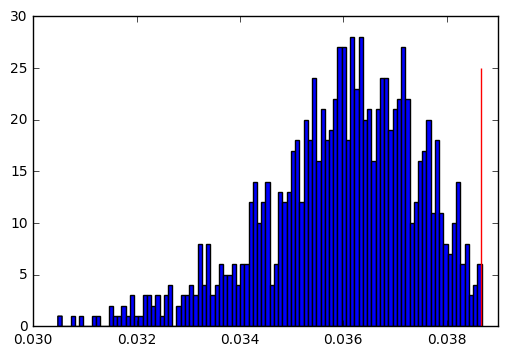

In [16]:
plt.hist(neighbor_scores, bins=100);
plt.vlines(fmax, 0, 25, colors='r');

In [147]:
# dets_allStructures = {}
# zscores_allStructures = {}

# for name_s in structures_sided:
for name_s in ['VLL_R']:
    
    if local_transform_scheme == 1 or local_transform_scheme == 2:
    
        aligner = Aligner4(volume_fixed, {name_to_label_moving[name_s]: 
                                          volume_moving[name_to_label_moving[name_s]]}, \
                           labelIndexMap_m2f={name_to_label_moving[name_s]:
                                              name_to_label_fixed[convert_name_to_unsided(name_s)]})

    elif local_transform_scheme == 3 or local_transform_scheme == 4:
                
        aligner = Aligner4(volume_fixed, {name_to_label_moving[name_s]: volume_moving[name_to_label_moving[name_s]],
                                         name_to_label_moving[name_s+'_surround']: volume_moving[name_to_label_moving[name_s+'_surround']]}, \
                        labelIndexMap_m2f={name_to_label_moving[name_s]: name_to_label_fixed[convert_name_to_unsided(name_s)],
                                          name_to_label_moving[name_s+'_surround']: name_to_label_fixed[convert_to_original_name(name_s+'_surround')]})

    aligner.set_label_weights(label_weights_m)
    aligner.set_regularization_weights(reg_weights)
        
    # aligner.set_centroid(centroid_m='volume_centroid', centroid_f='volume_centroid')
    aligner.set_centroid(centroid_m='structure_centroid', centroid_f='centroid_m', 
                         indices_m=[name_to_label_moving[name_s]])
    
    ########################################
    
    tx_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
        DataManager.load_local_alignment_parameters(stack_moving=stack_moving,
                                                    moving_volume_type='score',
                                                    stack_fixed=stack_fixed,
                                                    fixed_volume_type='score',
                                                    train_sample_scheme=train_sample_scheme,
                                                    global_transform_scheme=global_transform_scheme,
                                                    local_transform_scheme=local_transform_scheme,
                                                   label=name_s,
                                                   trial_idx=1)

    ############################################################

    fmax = aligner.compute_score(tx_params)

    pooling_radius = 5

#         print pooling_radius

    n_grid = 10
    neighbor_scores = aligner.compute_scores_neighborhood_grid(tx_params, 
                                                               dxs=np.linspace(-pooling_radius, pooling_radius, n_grid),
                                                                dys=np.linspace(-pooling_radius, pooling_radius, n_grid),
                                                                dzs=np.linspace(-pooling_radius, pooling_radius, n_grid))
    z = (fmax - np.mean(neighbor_scores)) / np.std(neighbor_scores)


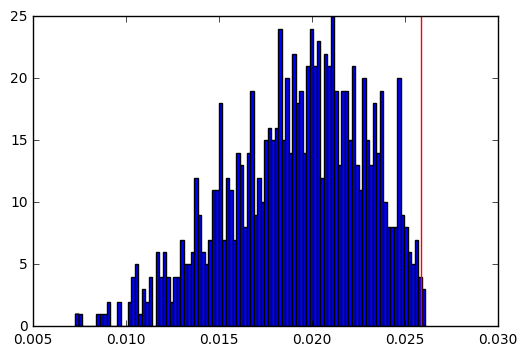

In [148]:
plt.hist(neighbor_scores, bins=100);
plt.vlines(fmax, 0, 25, colors='r');